# Training machine learning algorithm to detect showers

- **NaN columns are removed from the list of analyzed features**
- ExtraTreesClassifier: min_samples_leaf=10, min_samples_split=50
- weighted sample
- orig xy count nonzero removed
- removing event count restrictions

The goal of the method is to classify events into two categories - **shower**, **noise**

Main motivation behind the method was difficulty to formulate selection conditions by hand, although this was an initial plan behind applying feature extraction procedure on flight data. Defining simple manual rules and using them might still not be impossible. This is also motivation to use feature elimination methods to aid in formulating selection rules. Using decision tree-based methods for classification follows this line of thought. These methods include determining a feature importance and decision trees can be visualized to understand how is the decision being made.

This procedure consists of the following parts:
1. [Data selection](#Data-selection)
    - Visible simulated events (simu signal above the background, track recognized in simulated shower signal).
    - Noisy simulated events (triggered well outside of track injection GTU). However, the background noise is from the flight data.
    - Flight noise events (triggered well outside of GTU 40).
    - Flight classified events - classified by the manual classification.
    
    
2. [Preparation of the testing and training datasets](#Preparation-of-the-testing-and-training-datasets)
    - Limitation: only subset of all extracted features is used to decrease computational demands of feature selection. However, the subset should be large enough to contain most of the features that are expected to have some property allowing to distinguish between a shower track and noise. This procedure should be selecting around 1000 event features from the database.
    - All visible simulated events should be included.
    - Datasets should be balanced (same size of each class).
    - Noise datased should be constructed by following priority: classified noise, unclassified flight, unclassified simu.
    
    
3. [Feature selection and classification](#Feature-selection-and-classification)
    - *(This is part that might be changed in the later machine learning procedures)*
    - Variance thresholding to remove features without any variance.
    - Univariate feature selection to select smaller but still large enough subset of features (mainly to limit the computational demands). This particular procedure selects 400 features.
    - Recursive feature elimination with cross-validation - Training and validating *Extremely Randomized Trees model (ExtraTreesClassifier)* on multiple combinations of features aimed to select set of features that provide the best classification accuracy.
    
    
4. [T-SNE visualization of the dataset](#T-SNE-RFECV-features)
    - *Currently not finished (TODO)*
    - Using manifold learning approach to reduce dimensionality of the data (unsupervised) into two dimensions.
    - There should be possibility to observe clusters in the reduced-dimensionality data and cluster should correlate with known classes of the data.
    
    
5. [Evaluation of the recognition efficiency](#Recognition-efficiency-RFECV-model)
    - Accuracy of classification on the whole dataset.
    - Accuracy (specificity) of classification on the labeled dataset of noise events.
    - Dependence of sensitivity to true energy, azimuth, and zenith angles.
    - Dependence of sensitivity to background intensity. *NOT DONE YET (TODO)*.

## Imports
(section not in the report)

In [1]:
import sys
import os
import subprocess
import re
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql
import getpass
import matplotlib as mpl
import argparse
import glob
import traceback
import hashlib
import math
import collections
import functools

mpl.rcParams['figure.dpi'] = 80

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sp_opt

In [2]:
app_base_dir = '/home/spbproc/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

import event_processing_v3
import event_processing_v4
import postgresql_v3_event_storage
import dataset_query_functions_v3

import tool.acqconv
from data_analysis_utils import *
from data_analysis_utils_dataframes import *
# import supervised_classification as supc    
from utility_funtions import key_vals2val_keys

Welcome to JupyROOT 6.13/02


In [3]:
import sklearn.preprocessing
import sklearn.feature_selection
import sklearn.ensemble 
# import sklearn.neural_network
import sklearn.discriminant_analysis
import sklearn.model_selection
import sklearn.metrics
import sklearn.pipeline
from sklearn.externals import joblib

## Data selection

In [4]:
datasets_data_snippets_dir = 'ver4_machine_learning_w_labeled_flight_20200415_2'
source_data_snippets_dir = 'ver4_machine_learning_w_labeled_flight_20200415_2_randomforest'
data_snippets_dir = 'ver4_machine_learning_w_labeled_flight_20200415_2_randomforest_dimensionality_reduction'
os.makedirs(data_snippets_dir, exist_ok=True)
data_snippets_dir_figures = os.path.join(data_snippets_dir, 'figures')
os.makedirs(data_snippets_dir_figures, exist_ok=True)
data_snippets_dir_data = os.path.join(data_snippets_dir, 'data')
os.makedirs(data_snippets_dir_data, exist_ok=True)

In [5]:
event_processing_cls = event_processing_v4.EventProcessingV4
event_v3_storage_provider_simu = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config_simu_w_flatmap.ini'), 
    table_names_version='ver4',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_cls
)

query_functions_simu = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider_simu)

In [6]:
event_processing_cls = event_processing_v4.EventProcessingV4
event_v3_storage_provider_flight = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config_w_flatmap.ini'), 
    table_names_version='ver4',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_cls
)

query_functions_flight = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider_flight)

### Selected columns

Unlinke machine learning approach, that would be trained directly on pixels and learn to identify important features as a part of a learning (for example convolutional neural network), this approach depends on a set of preselected features. Its possible advantage is that there is no need to discover identified features and after the feature extraction, the training is faster.

One of the sources of possible bias in the analysis might be initial selection of features that are analyzed by feature elimination methods.

For this experiment selected features include:
- number of triggered pixels (`trg_count_nonzero`),
- some properties describing the background frames and background frames projection,
- similarly for all frames of an event
- informations about line orientations in projections of a shower
- informations about precision of estimation the orientation of a shower
- ...

In [7]:
common_included_columns_re_list = [
  ('^$','source_file_(acquisition|trigger)(_full)?|global_gtu|packet_id|gtu_in_packet|event_id|num_gtu'),
  ('^trg(_box_per_gtu|_pmt_per_gtu|_ec_per_gtu)?$', '^(count_nonzero|min|max|sum|mean)$'),
    
  ('^bg(_x_y)?$','^(mean_gz|mean|max|min|count_nonzero|sum|size)$'),
    
  ('^orig(_x_y)?$','^(count_nonzero|max|mean|mean_gz|sum|size)$'),

  '(proc\d|trg|alt\d)_(x|gtu)_(x|y)_hough_peak_thr[0-3]+_max_clu_major_line_(phi|rho)',
  '(proc\d|trg|alt\d)_(x|gtu)_(x|y)_hough_peak_thr[0-3]+_major_line_(phi|rho)',
  '(proc\d|trg|alt\d)_(x|gtu)_(x|y)_hough_peak_thr[0-3]+_line_clusters_((max_(peak|size|sum|area)_clu_(height|width|size))|count|sizes_max|clu_(widths|heights|areas)_max)',

  ('(proc\d|trg|alt\d)_(gtu|x)_[yx]_clusters',('^(count|sizes_max|sizes_min|clu_areas_max|max_(size|peak)_clu_(width|height|size))$')),  
  ('^proc\d_(x|gtu)_[yx]_hough_peak_thr3','major_line_coord_.*'),
    
]

#### List of columns of simu data tables used for analysis

In [8]:
common_columns_for_analysis_dict = query_functions_simu.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list=common_included_columns_re_list
)

print_columns_dict(common_columns_for_analysis_dict)

spb_processing_v4_simu_flatmap.event
	- event_id
	- source_file_acquisition_full
	- source_file_trigger_full
	- source_file_acquisition
	- source_file_trigger
	- global_gtu
	- packet_id
	- gtu_in_packet
	- num_gtu

spb_processing_v4_simu_flatmap.event_trg_box_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_simu_flatmap.event_trg_pmt_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_simu_flatmap.event_trg_ec_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_simu_flatmap.event_trg_x_y_clusters
	- count
	- sizes_min
	- sizes_max
	- clu_areas_max
	- max_size_clu_width
	- max_size_clu_height
	- max_peak_clu_width
	- max_peak_clu_height
	- max_peak_clu_size

spb_processing_v4_simu_flatmap.event_trg_gtu_x_clusters
	- count
	- sizes_min
	- sizes_max
	- clu_areas_max
	- max_size_clu_width
	- max_size_clu_height
	- max_peak_clu_width
	- max_peak_clu_height
	- max_peak_clu_size

spb_processing_v4_simu_flatmap.event_trg_gtu_y_clusters
	- count
	- sizes_min
	- sizes_max
	- clu_a

In [9]:
common_df_columns = query_functions_simu.get_dataframe_columns_from_dict(common_columns_for_analysis_dict)

#### List of columns of flight data tables used for analysis

In [10]:
flight_columns_for_analysis_dict = query_functions_flight.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list=common_included_columns_re_list
)

print_columns_dict(flight_columns_for_analysis_dict)

spb_processing_v4_flatmap.event
	- event_id
	- source_file_acquisition_full
	- source_file_trigger_full
	- source_file_acquisition
	- source_file_trigger
	- global_gtu
	- packet_id
	- gtu_in_packet
	- num_gtu

spb_processing_v4_flatmap.event_trg_box_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_flatmap.event_trg_pmt_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_flatmap.event_trg_ec_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_flatmap.event_trg_x_y_clusters
	- count
	- sizes_min
	- sizes_max
	- clu_areas_max
	- max_size_clu_width
	- max_size_clu_height
	- max_peak_clu_width
	- max_peak_clu_height
	- max_peak_clu_size

spb_processing_v4_flatmap.event_trg_gtu_x_clusters
	- count
	- sizes_min
	- sizes_max
	- clu_areas_max
	- max_size_clu_width
	- max_size_clu_height
	- max_peak_clu_width
	- max_peak_clu_height
	- max_peak_clu_size

spb_processing_v4_flatmap.event_trg_gtu_y_clusters
	- count
	- sizes_min
	- sizes_max
	- clu_areas_max
	- max_size_clu_width
	- m

### Data selection queries

#### Simu visible events (base)

All positive samples for the training are simulated shower tracks with background from the flight data (see notebook ver4_flatmap_visible_events). Events considered as positive samples have to contain track signal (see ver4_test_selection_visualization__simu_signal notebook) and has to be considered as visible (see ver4_flatmap_simu_visible_events notebook). 

Visibility of the event is decided by a rule that **there should be at least two frames of the event which  contain a signal pixel that is greater or equal to maximum background intensity in the frame**.

Additionally there is rule that the first trigger of a visible event should be in GTU $40\pm10$.

In [11]:
# not in the report

current_columns_for_analysis_dict = common_columns_for_analysis_dict

common_select_clause_str, common_tables_list = \
    query_functions_simu.get_query_clauses__select(current_columns_for_analysis_dict)

simu_where_clauses_str, simu_tables_list = \
    query_functions_simu.get_query_clauses__where_simu(
        gtu_in_packet_distacne=(40, 10), 
        num_frames_signals_ge_bg__ge=2, num_frames_signals_ge_bg__le=999
    )

joined_select_clause_str = common_select_clause_str + ', ' + \
    ', '.join(['{{database_schema_name}}.simu_event.{}'.format(attr) for attr in [
        'simu2npy_pathname', 'edetector_numphotons', 'edetector_numcellhits', 'edetector_numfee', 'eptttrigger_fnumtrigg', 
        'etruth_trueenergy', 'etruth_truetheta', 'etruth_truephi', 'egeometry_pos_z',
        'etruth_trueshowermaxpos_x', 'etruth_trueshowermaxpos_y', 'etruth_trueshowermaxpos_z'
    ]]) + ', ' + \
    ', '.join(['{{database_schema_name}}.simu_event_additional.{}'.format(attr) for attr in [
        'num_frames_counts_gt_bg', 'num_frames_signals_gt_bg', 'num_frames_signals_ge_bg'
    ]])

joined_tables_list = common_tables_list + simu_tables_list + [
    ('{database_schema_name}.simu_event_relation','{data_table_name}','event_id'),
    ('{database_schema_name}.simu_event_additional','{database_schema_name}.simu_event_relation','relation_id'),
    ('{database_schema_name}.simu_event','{database_schema_name}.simu_event_relation','simu_event_id'),
]

join_clauses_str = \
    query_functions_simu.get_query_clauses__join(joined_tables_list)

source_data_type_num = 3001

simu_events_selection_query = query_functions_simu.get_events_selection_query_plain(
    source_data_type_num=source_data_type_num,
    select_additional=joined_select_clause_str, 
    join_additional=join_clauses_str,
    where_additional=simu_where_clauses_str,
    order_by='{data_table_name}.event_id', 
    offset=0, 
    limit=350000,
    base_select='')

# print(simu_events_selection_query)

In [12]:
simu_df = psql.read_sql(simu_events_selection_query, event_v3_storage_provider_simu.connection)

In [13]:
simu_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_box_per_gtu_max,...,etruth_trueenergy,etruth_truetheta,etruth_truephi,egeometry_pos_z,etruth_trueshowermaxpos_x,etruth_trueshowermaxpos_y,etruth_trueshowermaxpos_z,num_frames_counts_gt_bg,num_frames_signals_gt_bg,num_frames_signals_ge_bg
0,11464,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,17.0,...,1.000000e+13,1.311530,2.02739,27000000.0,-174947.0,4109870.0,11689800.0,3.0,3.0,3.0
1,11465,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,163,1,35,24,17.0,...,1.000000e+13,0.696797,4.65066,27000000.0,977005.0,1573110.0,4239100.0,16.0,16.0,16.0
2,11486,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,22.0,...,1.000000e+13,1.311530,2.02739,27000000.0,-174947.0,4109870.0,11689800.0,2.0,2.0,2.0
3,11487,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,20.0,...,1.000000e+13,1.311530,2.02739,27000000.0,-174947.0,4109870.0,11689800.0,3.0,3.0,3.0
4,11494,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,166,1,38,10,1.0,...,1.000000e+13,0.941292,5.61160,27000000.0,-5503800.0,3748850.0,5879780.0,5.0,5.0,5.0


#### Simu noise events

Simu noise events are events that are caused by a trigger well outside of GTU of shower injection into a packet. 

It is not ideal to use these these events as samples of the dataset because due the way the background of these events is added to the signal. Simply, if there is less packets providing the background than simualated signal tracks then same event might be repeated multiple times in the dataset. 
Besides repetition of a background packet, background of the simualted event is created by repeating sequence of background frames, thus this might cause multiple events in a same packet. How often this situation happens has not been tested. It is not expected to be very typical.

Better method of constructing these events would help validity of this analysis.

In [14]:
# not in the report

current_columns_for_analysis_dict = common_columns_for_analysis_dict

common_select_clause_str, common_tables_list = \
    query_functions_simu.get_query_clauses__select(current_columns_for_analysis_dict)

# simu_noise_where_clauses_str = ' AND abs(gtu_in_packet-42) >= 20 '

# OPTIMIZATION, ROWS WITH NULL SHOULD BE ALSO ANALYZED  - noise simu df is not used
simu_noise_where_clauses_str = '''
    AND abs(gtu_in_packet-42) >= 20 
    AND {database_schema_name}.event_trg_gtu_y_hough_peak_thr1.major_line_phi IS NOT NULL 
    AND {database_schema_name}.event_trg_gtu_x_hough_peak_thr2.major_line_phi IS NOT NULL 
    AND {database_schema_name}.event_trg_x_y_hough_peak_thr1.major_line_phi IS NOT NULL
'''

joined_select_clause_str = common_select_clause_str + ', ' + \
    ', '.join(['{{database_schema_name}}.simu_event.{}'.format(attr) for attr in [
        'simu2npy_pathname', 'edetector_numphotons', 'edetector_numcellhits', 'edetector_numfee', 'eptttrigger_fnumtrigg', 
        'etruth_trueenergy', 'etruth_truetheta', 'etruth_truephi', 'egeometry_pos_z'
    ]]) + ', ' + \
    ', '.join(['{{database_schema_name}}.simu_event_additional.{}'.format(attr) for attr in [
        'num_frames_counts_gt_bg', 'num_frames_signals_gt_bg', 'num_frames_signals_ge_bg'
    ]])

joined_tables_list = common_tables_list + simu_tables_list + [
    ('{database_schema_name}.simu_event_relation','{data_table_name}','event_id'),
    ('{database_schema_name}.simu_event_additional','{database_schema_name}.simu_event_relation','relation_id'),
    ('{database_schema_name}.simu_event','{database_schema_name}.simu_event_relation','simu_event_id'),
]

join_clauses_str = \
    query_functions_simu.get_query_clauses__join(joined_tables_list)

source_data_type_num = 3001

noise_simu_events_selection_query = query_functions_simu.get_events_selection_query_plain(
    source_data_type_num=source_data_type_num,
    select_additional=joined_select_clause_str, 
    join_additional=join_clauses_str,
    where_additional=simu_noise_where_clauses_str,
    order_by='{data_table_name}.event_id', 
    offset=0, 
    limit=350000,
    base_select='')

# print(noise_simu_events_selection_query)

In [15]:
noise_simu_df = psql.read_sql(noise_simu_events_selection_query, event_v3_storage_provider_simu.connection)

In [16]:
noise_simu_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_box_per_gtu_max,...,edetector_numcellhits,edetector_numfee,eptttrigger_fnumtrigg,etruth_trueenergy,etruth_truetheta,etruth_truephi,egeometry_pos_z,num_frames_counts_gt_bg,num_frames_signals_gt_bg,num_frames_signals_ge_bg
0,11479,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,137,1,9,10,4.0,...,0,22456,0,1.000000e+13,0.765393,2.473790,27000000.0,NaN,NaN,NaN
1,11500,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,201,1,73,10,4.0,...,0,22456,0,1.000000e+13,0.765393,2.473790,27000000.0,NaN,NaN,NaN
2,11507,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,140,1,12,10,2.0,...,0,19291,0,1.000000e+13,1.192790,0.311703,27000000.0,NaN,NaN,NaN
3,11516,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,233,1,105,10,4.0,...,0,22456,0,1.000000e+13,0.765393,2.473790,27000000.0,NaN,NaN,NaN
4,11533,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,204,1,76,10,2.0,...,0,19291,0,1.000000e+13,1.192790,0.311703,27000000.0,NaN,NaN,NaN


#### Flight improbable events

More preferred set of background noise events consists of events that triggered outside of expected range of GTU. Note that these events were triggered in a configuration with lowered thresholds (number selected bin is halved). However, using such events on its own is not sufficient because the actual flight events are those that were triggered in default configuration.

In [17]:
# not in the report
current_columns_for_analysis_dict = flight_columns_for_analysis_dict

unl_noise_flight_select_clause_str, unl_noise_flight_tables_list = \
    query_functions_flight.get_query_clauses__select(current_columns_for_analysis_dict)

unl_noise_flight_clauses_str = \
    query_functions_flight.get_query_clauses__join(unl_noise_flight_tables_list)

unl_noise_source_data_type_num = 1

unl_noise_flight_where_clauses_str = ''' 
    AND abs(gtu_in_packet-42) > 20
    AND {database_schema_name}.event_orig_x_y.count_nonzero > 256*6
''' 

# intentionally removed
#     AND {database_schema_name}.event_trg_gtu_y_hough_peak_thr1.major_line_phi IS NOT NULL 
#     AND {database_schema_name}.event_trg_gtu_x_hough_peak_thr2.major_line_phi IS NOT NULL 
#     AND {database_schema_name}.event_trg_x_y_hough_peak_thr1.major_line_phi IS NOT NULL

unl_noise_flight_events_selection_query = \
    query_functions_flight.get_events_selection_query_plain(
        source_data_type_num=unl_noise_source_data_type_num,
        select_additional=unl_noise_flight_select_clause_str, 
        join_additional=unl_noise_flight_clauses_str,
        where_additional=unl_noise_flight_where_clauses_str,
        order_by='{data_table_name}.event_id', 
        offset=0, 
        limit=80000,                            # intentionally selecting incomplete subset to save memory !!!!!!!!!!!!!
    #     limit=350000,
        base_select='')

# print(unl_noise_flight_events_selection_query)

In [18]:
all_unl_noise_flight_df = psql.read_sql(unl_noise_flight_events_selection_query, event_v3_storage_provider_flight.connection)
# flight_df = psql.read_sql(flight_events_selection_query, event_v3_storage_provider_flight.connection)

In [19]:
all_unl_noise_flight_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_box_per_gtu_max,...,alt1_gtu_y_hough_peak_thr3_line_clusters_max_area_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_size_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_size_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_area_clu_size,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_size,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_size
0,63,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,94,0,94,12,1.0,...,3,9,3,9,3,9,3,5,5,5
1,65,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,131,1,3,12,2.0,...,9,15,9,15,9,15,9,18,18,18
2,70,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,226,1,98,10,1.0,...,7,8,7,8,7,8,7,10,10,10
3,84,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170503-085415...,trn_20170503-085415-001.001_C_inverse_flat_ave...,12,0,12,9,1.0,...,6,8,6,8,6,8,6,5,5,5
4,94,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,479,3,95,10,2.0,...,4,11,4,11,4,11,4,7,7,7


In [20]:
len(all_unl_noise_flight_df)

56229

In [21]:
# intetional !!!
unl_noise_flight_df = all_unl_noise_flight_df

#### Flight labeled events

Important part of the dataset is set of events that were triggered by the hardware. These events are expected to be the hardest to recognize. Previous classification experiments without this set of events significantly limited usefulness of the method because it classified 60% of the flight events sample as a track (see ver4_test_selection_visualization__simu_20181018 notebook).
Addition of a relatively small set of these events (around 1500) seems to help significantly (see ver4_machine_learning_flight_classification_tsne_cfg3 notebook).

The manually classified dataset has been created using web classification tool (script web_manual_classification.py). The tool is available at http://eusospb-data.michalvrabel.sk.

In [22]:
# EVENT_CLASSES = {
#     'dot': 2,
#     'top_left_ec': 5,
#     'blob': 12,
#     'large_blob': 11,
#     'short_single_gtu_track': 7,
#     'single_gtu_track': 3,
#     'noise': 1,
#     'cartesian_line': 4,
#     'strong_pmt_edge': 9,
#     'few_dots': 6,
#     'bg_increased_suddenly': 10,
#     'persistent_dot': 14,
#     'noise_unspecified': 0,
#     'unspecified': 8,
#     'shower': 13,
#     '2pix_line': 15,
#     'bright_blob': 16,
#     'blob_and_dots': 17,
#     'dot_w_blob_behind': 18,
#     'storng_light': 19,
#     'sparse_blobs': 20,
#     'noise_with_week_dot': 21
# }

EVENT_CLASSES = {
    'pixel': 2,
    'top_left_ec': 5,
    'blob': 12,
    'large_blob': 11,
    'short_single_gtu_track': 7,
    'single_gtu_track': 3,
    'noise': 1,
    'cartesian_line': 4,
    'strong_pmt_edge': 9,
    'few_pixels': 6,
    'bg_increased_suddenly': 10,
    'persistent_pixel': 14,
    'noise_unspecified': 0,
    'unspecified': 8,
    'shower': 13,
    '2pix_line': 15,
    'bright_blob': 16,
    'blob_and_pixels': 17,
    'pixel_w_blob_behind': 18,
    'storng_light': 19,
    'sparse_blobs': 20,
    'noise_with_weak_pixel': 21,
    #
    'unclassified': -1
}

EVENT_CLASSES_LABELS = {
    'Pixel': 2,
    'Top-left EC': 5,
    'Blob': 12,
    'Large blob': 11,
    'Short single GTU track': 7,
    'Single GTU track': 3,
    'Noise': 1,
    'Cartesian line': 4,
    'Strong MA-PMT edge': 9,
    'Few pixels': 6,
    'Sudden bg. increase': 10,
    'Persistent pixel': 14,
    'Unspecified noise': 0,
    'Unspecified': 8,
    'Air shower': 13,
    '2 pix line': 15,
    'Bright blob': 16,
    'Blob and pixels': 17,
    'Pixel with a blob behind': 18,
    'Storng light': 19,
    'Sparse blobs': 20,
    'Noise with a weak pixel': 21,
    #
    'Unclassified': -1
}

In [23]:
INVERSE_EVENT_CLASSES = {v: k for k, v in EVENT_CLASSES.items()}
INVERSE_EVENT_CLASSES_LABELS = {v: k for k, v in EVENT_CLASSES_LABELS.items()}

EVENT_CLASS_NUMBER_UNLABELED = -1
EVENT_CLASS_NUMBER_UNLABELED_NOISE = -2
EVENT_CLASS_LABLELED_NOISE_FLIGHT = -3  # in case of reduced classification

classification_table_name = event_v3_storage_provider_flight.database_schema_name + '.event_manual_classification'
classification_table_cls_column_name_simple = 'class_number'
classification_table_note_column_name_simple = 'note'
classification_table_last_modification_column_name_simple = 'last_modification'
classification_table_cls_column_name = classification_table_name + '.' + classification_table_cls_column_name_simple
classification_table_note_column_name = classification_table_name + '.' + classification_table_note_column_name_simple
classification_table_last_modification_column_name = classification_table_name + '.' + classification_table_last_modification_column_name_simple
classification_df_cls_column_name ='manual_classification_' + classification_table_cls_column_name_simple
classification_df_note_column_name ='manual_classification_' + classification_table_note_column_name_simple

##### Labeled filght noise In the database

In [24]:
# not in the report
current_columns_for_analysis_dict = flight_columns_for_analysis_dict

lbl_noise_flight_select_clause_str, lbl_noise_flight_tables_list = \
    query_functions_flight.get_query_clauses__select({
        **current_columns_for_analysis_dict,
        classification_table_name: [classification_table_cls_column_name_simple]
    })

lbl_noise_flight_clauses_str = query_functions_flight.get_query_clauses__join(lbl_noise_flight_tables_list)

lbl_noise_source_data_type_num = 1

lbl_noise_flight_where_clauses_str = ''' 
    AND abs(gtu_in_packet-42) <= 20
    AND {{database_schema_name}}.event_orig_x_y.count_nonzero > 256*6
    AND {classification_table_cls_column_name} NOT IN ({event_class_shower}, {event_class_unspecified})
    
'''.format(
    classification_table_cls_column_name=classification_table_cls_column_name,
    classification_table_last_modification_column_name=classification_table_last_modification_column_name,
    event_class_shower=EVENT_CLASSES['shower'],
    event_class_unspecified=EVENT_CLASSES['unspecified']
)

# intentionally removed

# AND {{database_schema_name}}.event_trg_gtu_y_hough_peak_thr1.major_line_phi IS NOT NULL 
# AND {{database_schema_name}}.event_trg_gtu_x_hough_peak_thr2.major_line_phi IS NOT NULL 
# AND {{database_schema_name}}.event_trg_x_y_hough_peak_thr1.major_line_phi IS NOT NULL
# AND {classification_table_last_modification_column_name} < '2019-04-09'

lbl_noise_flight_events_selection_query = \
    query_functions_flight.get_events_selection_query_plain(
        source_data_type_num=lbl_noise_source_data_type_num,
        select_additional=lbl_noise_flight_select_clause_str, 
        join_additional=lbl_noise_flight_clauses_str,
        where_additional=lbl_noise_flight_where_clauses_str,
        order_by='{data_table_name}.event_id', 
        offset=0, 
        limit=10000,                            # intentionally selecting incomplete subset to save memory !!!!!!!!!!!!!
    #     limit=350000,
        base_select='')

# print(lbl_noise_flight_events_selection_query)

In [25]:
lbl_noise_flight_db_df = psql.read_sql(lbl_noise_flight_events_selection_query, event_v3_storage_provider_flight.connection)

In [26]:
len(lbl_noise_flight_db_df)

4783

In [27]:
for k, v in lbl_noise_flight_db_df.groupby(classification_df_cls_column_name).count()['event_id'].items():
    print('{:<30}\t{:d}'.format(INVERSE_EVENT_CLASSES[k], v))

noise_unspecified             	225
noise                         	406
pixel                         	767
single_gtu_track              	218
cartesian_line                	77
top_left_ec                   	494
few_pixels                    	256
short_single_gtu_track        	188
bg_increased_suddenly         	478
large_blob                    	199
blob                          	424
persistent_pixel              	135
2pix_line                     	98
bright_blob                   	141
blob_and_pixels               	36
pixel_w_blob_behind           	434
storng_light                  	18
sparse_blobs                  	62
noise_with_weak_pixel         	127


##### Labeled flight noise in the file

In [28]:
lbl_noise_flight_df = pd.read_csv(os.path.join(datasets_data_snippets_dir, 'events/labeled_flight_noise.tsv.gz'), sep='\t')

In [29]:
len(lbl_noise_flight_df)

4783

In [30]:
for k, v in lbl_noise_flight_df.groupby(classification_df_cls_column_name).count()['event_id'].items():
    print('{:<30}\t{:d}'.format(INVERSE_EVENT_CLASSES[k], v))

noise_unspecified             	225
noise                         	406
pixel                         	767
single_gtu_track              	218
cartesian_line                	77
top_left_ec                   	494
few_pixels                    	256
short_single_gtu_track        	188
bg_increased_suddenly         	478
large_blob                    	199
blob                          	424
persistent_pixel              	135
2pix_line                     	98
bright_blob                   	141
blob_and_pixels               	36
pixel_w_blob_behind           	434
storng_light                  	18
sparse_blobs                  	62
noise_with_weak_pixel         	127


In [31]:
lbl_noise_flight_df.head()

,Unnamed: 0,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,...,proc3_gtu_y_gtu_x_hough_peak_thr2_major_line_phi_diff,proc3_gtu_x_hough_peak_thr2_major_line_phi_diff_pi_over_2,proc3_gtu_x_hough_peak_thr2_major_line_phi_diff_0,proc3_gtu_y_hough_peak_thr2_major_line_phi_diff_pi_over_2,proc3_gtu_y_hough_peak_thr2_major_line_phi_diff_0,proc3_gtu_y_gtu_x_hough_peak_thr3_major_line_phi_diff,proc3_gtu_x_hough_peak_thr3_major_line_phi_diff_pi_over_2,proc3_gtu_x_hough_peak_thr3_major_line_phi_diff_0,proc3_gtu_y_hough_peak_thr3_major_line_phi_diff_pi_over_2,proc3_gtu_y_hough_peak_thr3_major_line_phi_diff_0
0,0,75,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170501-050224...,trn_20170501-050224-001.001_C_inverse_flat_ave...,162,1,34,15,...,0.004520,1.570768,0.000028,1.566248,0.004549,0.002824,1.570768,0.000028,1.568001,0.002795
1,1,87,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170502-061155...,trn_20170502-061155-001.001_C_inverse_flat_ave...,168,1,40,92,...,0.098844,1.497258,0.073538,1.545491,0.025305,0.135601,1.491371,0.079426,1.514621,0.056175
2,2,95,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170501-050224...,trn_20170501-050224-001.001_C_inverse_flat_ave...,551,4,39,10,...,0.925304,0.845890,0.724906,0.079414,1.491383,0.456210,0.376796,1.194000,0.079414,1.491383
3,3,100,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,536,4,24,12,...,0.050787,1.317404,0.253393,1.368191,0.202605,0.211587,1.137754,0.433043,1.349341,0.221455
4,4,134,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170504-113024...,trn_20170504-113024-001.001_C_inverse_flat_ave...,550,4,38,13,...,0.169130,0.006536,1.564260,0.162594,1.408203,0.189990,0.022534,1.548263,0.212524,1.358273


#### Flight unclassified probable events

Small subset of flight unclassified events, that were caused by trigger around GTU 42, are selected to be used for basic check of the data reduction capability.

In [32]:
# not in the report
current_columns_for_analysis_dict = flight_columns_for_analysis_dict

unl_flight_select_clause_str, unl_flight_tables_list = \
    query_functions_flight.get_query_clauses__select(current_columns_for_analysis_dict)

unl_flight_clauses_str = \
    query_functions_flight.get_query_clauses__join(unl_flight_tables_list)

unl_flight_source_data_type_num = 1
# intentionally keeping trg conditions, for consistency
unl_flight_where_clauses_str = ''' 
    AND abs(gtu_in_packet-42) < 20
    AND {{database_schema_name}}.event_trg_gtu_y_hough_peak_thr1.major_line_phi IS NOT NULL 
    AND {{database_schema_name}}.event_trg_gtu_x_hough_peak_thr2.major_line_phi IS NOT NULL 
    AND {{database_schema_name}}.event_trg_x_y_hough_peak_thr1.major_line_phi IS NOT NULL
    AND {{database_schema_name}}.event_orig_x_y.count_nonzero > 256*6
    AND NOT EXISTS(
        SELECT {classification_table}.{{data_table_pk}} 
        FROM {classification_table} 
        WHERE {classification_table}.{{data_table_pk}} = {{data_table_name}}.{{data_table_pk}} LIMIT 1
    )
'''.format(
    classification_table=classification_table_name,
)

unl_flight_events_selection_query = query_functions_flight.get_events_selection_query_plain(
    source_data_type_num=unl_flight_source_data_type_num,
    select_additional=unl_flight_select_clause_str, 
    join_additional=unl_flight_clauses_str,
    where_additional=unl_flight_where_clauses_str,
    order_by='{data_table_name}.event_id',  # 'RANDOM()', # it might be skewed
    offset=0, 
    limit=10000,                            # intentionally selecting incomplete subset to save memory !!!!!!!!!!!!!
#     limit=350000,
    base_select='')

# print(unl_flight_events_selection_query)

In [33]:
unl_flight_df = psql.read_sql(unl_flight_events_selection_query, event_v3_storage_provider_flight.connection)

In [34]:
unl_flight_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_box_per_gtu_max,...,alt1_gtu_y_hough_peak_thr3_line_clusters_max_area_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_size_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_size_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_area_clu_size,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_size,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_size
0,61,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,39,0,39,11,7.0,...,2,6,2,6,2,6,2,5,5,5
1,67,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,166,1,38,11,7.0,...,3,8,3,8,3,8,3,8,8,8
2,73,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170501-050224...,trn_20170501-050224-001.001_C_inverse_flat_ave...,39,0,39,22,7.0,...,7,4,2,4,2,4,2,3,4,4
3,77,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170430-072445...,trn_20170430-072445-001.001_C_inverse_flat_ave...,38,0,38,33,668.0,...,24,55,24,55,24,55,24,391,391,391
4,78,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170429-055842...,trn_20170429-055842-001.001_C_inverse_flat_ave...,296,2,40,13,1152.0,...,3,11,3,11,3,11,3,12,12,12


#### Classification column for unlabeled filght
(not in the report)

In [35]:
unl_flight_df[classification_df_cls_column_name] = EVENT_CLASS_NUMBER_UNLABELED
unl_noise_flight_df[classification_df_cls_column_name] = EVENT_CLASS_NUMBER_UNLABELED_NOISE

### Flight datasets in dict
(not in the report)

In [36]:
flight_df_dict = {
    'unl_noise_flight_df': unl_noise_flight_df, 
    'lbl_noise_flight_df': lbl_noise_flight_df, 
    'unl_flight_df': unl_flight_df
}

### Closing connections
(not in the report)

In [37]:
event_v3_storage_provider_simu.connection.close()
event_v3_storage_provider_flight.connection.close()

### Combined simulations dataset

Simu dataframes are combined because they have same columns. 
Then within this dataset events are classified into four groups based on 
- **Query classification information** - Primary classification based on the original data selection query - original intention of the data selection.
- **Simu signal classification information** - Secondary classification is addition of labeled simu signal events. The events are loaded from tables prepared in ver4_test_selection_visualization__simu_signal notebook.

The groups are the following:
- **simu noise** - data selected by query intended to select visible events but simu signal is classified as noisy simu data
- **simu track** - data selected by query intended to select visible events and simu signal is classified as a signal - <br> *these events will be used as positive samples for machine learning algorithms*
- **noise track** - data selected by query intended to select noise events but simu signal is classified as a shower
- **noise noise** - data selected by query intended to select noise events and contains simu signal classified as noisy simu data (could be used as a part of negative samples dataset, although it is not ideal)
- **simu unclassified**, **noise unclassified** - data without any labelling for simu signal data, generaly should consist of short tracks or noisy tracks, in-between easily recognizable tracks and noise.
- **simu noise underflow**, **simu noise overflow**, **simu track underflow**, **simu track overflow** - data selected by query intended to select visible events but no simu signal is present (ideally should be empty)
- **noise noise underflow**, **noise noise overflow**, **noise track underflow**, **noise track overflow**   - data selected by query intended to select noise events and no simu signal is present - <br> *these events will be used as negative samples but with a low priority*

In [38]:
combined_simu_df = pd.concat([simu_df, noise_simu_df])

In [39]:
# flight_columns_list = list(lbl_noise_flight_df.columns.values)
# combined_flight_df = pd.concat([unl_noise_flight_df[flight_columns_list], lbl_noise_flight_df[flight_columns_list], unl_flight_df[flight_columns_list]])

In [40]:
print('len(simu_df) =', len(simu_df))
print('len(noise_simu_df) =', len(noise_simu_df))
print('len(combined_simu_df) =', len(combined_simu_df))

len(simu_df) = 35607
len(noise_simu_df) = 128793
len(combined_simu_df) = 164400


#### $R_{max}$ property of simulated showers

In [41]:
# 'etruth_trueshowermaxpos_x', 'etruth_trueshowermaxpos_y', 'etruth_trueshowermaxpos_z'
combined_simu_df['calc_etruth_trueshower_rmax'] = np.hypot(combined_simu_df['etruth_trueshowermaxpos_x'], combined_simu_df['etruth_trueshowermaxpos_y'])

#### Query classification information
Primary classification based on the original data selection query - original intention of the data selection.

In [42]:
combined_simu_df['cond_selection_query'] = 'undefined'
combined_simu_df.loc[combined_simu_df['event_id'].isin(simu_df['event_id']), 'cond_selection_query'] = 'simu'
combined_simu_df.loc[combined_simu_df['event_id'].isin(noise_simu_df['event_id']), 'cond_selection_query'] = 'noise'

In [43]:
if('simu_df' in locals()): del simu_df
if('noise_simu_df' in locals()): del noise_simu_df
# if('unl_noise_flight_df' in locals()): del unl_noise_flight_df
# if('lbl_noise_flight_df' in locals()): del lbl_noise_flight_df
# if('unl_flight_df' in locals()): del unl_flight_df

#### Simu signal classification information
Secondary classification is addition of labeled simu signal events.
The events are loaded from tables prepared in ver4_test_selection_visualization__simu_signal notebook.

In [44]:
# [['event_id', 'source_file_acquisition', 'global_gtu', 'packet_id', 'gtu_in_packet', 'num_gtu', 'source_file_acquisition_full']]

simu_signal_data_snippets_dir = 'ver4_simu_signal_data_snippets'
simu_signal_visible_tracks_table_path = os.path.join(simu_signal_data_snippets_dir, 'visible_tracks_table.tsv')
simu_signal_noisy_events_table_path = os.path.join(simu_signal_data_snippets_dir, 'noisy_events_table.tsv')

combined_simu_df, unclassified_simu_df, \
track_simu_df, track_underflow_simu_df, track_overflow_simu_df, \
noise_simu_df, noise_underflow_simu_df, noise_overflow_simu_df, \
simu_signal_track_events_df, simu_signal_noisy_events_df = \
    add_classification_columns(
        combined_simu_df, 
        simu_signal_visible_tracks_table_path, simu_signal_noisy_events_table_path,
        ret_simu_signal=True, ret_under_over_track=True, ret_split_noise=True,
        simu_track_class='track', simu_noise_class='noise',
        simu_track_underflow_class='track_underflow', simu_track_overflow_class='track_overflow',
        simu_noise_underflow_class='noise_underflow', simu_noise_overflow_class='noise_overflow',
        simu_events_file_pathname_dir=source_data_snippets_dir)

##### Combined label - joining query and labeled simu class

In [45]:
combined_simu_df['cond_selection_combined'] = 'undefined'

for selection_query in ['simu','noise']:
    for selection_simu_signal in ['noise','track']:
        for simu_signal_sync in ['', 'underflow', 'overflow']:
            t_selection_simu_signal = selection_simu_signal
            if len(simu_signal_sync) > 0:
                t_selection_simu_signal += '_' + simu_signal_sync
            combined_simu_df.loc[
                (combined_simu_df['cond_selection_query'] == selection_query ) & 
                (combined_simu_df['cond_selection_simple'] == t_selection_simu_signal), 
                'cond_selection_combined'] = selection_query + '_' + t_selection_simu_signal

##### Size of the  subsets

###### Simu signal labels

In [46]:
print('len(simu_signal_track_events_df)', len(simu_signal_track_events_df))
print('len(simu_signal_noisy_events_df)', len(simu_signal_noisy_events_df))
print('-'*50)
print('len(combined_simu_df)           ', len(combined_simu_df))
print('-'*50)
print('len(unclassified_simu_df)       ', len(unclassified_simu_df))
print('len(track_simu_df)              ', len(track_simu_df))
print('len(track_underflow_simu_df)    ', len(track_underflow_simu_df))
print('len(track_overflow_simu_df)     ', len(track_overflow_simu_df))
print('len(noise_simu_df)              ', len(noise_simu_df))
print('len(noise_underflow_simu_df)    ', len(noise_underflow_simu_df))
print('len(noise_overflow_simu_df)     ', len(noise_overflow_simu_df))
print('-'*50)
print('                                   ', 
      len(unclassified_simu_df) + \
      len(track_simu_df) + len(track_underflow_simu_df) + len(track_overflow_simu_df) + \
      len(noise_simu_df) + len(noise_underflow_simu_df) + len(noise_overflow_simu_df)
     )
print('-'*50)
print('len(track_simu_df)/len(combined_simu_df)        = ', len(track_simu_df)/len(combined_simu_df))
print('len(unclassified_simu_df)/len(combined_simu_df) = ', len(unclassified_simu_df)/len(combined_simu_df))
print('len(noise_simu_df)/len(combined_simu_df)        = ', len(noise_simu_df)/len(combined_simu_df))

len(simu_signal_track_events_df) 14866
len(simu_signal_noisy_events_df) 59279
--------------------------------------------------
len(combined_simu_df)            164400
--------------------------------------------------
len(unclassified_simu_df)        9288
len(track_simu_df)               35038
len(track_underflow_simu_df)     5983
len(track_overflow_simu_df)      16956
len(noise_simu_df)               1608
len(noise_underflow_simu_df)     24689
len(noise_overflow_simu_df)      70838
--------------------------------------------------
                                    164400
--------------------------------------------------
len(track_simu_df)/len(combined_simu_df)        =  0.2131265206812652
len(unclassified_simu_df)/len(combined_simu_df) =  0.056496350364963505
len(noise_simu_df)/len(combined_simu_df)        =  0.00978102189781022


###### Selection query and simu signal labels

In [47]:
for selection_query in ['simu','noise']:
    for selection_simu_signal in ['noise','track']:
        for simu_signal_sync in ['', 'underflow', 'overflow']:
            t_selection_simu_signal = selection_simu_signal
            if len(simu_signal_sync) > 0:
                t_selection_simu_signal += '_' + simu_signal_sync
            print('{:<30} {}'.format(
                '{} - {}'.format(selection_query, t_selection_simu_signal),
                np.count_nonzero(
                    (combined_simu_df['cond_selection_query'] == selection_query ) & \
                    (combined_simu_df['cond_selection_simple'] == t_selection_simu_signal))
            ))                

simu - noise                   4
simu - noise_underflow         0
simu - noise_overflow          0
simu - track                   34521
simu - track_underflow         0
simu - track_overflow          0
noise - noise                  1604
noise - noise_underflow        24689
noise - noise_overflow         70838
noise - track                  517
noise - track_underflow        5983
noise - track_overflow         16956


##### Example of track underflow subset

In [48]:
track_underflow_simu_df.sort_values('gtu_in_packet', ascending=False).head()

,alt1_gtu_x_clusters_clu_areas_max,alt1_gtu_x_clusters_count,alt1_gtu_x_clusters_max_peak_clu_height,alt1_gtu_x_clusters_max_peak_clu_size,alt1_gtu_x_clusters_max_peak_clu_width,alt1_gtu_x_clusters_max_size_clu_height,alt1_gtu_x_clusters_max_size_clu_width,alt1_gtu_x_clusters_sizes_max,alt1_gtu_x_clusters_sizes_min,alt1_gtu_x_hough_peak_thr1_line_clusters_clu_areas_max,...,trg_x_y_hough_peak_thr3_line_clusters_max_sum_clu_size,trg_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width,trg_x_y_hough_peak_thr3_line_clusters_sizes_max,trg_x_y_hough_peak_thr3_major_line_phi,trg_x_y_hough_peak_thr3_major_line_rho,calc_etruth_trueshower_rmax,cond_selection_query,simu2npy_signals_pathname,simu2npy_signals_pathname_short,cond_selection_simple
45187,517,1,47,87,11,47,11,87,87,312,...,2.0,4.0,2.0,0.705976,49.61780,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_21000000.00/energy_1.41e+12/thousnd21E3.2...,track_underflow
25116,470,1,47,99,10,47,10,99,99,448,...,32.0,40.0,32.0,1.542360,41.69640,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_24000000.00/energy_5.95e+12/simu.2017-07-...,track_underflow
21799,432,1,48,129,9,48,9,129,129,96,...,36.0,61.0,36.0,0.777668,48.29370,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_24000000.00/energy_5.95e+12/simu.2017-07-...,track_underflow
3711,480,1,48,158,10,48,10,158,158,84,...,34.0,47.0,34.0,0.070885,43.67790,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_27000000.00/energy_1.26e+12/thousnd27E2/s...,track_underflow
93171,380,1,38,130,10,38,10,130,130,984,...,5.0,14.0,5.0,5.732600,1.56028,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_18000000.00/energy_5.25e+12/simu.2017-07-...,track_underflow


##### Example of track overflow subset

In [49]:
track_overflow_simu_df.sort_values('gtu_in_packet', ascending=True).head()

,alt1_gtu_x_clusters_clu_areas_max,alt1_gtu_x_clusters_count,alt1_gtu_x_clusters_max_peak_clu_height,alt1_gtu_x_clusters_max_peak_clu_size,alt1_gtu_x_clusters_max_peak_clu_width,alt1_gtu_x_clusters_max_size_clu_height,alt1_gtu_x_clusters_max_size_clu_width,alt1_gtu_x_clusters_sizes_max,alt1_gtu_x_clusters_sizes_min,alt1_gtu_x_hough_peak_thr1_line_clusters_clu_areas_max,...,trg_x_y_hough_peak_thr3_line_clusters_max_sum_clu_size,trg_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width,trg_x_y_hough_peak_thr3_line_clusters_sizes_max,trg_x_y_hough_peak_thr3_major_line_phi,trg_x_y_hough_peak_thr3_major_line_rho,calc_etruth_trueshower_rmax,cond_selection_query,simu2npy_signals_pathname,simu2npy_signals_pathname_short,cond_selection_simple
53058,960,1,48,174,20,48,20,174,174,495,...,16.0,20.0,16.0,0.028378,6.05809,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_30000000.00/energy_2.00e+12/thousnd30E6.2...,track_overflow
58199,470,1,47,61,10,47,10,61,61,351,...,31.0,40.0,31.0,1.540630,41.73390,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_30000000.00/energy_1.58e+12/thousnd30E4.2...,track_overflow
58697,611,1,47,133,13,47,13,133,133,459,...,28.0,31.0,28.0,0.169183,1.69015,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_30000000.00/energy_1.58e+12/thousnd30E4.2...,track_overflow
59486,576,1,48,107,12,48,12,107,107,322,...,3.0,2.0,3.0,0.294290,45.28720,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_21000000.00/energy_3.94e+12/ter212.2017-0...,track_overflow
110238,611,1,47,133,13,47,13,133,133,459,...,28.0,31.0,28.0,0.169183,1.69015,NaN,noise,/mnt/data_sgbc1/SPBDATA_processed/spb_simu/pos...,posz_18000000.00/energy_8.50e+12/set18.2017-07...,track_overflow


##### Visualization of a few events

- Noise entries are sorted by number of simu signal pixles in x-y projection in descending order (`orig_x_y_count_nonzero`, sorted from the most potentially track-like),
- Track entries are sorted by num frames where maximum signal is greater equal maximum background in acsending order (`num_frames_signals_ge_bg`, from the least visible track events). Non-track-like simu signal might not be necessarly incorrectly labeled entries, just a small portion of a track in signal.
- Track underflow, track overflow should all contain empty simu signal data. Entries are sorted by GTU in packet in ascending or descending order, respectively.

In [50]:
# def vis_simu_signal_default(i, r, visualized_projections, fig, axs_flattened): 
#     show_simu_event_row(i, r, 
#         npy_pathname_column='simu2npy_signals_pathname', 
#         single_proj_width=4, single_proj_height=4,
#         print_info=False, warn_if_not_exact_simu=False)

# def vis_simu_signal_with_original(i, r, visualized_projections, fig, axs_flattened):
#     vis_simu_signal_default(i, r, visualized_projections, fig, axs_flattened)
#     show_simu_event_row(i, r, 
#         npy_pathname_column='simu2npy_signals_pathname', 
#         single_proj_width=4, single_proj_height=4,
#         print_info=False, warn_if_not_exact_simu=False,
#         simu_gtu_override=(30,50))

# for label, events_to_vis_df in [
#         ('noise', noise_simu_df.sort_values('orig_x_y_count_nonzero', ascending=False)), 
#         ('track', track_simu_df.sort_values('num_frames_signals_ge_bg', ascending=True)), 
#         ('track_underflow', track_underflow_simu_df.sort_values('gtu_in_packet', ascending=False)), 
#         ('track_overflow', track_overflow_simu_df.sort_values('gtu_in_packet', ascending=True))
# ]:
#     print('{} ({} entries)'.format(label, len(events_to_vis_df)))
#     print('-' * 50)
#     vis_events_df(
#         events_to_vis_df, 
#         events_per_figure=3, max_figures=1, vis_gtux=True, vis_gtuy=True, 
#         close_after_vis=False, show=True, 
#         additional_printed_columns=[
#             'num_frames_signals_ge_bg', 'simu2npy_signals_pathname_short', 
#             'cond_selection_query', 'cond_selection_simple'],
#         by_one=True,
#         extension_func=vis_simu_signal_with_original if label == 'track' else vis_simu_signal_default,
#         single_proj_width=4, single_proj_height=4
#     )
#     print('=' * 50)

### Adding new features

#### Rank column
The principle of a rank column is to combine values of features based on expected or calculated correlation of a column with likeliness of an event being a shower. The lowest value should correspond to the most probable shower track.

In this case, a short set of hand-picked list is utilized. More preferable way of doing this would be to use columns selected by a machine learning approach that calculates feature importance.

The provided features are normalized to 0-1 range, 
optionally, the values of the features are inverted (1-val) and weighted. 
Finally, the summed value is resulting rank of a record.

In [51]:
rank_columns = ['proc1_x_y_hough_peak_thr2_line_clusters_count', 'proc1_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width', 
                 'proc1_gtu_y_hough_peak_thr2_line_clusters_max_peak_clu_width', 'proc1_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width',
                 'trg_count_nonzero', 'num_gtu']

def add_rank_column_default(data_df):
    add_rank_column(data_df, 
                    rank_columns, 
                    ascending=[True, True, True, True, False, False], 
                    column_weights=[2,2,1,1,1,1],
                    print_max_vals=True, add_norm_columns=True, do_copy=False)

#### Difference columns
Expected property of air shower event is that at least in one of the shower projections in time should contain a line with a slope different than 0 or 90 degrees. 
In an ideal case an actual slope of a line is not important, only important information is slope difference to 0 or 90 degrees.

In [52]:
# not in the report
area_columns_prefix_list = ('proc1', 'proc2', 'proc3', 'trg')
area_columns_proj_list = ('x_y', 'gtu_x', 'gtu_y')
area_columns_thr_i_list = list(range(1,4))

area_columns_line_types = ['peak', 'sum', 'size']
area_columns_col_name_prefixes = ['{{prefix}}_{{proj}}_hough_peak_thr{{thr_i}}_line_clusters_max_{}_clu_'.format(t) for t in area_columns_line_types]

diff_columns_proc_range = (1,4)
diff_columns_alt_range = (1,1)
diff_columns_thr_range = (1,4)

diff_columns_prefixes = \
    ['proc{}'.format(i) for i in range(*diff_columns_proc_range)] + \
    ['alt{}'.format(i) for i in range(*diff_columns_alt_range)]

diff_columns_projs = ['gtu_x', 'gtu_y']
diff_columns_diff_types = ['pi_over_2', '0']

diff_columns_gtu_y_gtu_x_diff_format = '{prefix}_gtu_y_gtu_x_hough_peak_thr{thr_i}_major_line_phi_diff'
diff_columns_proj_diff_format = '{prefix}_{proj}_hough_peak_thr{thr_i}_major_line_phi_diff_{diff_type}'

#

common_extension_columns = ['event_id', 'rank']

for col in rank_columns:
    common_extension_columns.append('norm_' + col)

for prefix in area_columns_prefix_list:
    for proj in area_columns_proj_list:
        for thr_i in area_columns_thr_i_list:
            for col_name_prefix in area_columns_col_name_prefixes:
                common_extension_columns.append(col_name_prefix.format(prefix=prefix, proj=proj, thr_i=thr_i) + 'area')
    
for prefix in diff_columns_prefixes:
    for thr_i in range(*diff_columns_thr_range):
        common_extension_columns.append(diff_columns_gtu_y_gtu_x_diff_format.format(prefix=prefix, thr_i=thr_i))
        for proj in diff_columns_projs:
            for diff_type in diff_columns_diff_types:
                common_extension_columns.append(diff_columns_proj_diff_format.format(prefix=prefix, thr_i=thr_i, proj=proj, diff_type=diff_type))


simu_extension_columns = common_extension_columns
flight_extension_columns = common_extension_columns

# print(common_extension_columns)

#### Simu dataframe extension columns
(not in the report)

In [53]:
simu_event_ids_md5 = hashlib.md5(pickle.dumps(combined_simu_df['event_id'].values, protocol=0)).hexdigest()
simu_extension_columns_md5 = hashlib.md5(','.join(simu_extension_columns).encode()).hexdigest()
extension_columns_combined_simu_pathname = os.path.join(source_data_snippets_dir, 'extension_columns_simu_pathname_{}_{}.pkl.gz'.format(simu_event_ids_md5, simu_extension_columns_md5))
print(extension_columns_combined_simu_pathname)

ver4_machine_learning_w_labeled_flight_20200415_2_randomforest/extension_columns_simu_pathname_771a6a452a651f419ec12b94ac5eb28d_51d1629013c22c624c6bcb50d5b214a0.pkl.gz


In [54]:
if not os.path.exists(extension_columns_combined_simu_pathname):
    raise RuntimeError('Extension columns datasets are missing!')
    
#     print('Building calculating columns ...')
#     print('num_frames_signals_ge_bg bin column ...')
#     add_bin_column(combined_simu_df, 'num_frames_signals_ge_bg', 5)
#     print('  area columns ...')
#     for attr_prefix_format in area_columns_col_name_prefixes:    
#         add_area_columns(combined_simu_df, prefix_list=area_columns_prefix_list, proj_list=area_columns_proj_list, thr_i_list=area_columns_thr_i_list,
#                         attr_prefix_format=attr_prefix_format) 
#     print('  diff columns ...')
#     add_diff_columns(combined_simu_df, proc_range=diff_columns_proc_range, alt_range=diff_columns_alt_range, hough_peak_thr_range=diff_columns_thr_range)
#     print('  rank column ...')
#     add_rank_column_default(combined_simu_df)
#     print('Saving pickle ...')
#     combined_simu_df[simu_extension_columns].to_pickle(extension_columns_combined_simu_pathname, 'gzip')
    
else:
    print('Loading...')
    simu_extension_columns_df = pd.read_pickle(extension_columns_combined_simu_pathname, 'gzip')
    print('Merging ...')
    combined_simu_df = pd.merge(combined_simu_df, simu_extension_columns_df, on=['event_id'])
    del simu_extension_columns_df
    
combined_simu_df.head()

Loading...
Merging ...


,alt1_gtu_x_clusters_clu_areas_max,alt1_gtu_x_clusters_count,alt1_gtu_x_clusters_max_peak_clu_height,alt1_gtu_x_clusters_max_peak_clu_size,alt1_gtu_x_clusters_max_peak_clu_width,alt1_gtu_x_clusters_max_size_clu_height,alt1_gtu_x_clusters_max_size_clu_width,alt1_gtu_x_clusters_sizes_max,alt1_gtu_x_clusters_sizes_min,alt1_gtu_x_hough_peak_thr1_line_clusters_clu_areas_max,...,proc3_gtu_y_gtu_x_hough_peak_thr2_major_line_phi_diff,proc3_gtu_x_hough_peak_thr2_major_line_phi_diff_pi_over_2,proc3_gtu_x_hough_peak_thr2_major_line_phi_diff_0,proc3_gtu_y_hough_peak_thr2_major_line_phi_diff_pi_over_2,proc3_gtu_y_hough_peak_thr2_major_line_phi_diff_0,proc3_gtu_y_gtu_x_hough_peak_thr3_major_line_phi_diff,proc3_gtu_x_hough_peak_thr3_major_line_phi_diff_pi_over_2,proc3_gtu_x_hough_peak_thr3_major_line_phi_diff_0,proc3_gtu_y_hough_peak_thr3_major_line_phi_diff_pi_over_2,proc3_gtu_y_hough_peak_thr3_major_line_phi_diff_0
0,423,1,47,29,9,47,9,29,29,108,...,0.369017,1.271984,0.298812,1.500591,0.070205,0.386129,1.254872,0.315924,1.500591,0.070205
1,400,2,15,24,22,15,22,24,14,100,...,1.226577,0.029304,1.541493,1.255881,0.314915,1.219437,0.052804,1.517993,1.272241,0.298555
2,528,1,48,51,11,48,11,51,51,81,...,0.184444,1.210844,0.359952,1.395288,0.175508,0.184444,1.210844,0.359952,1.395288,0.175508
3,517,1,47,43,11,47,11,43,43,93,...,0.182697,1.315778,0.255018,1.498476,0.072321,0.272988,1.255128,0.315668,1.528116,0.042680
4,480,1,48,131,10,48,10,131,131,510,...,0.075040,1.338344,0.232453,1.263304,0.307493,0.090020,1.354184,0.216613,1.264164,0.306633


#### Flight dataframe extension columns
(not in the report)

In [55]:
extension_columns_flight_pathnames = {}

for subset_label, subset_df in \
        flight_df_dict.items():
    flight_event_ids_md5 = hashlib.md5(pickle.dumps(subset_df['event_id'].values, protocol=0)).hexdigest()
    flight_extension_columns_md5 = hashlib.md5(','.join(flight_extension_columns).encode()).hexdigest()
    extension_columns_flight_pathnames[subset_label] = \
        os.path.join(source_data_snippets_dir, 
                     'extension_columns_{}_{}_{}.pkl.gz'.format(
                         subset_label,
                         flight_event_ids_md5, flight_extension_columns_md5))
    print(extension_columns_flight_pathnames[subset_label])  

ver4_machine_learning_w_labeled_flight_20200415_2_randomforest/extension_columns_unl_noise_flight_df_0031211ca59ddc3a88309b7b0d1fcd9a_51d1629013c22c624c6bcb50d5b214a0.pkl.gz
ver4_machine_learning_w_labeled_flight_20200415_2_randomforest/extension_columns_lbl_noise_flight_df_26c252207eb069432123b232dd966f41_51d1629013c22c624c6bcb50d5b214a0.pkl.gz
ver4_machine_learning_w_labeled_flight_20200415_2_randomforest/extension_columns_unl_flight_df_685bf086f90d469ba31e1a51f3828302_51d1629013c22c624c6bcb50d5b214a0.pkl.gz


In [56]:
for subset_label, extension_columns_flight_pathname in extension_columns_flight_pathnames.items():
    if not os.path.exists(extension_columns_flight_pathname):
        raise RuntimeError('Extension columns datasets are missing!')
#         subset_df = flight_df_dict[subset_label]        
#         print('  Building calculating columns ...')
#         print('    area columns ...')
#         for attr_prefix_format in area_columns_col_name_prefixes:    
#             add_area_columns(subset_df, prefix_list=area_columns_prefix_list, proj_list=area_columns_proj_list, thr_i_list=area_columns_thr_i_list,
#                             attr_prefix_format=attr_prefix_format) 
#         print('    diff columns ...')
#         add_diff_columns(subset_df, proc_range=diff_columns_proc_range, alt_range=diff_columns_alt_range, hough_peak_thr_range=diff_columns_thr_range)
#         print('    rank column ...')
#         add_rank_column_default(subset_df)
#         print('  Saving pickle ...')
#         subset_df[flight_extension_columns].to_pickle(extension_columns_flight_pathname, 'gzip')

    else:
        print('  Loading ...')
        flight_extension_columns_df = pd.read_pickle(extension_columns_flight_pathname, 'gzip')
        print('  Merging ...')
        flight_df_dict[subset_label] = pd.merge(flight_df_dict[subset_label], flight_extension_columns_df, on=['event_id'])
        del flight_extension_columns_df
    
#     flight_df_dict[subset_label].head()

  Loading ...
  Merging ...
  Loading ...
  Merging ...
  Loading ...
  Merging ...


### Number of NaN entries
Events with NaN values in are currently rejected from showers dataset. 
However, final decision about rejection is made considering only columns using in ML algorithm.
Therefore, these numbers are not exactly indicative of the the final number of rejected events - only simu_track and noise_track should be indicative. (TODO requires check)

#### Number of NaN entries by query and simu signal labels

In [57]:
print('{:<30} {:<10} {}'.format(' ', 'NaN', 'Others'))
for selection_query in ['simu','noise']:
    for selection_simu_signal in ['noise','track']:
        for simu_signal_sync in ['', 'underflow', 'overflow']:
            t_selection_simu_signal = selection_simu_signal
            if len(simu_signal_sync) > 0:
                t_selection_simu_signal += '_' + simu_signal_sync
            subset_df = combined_simu_df[
                (combined_simu_df['cond_selection_query'] == selection_query ) & 
                (combined_simu_df['cond_selection_simple'] == t_selection_simu_signal)
            ]
            nan_row_count = np.count_nonzero(subset_df.isnull().any(axis=1))
            print('{:<30} {:<10} {}'.format(
                '{} - {}'.format(selection_query, t_selection_simu_signal),
                nan_row_count, len(subset_df) - nan_row_count
            ))

                               NaN        Others
simu - noise                   2          2
simu - noise_underflow         0          0
simu - noise_overflow          0          0
simu - track                   2699       31822
simu - track_underflow         0          0
simu - track_overflow          0          0
noise - noise                  1604       0
noise - noise_underflow        24689      0
noise - noise_overflow         70838      0
noise - track                  517        0
noise - track_underflow        5983       0
noise - track_overflow         16956      0


Flight data were already selected excluding entries with NaN values (actually NULL in PostgreSQL table).

In [58]:
for subset_label, subset_df in flight_df_dict.items():
    print('{:50}: {:d}'.format(subset_label, np.count_nonzero(subset_df.isnull().any(axis=1))))

unl_noise_flight_df                               : 43408
lbl_noise_flight_df                               : 627
unl_flight_df                                     : 0


#### NaN columns
Columns with a NaN value are either data from Hough transform on projections of triggered pixels - issue is a single pixel in a projection, thus it is impossible to determine orientation of a line. This impacts usable size of the dataset.
Other source of NaN values are additional information calculated for simulated shower - it is number of frames where number of signal pixels satisfies certain condition. The NaN value is present when there are no signal present in an identified event.

In [59]:
nan_columns = {}

for i, r in combined_simu_df[combined_simu_df.isnull().any(axis=1)].iterrows():
    for col, val in r.iteritems():
        if isinstance(val, numbers_Number) and math.isnan(val):
            if col not in nan_columns:
                nan_columns[col] = 0
            nan_columns[col] += 1

for col, val in nan_columns.items():
    print("{:<80} : {:<d}".format(col, val))

# del nan_columns

trg_gtu_y_hough_peak_thr1_line_clusters_clu_areas_max                            : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_clu_heights_max                          : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_clu_widths_max                           : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_count                                    : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_max_area_clu_height                      : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_max_area_clu_size                        : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_max_area_clu_width                       : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_height                      : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_size                        : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_width                       : 2207
trg_gtu_y_hough_peak_thr1_line_clusters_max_size_clu_height                      : 2207
trg_gtu_y_hough_peak_thr1_line_c

### Free memory
(not in the report)

In [60]:
# if 'unclassified_simu_df' in locals(): del unclassified_simu_df
# if 'track_simu_df' in locals(): del track_simu_df
# if 'noisy_simu_df' in locals(): del noisy_simu_df
# if 'simu_signal_track_events_df' in locals(): del simu_signal_track_events_df
# if 'simu_signal_noisy_events_df' in locals(): del simu_signal_noisy_events_df

In [61]:
# unclassified_simu_df, \
# track_simu_df, track_underflow_simu_df, track_overflow_simu_df, \
# noise_simu_df, noise_underflow_simu_df, noise_overflow_simu_df, \
# simu_signal_track_events_df, simu_signal_noisy_events_df

## Preparation of the testing and training datasets

Selected datasets are used in training and testing of a machine learning algorithm. 
Because of different inital number of noise and shower events, sizes of the datasets need to be balanced. This is done by decreasing a size of a smaller dataset.

Another potential solution would be to change class weights in the configuration of a machine learning algorithm.

### Column names
(not in the report)

In [62]:
analyzed_common_df_columns = list(common_df_columns)  # common_extension_columns  should be included
for col in [  
        'event_id',
        'source_file_acquisition_full',
        'source_file_trigger_full',
        'source_file_acquisition',
        'source_file_trigger',
        'global_gtu',
        'packet_id',
        'gtu_in_packet',
        'orig_x_y_count_nonzero',
        'bg_x_y_count_nonzero',
        'bg_count_nonzero',
        'orig_count_nonzero',
        re.compile('^bg_')

]:
    if isinstance(col, re._pattern_type):
        removed_cols = [_tc for _tc in analyzed_common_df_columns if col.search(_tc)]
        for _tc in removed_cols:
            analyzed_common_df_columns.remove(_tc)
    elif col in analyzed_common_df_columns:
        analyzed_common_df_columns.remove(col)
        
# IMPORTANT - NaN columns excluded from the analysis
    
for col in nan_columns.keys():
    if col in analyzed_common_df_columns:
        analyzed_common_df_columns.remove(col)
    
simu_class_column = 'cond_selection_combined'
flight_class_column = classification_df_cls_column_name
    
analyzed_common_df_columns_w_event_id = list(analyzed_common_df_columns) + ['event_id']
analyzed_common_df_columns_w_event_id_simu_class = list(analyzed_common_df_columns_w_event_id) + [simu_class_column]
analyzed_common_df_columns_w_event_id_flight_class = list(analyzed_common_df_columns_w_event_id) + [flight_class_column]

### Showers dataset
Showers dataset consists of processed simulated showers that belong to the **"simu track"** class and potentially flight events classified as an air shower.

Another potential source in the future might consist set of laser shots from Utah tests.

In [63]:
def query_simu_track(df):
    return df.query('cond_selection_combined == "simu_track"')

def query_event_class_shower(df):
    return df.query(
        '{classification_df_cls_column_name} == {event_class_shower}'.format(
            classification_df_cls_column_name=classification_df_cls_column_name,
            event_class_shower=EVENT_CLASSES['shower']
        )
    )


# this function is pointeless
# _flight_class
def get_labeled_shower(columns=analyzed_common_df_columns_w_event_id):
    #  unsuitable name of the dict item
    #  expected to be empty
    return query_event_class_shower(flight_df_dict['lbl_noise_flight_df']) \
        [columns] \
        .dropna()

# _simu_class
def get_simu_shower_track(columns=analyzed_common_df_columns_w_event_id):
    return query_simu_track(combined_simu_df) \
        [columns] \
        .dropna()


In [64]:
EVENT_CLASS_LABELED_SHOWER_FLIGHT = 2
EVENT_CLASS_SIMU_TRACK = 1

In [65]:
# shower_subset_class_numbers_dict = {
#     'lbl_shower_flight_df': EVENT_CLASS_LABELED_SHOWER_FLIGHT,
#     'combined_simu_df_shower_track': EVENT_CLASS_SIMU_TRACK
# }
# shower_subset_priority_order = ['lbl_shower_flight_df', 'combined_simu_df_shower_track']
# shower_subsets_list = [
    
#     # intentionally doing query first,
#     #  unsuitable name of the dict item
#     #  expected to be empty
#     query_event_class_shower(flight_df_dict['lbl_noise_flight_df']) \
#         [analyzed_common_df_columns_w_event_id_flight_class] \
#         .dropna(),
    
#     query_simu_track(combined_simu_df) \
#         [analyzed_common_df_columns_w_event_id] \
#         .dropna()
# ]


In [66]:
# old_shower_subsets_list = shower_subsets_list

In [67]:
shower_subset_df_funcs_dict = {
    'lbl_shower_flight_df': get_labeled_shower,
    'combined_simu_df_shower_track': get_simu_shower_track
}

shower_subset_class_numbers_dict = {
    'lbl_shower_flight_df': EVENT_CLASS_LABELED_SHOWER_FLIGHT,
    'combined_simu_df_shower_track': EVENT_CLASS_SIMU_TRACK
}
shower_subset_priority_order = ['lbl_shower_flight_df', 'combined_simu_df_shower_track']

def get_shower_subsets_list(
        df_columns={
            'lbl_shower_flight_df': analyzed_common_df_columns_w_event_id,
            'combined_simu_df_shower_track': analyzed_common_df_columns_w_event_id
        }, 
        shower_subset_df_funcs_dict=shower_subset_df_funcs_dict,
        shower_subset_priority_order=shower_subset_priority_order
):
    shower_subsets_list = []
    
    for shower_subset_label in shower_subset_priority_order:
        
        this_df_columns = df_columns[shower_subset_label] \
            if isinstance(df_columns, dict) else df_columns
        
        shower_subsets_list.append(
            shower_subset_df_funcs_dict[shower_subset_label](this_df_columns)
        )
    
    return shower_subsets_list

shower_subsets_list = get_shower_subsets_list()

In [68]:
# old_shower_subsets_list[1].event_id.equals(shower_subsets_list[1].event_id)

In [69]:
showers_nonan_w_event_id_df = pd.concat(shower_subsets_list)

Total size of the simualated showers dataset:

In [70]:
print('len(showers_nonan_w_event_id_df)', len(showers_nonan_w_event_id_df))

len(showers_nonan_w_event_id_df) 34521


### Non-showers dataset
Noise dataset is presently constructed from three subsets, in the follwing priority
1. **Classified noise** - *Flight labeled events* excluding classes `shower` and `unspecified`.
2. **Unclassified flight** - Dataset of noise of that triggered using configuration with decreased thresholds (bgf=0.5) outside of window of expected cause of the hardware trigger in GTU 40 (Dataset *Flight improbable events* - 20 GTU before or after GTU 42). 
3. **Overflow simu** - In principle same as **unclassified flight** but on simu simulation - frames consist of a repeating sequence. The entries should be slightly more different form the **unclassified flight** than **underflow simu**. That's set events should be generally shorter than than the repeated sequence length, on the other hand, **overflow simu** contains some events of containing repetition of the frames sequence (should be verified).
3. **Unclassified simu** - In principle same as **unclassified flight** but on simu simulation - **overflow** and **noise noise"** classified events.

In [71]:
EVENT_CLASS_NUMBER_SIMU_OVERFLOW = 0
EVENT_CLASS_NUMBER_SIMU_NOISE_NOISE = -4
EVENT_CLASS_NUMBER_SIMU_UNDERFLOW = -5

In [72]:
def query_labeled_flight_noise(df):
    return df.query(
        '{classification_df_cls_column_name} >= {min_class_number:d} ' \
        'and {classification_df_cls_column_name} not in ({event_class_shower}, {event_class_unspecified})'.format(
            classification_df_cls_column_name=classification_df_cls_column_name,
            min_class_number=min(EVENT_CLASSES.values()),
            event_class_shower=EVENT_CLASSES['shower'],
            event_class_unspecified=EVENT_CLASSES['unspecified']
    ))

def query_unlabeled_flight_noise(df):
    return df.query('{classification_df_cls_column_name} == {EVENT_CLASS_NUMBER_UNLABELED_NOISE:d}'.format(
        classification_df_cls_column_name=classification_df_cls_column_name, 
        EVENT_CLASS_NUMBER_UNLABELED_NOISE=EVENT_CLASS_NUMBER_UNLABELED_NOISE,
    ))
    
def query_simu_noise_noise(df):
    return df.query('cond_selection_combined == "noise_noise"')

def query_simu_overflow(df):
    return df[df['cond_selection_simple'].isin(['noise_overflow', 'track_overflow'])]

def query_simu_underflow(df):
    return df[df['cond_selection_simple'].isin(['noise_underflow', 'track_underflow'])]

def concatenate_balanced(df_list):
    min_len = min([len(t_df) for t_df in df_list])
    df_shortened = [(t_df.iloc[np.random.randint(0, len(t_df), min_len)] if len(t_df) > min_len else t_df) \
                    for t_df in df_list]
    return pd.concat(df_shortened)

def get_labeled_flight_noise(columns=analyzed_common_df_columns_w_event_id_flight_class):
    return query_labeled_flight_noise(flight_df_dict['lbl_noise_flight_df']) \
        [columns] \
        .dropna()

def get_unlabeled_flight_noise(columns=analyzed_common_df_columns_w_event_id_flight_class):
    return query_unlabeled_flight_noise(flight_df_dict['unl_noise_flight_df']) \
        [columns] \
        .dropna()

def get_simu_noise_noise(columns=analyzed_common_df_columns_w_event_id_simu_class):
    return query_simu_noise_noise(combined_simu_df) \
        [columns] \
        .dropna()

def get_simu_overflow(columns=analyzed_common_df_columns_w_event_id_simu_class):
    return query_simu_overflow(combined_simu_df) \
        [columns] \
        .dropna()

def get_simu_underflow(columns=analyzed_common_df_columns_w_event_id_simu_class):
    return query_simu_underflow(combined_simu_df) \
        [columns] \
        .dropna()

Size of the dataset in progressively extended by non-shower data until it as large as shower data dataset. 
If required number of events is lower than size of a subset, events are randomly sampled from the subset.

In [73]:
noise_subset_df_funcs_dict = {
    'lbl_noise_flight_df': get_labeled_flight_noise, 
    'unl_noise_flight_df': get_unlabeled_flight_noise,
    'combined_simu_df_overflow': get_simu_overflow,
    'combined_simu_df_noise_noise': get_simu_noise_noise,
    'combined_simu_df_underflow': get_simu_underflow,
}

noise_subset_class_numbers_dict = {
    'lbl_noise_flight_df': EVENT_CLASS_LABLELED_NOISE_FLIGHT, 
    'unl_noise_flight_df': EVENT_CLASS_NUMBER_UNLABELED_NOISE, 
    'combined_simu_df_overflow': EVENT_CLASS_NUMBER_SIMU_OVERFLOW,
    'combined_simu_df_noise_noise': EVENT_CLASS_NUMBER_SIMU_NOISE_NOISE,
    'combined_simu_df_underflow': EVENT_CLASS_NUMBER_SIMU_UNDERFLOW
}

noise_subset_priority_order = [
    'lbl_noise_flight_df', 'unl_noise_flight_df', 
    #'combined_simu_df_overflow', 'combined_simu_df_noise_noise', 'combined_simu_df_underflow'
]

np.random.seed(123)

# -----------------------------------------------------------


def get_non_shower_subsets_list(
        df_columns={
            'lbl_noise_flight_df': analyzed_common_df_columns_w_event_id,  #_flight_class,
            'unl_noise_flight_df': analyzed_common_df_columns_w_event_id,  #_flight_class,
            'combined_simu_df_overflow': analyzed_common_df_columns_w_event_id,  #_simu_class,
            'combined_simu_df_noise_noise': analyzed_common_df_columns_w_event_id,  #_simu_class,
            'combined_simu_df_underflow': analyzed_common_df_columns_w_event_id,  #_simu_class,
        }, 
        noise_subset_df_funcs_dict=noise_subset_df_funcs_dict,
        noise_subset_priority_order=noise_subset_priority_order,
        len_limit=len(showers_nonan_w_event_id_df)
):

    non_shower_subsets_list = []
    non_shower_subsets_tot_len = 0
    for noise_subset_label in noise_subset_priority_order:
        get_non_shower_events_func = noise_subset_df_funcs_dict[noise_subset_label]
        
        this_df_columns = df_columns[noise_subset_label] \
            if isinstance(df_columns, dict) else df_columns
        
        non_shower_subset_df = get_non_shower_events_func(this_df_columns)
        new_len = len(non_shower_subset_df) + non_shower_subsets_tot_len

        print('Current subset size: {:<7} ; Added {:<30} subset size: {:<7} ; ' \
              'Potentional new dataset size: {:<7} ; Required size: {:<7}'.format(
            non_shower_subsets_tot_len, noise_subset_label, len(non_shower_subset_df),
            new_len, len_limit
        ))

        if new_len > len_limit:
            # TODO: THIS IS A BUG, REPEATED INDICES !!!
            non_shower_subset_df = \
                non_shower_subset_df.iloc[
                    # the bug was here !
#                     np.random.randint(0, len(non_shower_subset_df), 
#                                       len_limit - non_shower_subsets_tot_len)
                    # corrected solution
                    np.random.choice(
                        len(non_shower_subset_df), 
                        len_limit - non_shower_subsets_tot_len, 
                        replace=False)
            ]

        non_shower_subsets_list.append(non_shower_subset_df)
        non_shower_subsets_tot_len += len(non_shower_subset_df)

        if new_len >= len_limit:
            break
            
    return non_shower_subsets_list

# -------------------------------------------------------------
            
non_shower_subsets_list = get_non_shower_subsets_list()


Current subset size: 0       ; Added lbl_noise_flight_df            subset size: 4783    ; Potentional new dataset size: 4783    ; Required size: 34521  
Current subset size: 4783    ; Added unl_noise_flight_df            subset size: 56229   ; Potentional new dataset size: 61012   ; Required size: 34521  


In [74]:
non_showers_nonan_w_event_id_df = pd.concat(non_shower_subsets_list)

Total number of noise subset required:

In [75]:
len(non_shower_subsets_list)

2

Concatenated noise subsets total size:

In [76]:
print(len(non_showers_nonan_w_event_id_df))

34521


### Export of the datasets into tsv

Datasets are saved to be usable externally with different algorithms but reproducing these results.

In [77]:
overwrite_tsv_dump_files = False

In [78]:
# tsv_dump_dir = os.path.join(data_snippets_dir, 'events')
# os.makedirs(tsv_dump_dir, exist_ok=True)

# # labeled_flight_shower_tsv = os.path.join(tsv_dump_dir, 'labeled_flight_shower.tsv.gz')
# simu_track_tsv = os.path.join(tsv_dump_dir, 'simu_track.tsv.gz')
# labeled_flight_noise_tsv = os.path.join(tsv_dump_dir, 'labeled_flight_noise.tsv.gz')
# unlabeled_flight_noise_tsv = os.path.join(tsv_dump_dir, 'unlabeled_flight_noise.tsv.gz')

# simu_overflow_tsv = os.path.join(tsv_dump_dir, 'simu_overflow.tsv.gz')
# simu_noise_noise_tsv = os.path.join(tsv_dump_dir, 'simu_noise_noise.tsv.gz')
# simu_underflow_tsv = os.path.join(tsv_dump_dir, 'simu_underflow.tsv.gz')

# # print(labeled_flight_shower_tsv)
# print(simu_track_tsv)
# print(labeled_flight_noise_tsv)
# print(unlabeled_flight_noise_tsv)

# print(simu_overflow_tsv)
# print(simu_noise_noise_tsv)
# print(simu_underflow_tsv)

# # query_event_class_shower(flight_df_dict['lbl_noise_flight_df']).to_csv(labeled_flight_shower_tsv, sep='\t', compression='gzip')
# if overwrite_tsv_dump_files or not os.path.exists(simu_track_tsv):
#     query_simu_track(combined_simu_df).to_csv(simu_track_tsv, sep='\t', compression='gzip')
# if overwrite_tsv_dump_files or not os.path.exists(labeled_flight_noise_tsv):    
#     query_labeled_flight_noise(flight_df_dict['lbl_noise_flight_df']).to_csv(labeled_flight_noise_tsv, sep='\t', compression='gzip')
# if overwrite_tsv_dump_files or not os.path.exists(unlabeled_flight_noise_tsv):    
#     query_unlabeled_flight_noise(flight_df_dict['unl_noise_flight_df']).to_csv(unlabeled_flight_noise_tsv, sep='\t', compression='gzip')

# if overwrite_tsv_dump_files or not os.path.exists(simu_underflow_tsv):    
#     query_simu_underflow(combined_simu_df).to_csv(simu_underflow_tsv, sep='\t', compression='gzip')
# if overwrite_tsv_dump_files or not os.path.exists(simu_overflow_tsv):    
#     query_simu_overflow(combined_simu_df).to_csv(simu_overflow_tsv, sep='\t', compression='gzip')
# if overwrite_tsv_dump_files or not os.path.exists(simu_noise_noise_tsv):    
#     query_simu_noise_noise(combined_simu_df).to_csv(simu_noise_noise_tsv, sep='\t', compression='gzip')

#### Additional checks
(not in the report)

In [79]:
print(np.count_nonzero(combined_simu_df['num_frames_signals_ge_bg'] == combined_simu_df['num_frames_signals_gt_bg']))
print(np.count_nonzero(combined_simu_df['num_frames_signals_ge_bg'] != combined_simu_df['num_frames_signals_gt_bg']))

41071
123329


In [80]:
combined_simu_df[combined_simu_df['num_frames_signals_ge_bg'].isnull()][['event_id', 'cond_selection_combined', 'num_frames_counts_gt_bg']].head()

,event_id,cond_selection_combined,num_frames_counts_gt_bg
35607,11479,noise_noise_underflow,NaN
35608,11500,noise_noise_overflow,NaN
35609,11507,noise_noise_underflow,NaN
35610,11516,noise_noise_overflow,NaN
35611,11533,noise_noise_overflow,NaN


### Concatenated arrays (np.ndarray)
(not in the report)

Transformation of multiple `pandas.DataFrame` objects into concatenated `numpy.ndarray`. 
Following arrays are created:
- `learning_data__X` - training data for an algorithm - data
- `learning_data__y` - training data for an algorithm - labels
- `learning_data__event_id` - event id of the data in the dataset - important after `test_train_split()`, used to associate predictions with the original events
- `learning_data__source_class` - source class of the data in the dataset - important after `test_train_split()`, used to associate predictions with the original events, especially to be able to expres accuracy of predictions for a specific source class of data - e.g. label flight noise events

In [81]:
learning_data__X = np.concatenate([
    showers_nonan_w_event_id_df[analyzed_common_df_columns].values, 
    non_showers_nonan_w_event_id_df[analyzed_common_df_columns].values
])
learning_data__y = np.concatenate([
    np.ones(len(showers_nonan_w_event_id_df)), 
    np.zeros(len(non_showers_nonan_w_event_id_df))
])
learning_data__event_id = np.concatenate([
    showers_nonan_w_event_id_df['event_id'].values, 
    non_showers_nonan_w_event_id_df['event_id'].values
])
learning_data__source_class = np.concatenate([
#     np.ones(len(showers_nonan_w_event_id_df)),
    *[np.ones(len(shower_subset_df)) * shower_subset_class_numbers_dict[shower_subset_label] \
      for shower_subset_df, shower_subset_label in zip(shower_subsets_list, shower_subset_priority_order)],
    *[np.ones(len(non_shower_subset_df)) * noise_subset_class_numbers_dict[noise_subset_label] \
      for non_shower_subset_df, noise_subset_label in zip(non_shower_subsets_list, noise_subset_priority_order)]
])

In [82]:
lbl_noise_flight_db_df[['event_id', classification_df_cls_column_name]]

,event_id,manual_classification_class_number
0,75,0
1,87,19
2,95,15
3,100,1
4,134,2
5,176,2
6,189,18
7,273,10
8,322,3
9,396,2


In [83]:
np.count_nonzero(
    flight_df_dict['unl_noise_flight_df']['event_id'].isin(
        lbl_noise_flight_db_df['event_id']
    )
)

0

In [84]:
len(lbl_noise_flight_db_df)

4783

In [85]:
np.count_nonzero(
    lbl_noise_flight_db_df['event_id'].isin(flight_df_dict['lbl_noise_flight_df']['event_id'])
)

4783

In [86]:
np.count_nonzero(
    lbl_noise_flight_db_df['event_id'].isin(flight_df_dict['unl_noise_flight_df']['event_id'])
)

0

In [87]:
learning_data__manual_classification_class = np.concatenate([
    *[np.ones(len(shower_subset_df)) * EVENT_CLASSES['shower'] \
      for shower_subset_df, shower_subset_label in zip(shower_subsets_list, shower_subset_priority_order)],
    *[(
        pd.merge(non_shower_subset_df[['event_id']], 
         flight_df_dict['lbl_noise_flight_df'][['event_id', classification_df_cls_column_name]], 
         on='event_id', how='left')[classification_df_cls_column_name]
        if 'lbl_noise_flight_df' == noise_subset_label else
        np.ones(len(non_shower_subset_df)) * EVENT_CLASSES['noise_unspecified']
      ) for non_shower_subset_df, noise_subset_label in zip(non_shower_subsets_list, noise_subset_priority_order)]
])

# #------------

# learning_data__manual_classification_class_extended = []

# for non_shower_subset_df, noise_subset_label in zip(non_shower_subsets_list, noise_subset_priority_order):
#     cls_column_value_ser = None
#     if 'lbl_noise_flight_df' == noise_subset_label:
#         cls_column_value_ser = pd.merge(non_shower_subset_df[['event_id']], 
#          flight_df_dict['lbl_noise_flight_df'][['event_id', classification_df_cls_column_name]], 
#          on='event_id', how='left')[classification_df_cls_column_name]
#     else:
#         cls_column_value_ser = pd.merge(non_shower_subset_df[['event_id']], 
#          lbl_noise_flight_db_df[['event_id', classification_df_cls_column_name]], 
#          on='event_id', how='left')[classification_df_cls_column_name]
    
#     print(noise_subset_label, 'num nan:', np.count_nonzero(cls_column_value_ser.isnull()), '/', len(cls_column_value_ser))
    
#     cls_column_value_ser.fillna(EVENT_CLASSES['noise_unspecified'])
    
#     learning_data__manual_classification_class_extended.append(cls_column_value_ser)
    
    
# learning_data__manual_classification_class_db = np.concatenate([
#     *[np.ones(len(shower_subset_df)) * EVENT_CLASSES['shower'] \
#       for shower_subset_df, shower_subset_label in zip(shower_subsets_list, shower_subset_priority_order)],
#     *learning_data__manual_classification_class_extended
# ])

In [88]:
print( 2- ( np.count_nonzero(learning_data__y == 0) / np.count_nonzero(learning_data__y != 0)) )

1.0


In [89]:
def calc_learning_data_weights(learning_data__y, learning_data__source_class, print_info=True):
    
    learning_data__weights = np.ones_like(learning_data__y)
    
    uniq_noise_source_classes = np.unique(learning_data__source_class[learning_data__y != 1])

    num_shower_events = np.count_nonzero(learning_data__y == 1)
    num_noise_events = len(learning_data__y) - num_shower_events

    k = num_shower_events / (len(uniq_noise_source_classes) * num_noise_events)

    for noise_source_class in uniq_noise_source_classes:
        noise_source_class_mask = learning_data__source_class == noise_source_class
        
        num_noise_source_class = np.count_nonzero(noise_source_class_mask)

        w =  k * num_noise_events / num_noise_source_class 

        learning_data__weights[noise_source_class_mask] = w
        
        if print_info:
            print('{}: w={:.4f}, k={:.4f}, num_source_class={:<8.1f}, norm_num_source_class={:<8.1f}, 1/frac_noise={:.4f}, frac_noise={:.4f}, '.format(
                noise_source_class, w, k, 
                num_noise_source_class, 
                w*num_noise_source_class , 
                num_noise_events / num_noise_source_class, 
                num_noise_source_class / num_noise_events
            ))
    
    if print_info:
        s = np.sum(learning_data__weights[learning_data__y == 0])
        print('sum weights = {:.4f} , per class = {:.4f}'.format(s, s/len(uniq_noise_source_classes)))
    
    return learning_data__weights
        
learning_data__weights = calc_learning_data_weights(learning_data__y, learning_data__source_class)

-3.0: w=3.6087, k=0.5000, num_source_class=4783.0  , norm_num_source_class=17260.5 , 1/frac_noise=7.2174, frac_noise=0.1386, 
-2.0: w=0.5804, k=0.5000, num_source_class=29738.0 , norm_num_source_class=17260.5 , 1/frac_noise=1.1608, frac_noise=0.8614, 
sum weights = 34521.0000 , per class = 17260.5000


### Labeled concatenated dataset (pd.DataFrame)
(not in the report)

In [90]:
labeled_data_nonan_w_event_id_w_cls_df = pd.concat([showers_nonan_w_event_id_df, non_showers_nonan_w_event_id_df])
labeled_data_nonan_w_event_id_w_cls_df['bin_class'] = learning_data__y
labeled_data_nonan_w_event_id_w_cls_df['class'] = learning_data__source_class
labeled_data_nonan_w_event_id_w_cls_df['manual_classification_class'] = learning_data__manual_classification_class

In [91]:
labeled_data_nonan_w_event_id_w_cls_df['class'].unique()

array([ 1., -3., -2.])

In [92]:
labeled_data_nonan_w_event_id_w_cls_df.head()

,num_gtu,trg_box_per_gtu_max,trg_box_per_gtu_min,trg_box_per_gtu_sum,trg_box_per_gtu_mean,trg_pmt_per_gtu_max,trg_pmt_per_gtu_min,trg_pmt_per_gtu_sum,trg_pmt_per_gtu_mean,trg_ec_per_gtu_max,...,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_height,alt1_gtu_y_hough_peak_thr3_line_clusters_max_area_clu_size,alt1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_size,alt1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_size,event_id,bin_class,class,manual_classification_class
0,11,17.0,0.0,33.0,3.00000,2.0,0.0,4.0,0.363636,1.0,...,9,15,9,13,13,13,11464,1.0,1.0,13.0
1,24,17.0,0.0,163.0,6.79167,2.0,0.0,19.0,0.791667,2.0,...,2,3,2,3,3,3,11465,1.0,1.0,13.0
2,11,22.0,0.0,40.0,3.63636,2.0,0.0,4.0,0.363636,1.0,...,9,15,9,13,13,13,11486,1.0,1.0,13.0
3,11,20.0,0.0,40.0,3.63636,2.0,0.0,4.0,0.363636,1.0,...,9,15,9,15,15,15,11487,1.0,1.0,13.0
4,10,1.0,0.0,2.0,0.20000,1.0,0.0,2.0,0.200000,1.0,...,13,26,13,14,14,14,11494,1.0,1.0,13.0


### Dump of the datasets

In [93]:
# TODO keys should be simplified - remove 'learning_data__'

overwrite_dump_files = True

data_dump_dir = os.path.join(data_snippets_dir, 'events')
os.makedirs(data_dump_dir, exist_ok=True)

npz_pathname = os.path.join(data_dump_dir, 'learning_data.npz')
if overwrite_dump_files or not os.path.exists(npz_pathname):
    print('Saving:', npz_pathname)
    np.savez_compressed(
        npz_pathname, 
        X=learning_data__X,
        y=learning_data__y,
        event_id=learning_data__event_id,
        source_class=learning_data__source_class,
        weights=learning_data__weights,
        manual_classification_class=learning_data__manual_classification_class
    )
else:
    print('Already exists:', npz_pathname)

Saving: ver4_machine_learning_w_labeled_flight_20200415_2_randomforest_dimensionality_reduction/events/learning_data.npz


In [94]:
%%bash
ls -lah ver4_machine_learning_w_labeled_flight_20200415_2_randomforest_dimensionality_reduction/events/

total 84M
drwxr-xr-x 2 vrabel vrabel 4,0K jún 18 17:07 .
drwxr-xr-x 5 vrabel vrabel 4,0K jún 18 17:07 ..
-rw-r--r-- 1 vrabel vrabel  84M jún 18 17:08 learning_data.npz


In [95]:
%%bash
#cp -v ver4_machine_learning_w_labeled_flight_20200415_2_randomforest_dimensionality_reduction/events/learning_data.npz \
#    ver4_machine_learning_w_labeled_flight_20200415_2_randomforest_dimensionality_reduction/events/learning_data.npz.bak

In [96]:
print(len(analyzed_common_df_columns))
print(learning_data__X.shape)
print(labeled_data_nonan_w_event_id_w_cls_df.shape)

847
(69042, 847)
(69042, 851)


### Train-test split
The data are split into training and testing subsets in **60:40** ratio. The data are shuffled before splitting, thus there should not be a significat difference in ratios of source clases of the data within the testing and training sets.

In [97]:
learning_data__X_train, learning_data__X_test, \
learning_data__y_train, learning_data__y_test, \
learning_data__event_id_train, learning_data__event_id_test, \
learning_data__source_class_train, learning_data__source_class_test = \
    sklearn.model_selection.train_test_split(
        learning_data__X, 
        learning_data__y, 
        learning_data__event_id,
        learning_data__source_class,
        test_size=.4, 
        random_state=123, 
        shuffle=True)

In [98]:
learning_data__weights_train = calc_learning_data_weights(learning_data__y_train, learning_data__source_class_train, print_info=True)

-3.0: w=3.5459, k=0.4998, num_source_class=2920.0  , norm_num_source_class=10354.0 , 1/frac_noise=7.0949, frac_noise=0.1409, 
-2.0: w=0.5818, k=0.4998, num_source_class=17797.0 , norm_num_source_class=10354.0 , 1/frac_noise=1.1641, frac_noise=0.8591, 
sum weights = 20708.0000 , per class = 10354.0000


In [99]:
learning_data__weights_test = calc_learning_data_weights(learning_data__y_test, learning_data__source_class_test, print_info=True)

-3.0: w=3.7072, k=0.5003, num_source_class=1863.0  , norm_num_source_class=6906.5  , 1/frac_noise=7.4096, frac_noise=0.1350, 
-2.0: w=0.5784, k=0.5003, num_source_class=11941.0 , norm_num_source_class=6906.5  , 1/frac_noise=1.1560, frac_noise=0.8650, 
sum weights = 13813.0000 , per class = 6906.5000


#### Number of entries in training and testing datasets

In [100]:
print('learning_data__X       ', len(learning_data__X_train), len(learning_data__X_test))
print('learning_data__y       ', len(learning_data__y_train), len(learning_data__y_test))
print('learning_data__event_id', len(learning_data__event_id_train), len(learning_data__event_id_test))

learning_data__X        41425 27617
learning_data__y        41425 27617
learning_data__event_id 41425 27617


#### Number of entries in training and testing datasets by a class (shower, non-shower)

In [101]:
print('Num. non-shower entries in train', np.count_nonzero(learning_data__y_train == 0))
print('Num. shower entries in train    ', np.count_nonzero(learning_data__y_train == 1))
print('Num. non-shower entries in test ', np.count_nonzero(learning_data__y_test == 0))
print('Num. shower entries in test     ', np.count_nonzero(learning_data__y_test == 1))

Num. non-shower entries in train 20717
Num. shower entries in train     20708
Num. non-shower entries in test  13804
Num. shower entries in test      13813


In [102]:
learning_data__simu_shower_track_mask_arr_all = \
    learning_data__source_class == shower_subset_class_numbers_dict['combined_simu_df_shower_track']
learning_data__simu_shower_track_mask_arr_test = \
    learning_data__source_class_test == shower_subset_class_numbers_dict['combined_simu_df_shower_track']

learning_data__lbl_noise_flight_mask_arr_all = \
    learning_data__source_class == noise_subset_class_numbers_dict['lbl_noise_flight_df']
learning_data__lbl_noise_flight_mask_arr_train = \
    learning_data__source_class_train == noise_subset_class_numbers_dict['lbl_noise_flight_df']
learning_data__lbl_noise_flight_mask_arr_test = \
    learning_data__source_class_test == noise_subset_class_numbers_dict['lbl_noise_flight_df']

#### Number of entries in training and testing datasets considering only labeled noise

In [103]:
print('lbl_noise_flight_df in train', np.count_nonzero(learning_data__lbl_noise_flight_mask_arr_train))
print('lbl_noise_flight_df in test ', np.count_nonzero(learning_data__lbl_noise_flight_mask_arr_test))

lbl_noise_flight_df in train 2920
lbl_noise_flight_df in test  1863


In [104]:
# assert np.count_nonzero(learning_data__lbl_noise_flight_mask_arr_train) == 1601

#### Data dump

In [105]:
overwrite_dump_files = True

data_dump_dir = os.path.join(data_snippets_dir, 'events')
os.makedirs(data_dump_dir, exist_ok=True)

npz_pathname = os.path.join(data_dump_dir, 'learning_data_train.npz')
if overwrite_dump_files or not os.path.exists(npz_pathname):
    print('Saving:', npz_pathname)
    np.savez_compressed(
        npz_pathname, 
        event_id=learning_data__event_id_train,
        source_class=learning_data__source_class_train
    )
else:
    print('Already exists:', npz_pathname)
    
npz_pathname = os.path.join(data_dump_dir, 'learning_data_test.npz')
if overwrite_dump_files or not os.path.exists(npz_pathname):
    print('Saving:', npz_pathname)
    np.savez_compressed(
        npz_pathname, 
        event_id=learning_data__event_id_test,
        source_class=learning_data__source_class_test
    )
else:
    print('Already exists:', npz_pathname)

Saving: ver4_machine_learning_w_labeled_flight_20200415_2_randomforest_dimensionality_reduction/events/learning_data_train.npz
Saving: ver4_machine_learning_w_labeled_flight_20200415_2_randomforest_dimensionality_reduction/events/learning_data_test.npz


In [106]:
# %%bash
# cp -vp --no-clobber \
#   ver4_machine_learning_w_labeled_flight_20200415_2_randomforest_dimensionality_reduction/events/learning_data_{train,test}.npz \
#   ver4_machine_learning_w_labeled_flight_20200415_2_randomforest/events

### Scaling
Values of the features are scaled using [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) provided by scikit-learn library.
The scaler in the applied configuration (default) centers values by subtracting a mean value and then scales data to unit standard deviation.

In this case a new value of a feature is calculated by the equation: $z=(x - u) / s$, where $x$ is an original value, $u$ is a mean value of particular feature values (column of a table), and $s$ is standard deviation of the feature values (column of a table). 

The training set is used to determine the mean and the standard variation.

Scaling might not be necessary for all machine learning approaches.

In [107]:
# standard_scaler_on_train = sklearn.preprocessing.StandardScaler()

# learning_data__scaled_X_train = standard_scaler_on_train.fit_transform(learning_data__X_train)
# learning_data__scaled_X_test = standard_scaler_on_train.transform(learning_data__X_test)

# minmax_scaler_on_train = sklearn.preprocessing.MinMaxScaler()

# learning_data__minmax_scaled_X_train = minmax_scaler_on_train.fit_transform(learning_data__X_train)
# learning_data__minmax_scaled_X_test = minmax_scaler_on_train.transform(learning_data__X_test)

## Feature selection and classification

(This is part that might be changed in the later machine learning procedures)
1. Variance thresholding to remove features without any variance.
2. Univariate feature selection to select smaller but still large enough subset of features (mainly to limit the computational demands). This particular procedure selects 400 features.
3. Recursive feature elimination with cross-validation - Training and validating Extremely Randomized Trees model (ExtraTreesClassifier) on multiple combinations of features aimed to select set of features that provide the best classification accuracy.

### Features at the start of the feature selection

Number of features before the feature selection:

In [108]:
len(analyzed_common_df_columns)

847

In [109]:
analyzed_common_df_columns

['num_gtu',
 'trg_box_per_gtu_max',
 'trg_box_per_gtu_min',
 'trg_box_per_gtu_sum',
 'trg_box_per_gtu_mean',
 'trg_pmt_per_gtu_max',
 'trg_pmt_per_gtu_min',
 'trg_pmt_per_gtu_sum',
 'trg_pmt_per_gtu_mean',
 'trg_ec_per_gtu_max',
 'trg_ec_per_gtu_min',
 'trg_ec_per_gtu_sum',
 'trg_ec_per_gtu_mean',
 'trg_x_y_clusters_count',
 'trg_x_y_clusters_sizes_min',
 'trg_x_y_clusters_sizes_max',
 'trg_x_y_clusters_clu_areas_max',
 'trg_x_y_clusters_max_size_clu_width',
 'trg_x_y_clusters_max_size_clu_height',
 'trg_x_y_clusters_max_peak_clu_width',
 'trg_x_y_clusters_max_peak_clu_height',
 'trg_x_y_clusters_max_peak_clu_size',
 'trg_gtu_x_clusters_count',
 'trg_gtu_x_clusters_sizes_min',
 'trg_gtu_x_clusters_sizes_max',
 'trg_gtu_x_clusters_clu_areas_max',
 'trg_gtu_x_clusters_max_size_clu_width',
 'trg_gtu_x_clusters_max_size_clu_height',
 'trg_gtu_x_clusters_max_peak_clu_width',
 'trg_gtu_x_clusters_max_peak_clu_height',
 'trg_gtu_x_clusters_max_peak_clu_size',
 'trg_gtu_y_clusters_count',
 'tr

### Variance thresholding
Goal of the variance thresholding applied in this work to remove features without any variance, low variance features are preserved.

#### Application of the variance thresholding

In [110]:
# var_th_selector_on_scaled_train = sklearn.feature_selection.VarianceThreshold(.0)
# learning_data__var_th_scaled_X_train = var_th_selector_on_scaled_train.fit_transform(learning_data__scaled_X_train)
# learning_data__var_th_scaled_X_test = var_th_selector_on_scaled_train.transform(learning_data__scaled_X_test)

In [111]:
var_th_selector_on_train = sklearn.feature_selection.VarianceThreshold(.0)
learning_data__var_th_X_train = var_th_selector_on_train.fit_transform(learning_data__X_train)
learning_data__var_th_X_test = var_th_selector_on_train.transform(learning_data__X_test)

In [112]:
learning_data__var_th_columns = [n for n, b in \
                                        zip(analyzed_common_df_columns, var_th_selector_on_train.get_support()) \
                                        if b]

#### Result of the variance thresholding

In [113]:
print('exclued features\t{}'.format(len(analyzed_common_df_columns)-np.count_nonzero(var_th_selector_on_train.get_support())))

# for n, m in zip(analyzed_common_df_columns, var_th_selector_on_train.get_support()):
#     if not m:
#         col_values_scaled = learning_data__X_train[:, analyzed_common_df_columns.index(n)]
#         col_values = learning_data__X_train[:, analyzed_common_df_columns.index(n)]

#         if len(col_values) > 0:
#             print("{:70} var={:5.3f} first value={}".format(
#                   n, np.var(col_values_scaled),
#                   col_values[0]))

print('-'*100)

print('included features\t{}'.format(np.count_nonzero(var_th_selector_on_train.get_support())))

# for n, m in zip(analyzed_common_df_columns, var_th_selector_on_train.get_support()):
#     if m:
#         print("{:70} var={:5.3f}".format(n, np.var(learning_data__X_train[:, analyzed_common_df_columns.index(n)])))
        

exclued features	5
----------------------------------------------------------------------------------------------------
included features	842


##### Removed features

- `orig_x_y_size`, `bg_x_y_size` - both size features are actually not useful and are just a “side-effect” of the implementation of the feature extraction procedure. Those matrices are always 48x48 cells thus size of the first dimension is always 48.
- `bg_min` - minimal value of the background pixels is always 0

### Univariate (k-best) feature selection

Univariate feature selection works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator. ([Original description - Scikit-learn manual](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection))

See the main notebook

### Model evaluation functions

#### Confusion matrix based metrics

Models are evaluated by same set of basic metrics. Postive entries are considered air shower events and negative entries are noise events.
- confusion matrix - number of correctly and incorrectly classified entries for each class (function `print_confusion_matrix`)
- accuracy - ratio of correctly classified entries count to all entries count (function `print_accuracy_cls_report`).
\begin{equation}
ACC = \frac{TP + TN}{P + N}
\end{equation}
- precision (positive predictive value) - ratio of correctly classified positive entries count to a sum of correctly and incorrectly entries counts (function `print_accuracy_cls_report`).
\begin{equation}
PPV = \frac{TP}{TP + FP}
\end{equation}
- sensitivity (recall, true positive rate) - ratio of correctly classified positive entries count to all positive entries count (function `print_accuracy_cls_report`).
\begin{equation}
TPR = \frac{TP}{P}
\end{equation}
- specificity (true negative rate) - ratio of correctly classified negative entries count to all negative entries count. This metric is expressed for classified noise events, because the ratio is related to the dataset of flight events (in an ideal case int would very be descriptive of air shower-classified flight events ratio); (function `print_labeled_data_cls_stats` using mask `test=learning_data__lbl_noise_flight_mask_arr_test`). 
\begin{equation}
TNR = \frac{TN}{N}
\end{equation}

More generalized (*TODO check the word*) model evaluation is to test a model on different data of a same type. Because of limited dataset size, the cross-validation is a possible approach. The aim to check a model for overfitting but not impact size of the training datasets by introducing another disjoint subset - the validation set. 

Confusion matrix and related metrics are well described on [Wikipedia - Confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).

#### Sensitivity as a function of a simulated attribute

Purpose of plotting sensitivity as a function of a simulated attribute is useful to understand an impact of that particular attribute of simulated event. This can be evaluated only for simulated air shower events, because naturally for instance there is no primary energy for a noise event.

Following attributes are *(or at least should be)* reviewed:
- primary particle energy - the increase of the primary energy should increase the sensitivity
- background intensity *(presently not implemented)* - the increase of the background should increase the sensitivity 
- number of frames with signal pixel intensity greater than maximum background *(presently not implemented)* - the increase of the attribute value should increase the sensitivity
- zenith angle - the increase of the zenith angle should increase the sensitivity because tracks should be longer, on the other hand tracks with a large zenith angle might be more incomplete and might be a more typical type of edge event (TODO verify)
- azimuth angle - the increase of the azimuth angle should not have any impact on the sensitivity because the method should not prefer particular arrival direction

This functionality is implemented by the following functions:
- `score_by_column(...)` - constructs dictionary mapping x->y, where x is a simulation attribute, y is confusion matrix related value
- `cross_val_score_meta_scored(...)` - cross-validates a model, returns list of results, score function can be provided, mask of samples for scoring can be provided (typically labeled noise events)
- `plot_efficiency_stat(...)` - creates plot from output of `score_by_column(...)` or `cross_val_score_meta_scored(...)`

#### Sensitivity  error

Descriptive power of model classification sensitivity is affected by a size of a used dataset. 
Presently this number is not expressed for whole dataset estimations. 
For sensitivity plots it is expressed using a function: 

\begin{equation}
\sigma_R = \sqrt{ \frac{1 - \frac{TP}{P} }{TP} + \frac{1}{P} } * \frac{TP}{P}
\end{equation}

*(This is the original function as provided by Mario Bertaina (and understood by me), actually it should be possible to transform the equation into a simpler form; the following equation should be checked)*

\begin{equation}
\sigma_R = \frac{\sqrt{TP}}{P}
\end{equation}

However, as soon as possible, it is planned to use a well documented [binomial proportion confidence interval (link to wikipedia)](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval) instead. The wikipedia page describes several possibilities. All of the approaches seem to be easy to implement.

Expressing the error gets a little bit more complicated when considering cross-validation, one options are either to sum up number samples in all folds and then calculate the error, or possibly more correct way, calculate the error for each validation and then reduce multiple results into one. The reduction in later presented plots happen either by averaging values or by taking maximal value. *(Or maybe each error bar should have its own error bars?)*

#### Feature importance

Feature importance is useful for understanding what is learned by a model - feature importance should support expectations behind the design of the feature extraction procedure. 
Some of the expectations are:
- visible tracks should usually have small number of clusters in all projections - *..._clusters_count* columns
- visible tracks should have precisely defined single line, thus width and height of the most significant cluster in a hough space should be low - *..._clu_width*, *..._clu_height*, *..._clu_area*, *..._clu_size* attributes
- air shower tracks should appear as a sloped line in GTU-X or GTU-Y projection - *_line_phi* attributes

In [114]:
from data_analysis_utils_performance import *

In [115]:
score_masked_using_indices_simu_shower_track_mask_arr_all = get_func_score_masked_using_indices_weigted(learning_data__simu_shower_track_mask_arr_all)
score_masked_using_indices_simu_shower_track_mask_arr_test = get_func_score_masked_using_indices_weigted(learning_data__simu_shower_track_mask_arr_test)

score_masked_using_indices_lbl_noise_flight_mask_arr_all = get_func_score_masked_using_indices(learning_data__lbl_noise_flight_mask_arr_all)

# learning_data__lbl_noise_flight_mask_arr_all

### Recursive Feature Elimination

In [116]:
overwrite_existing_rfe_model_files = False
refit_existing_rfe_model_files = False

In [117]:
rfe_randomforest_params = dict(
    n_estimators=64, random_state=0, 
#     verbose=0, 
#     class_weight=None, n_jobs=-1,
#     intially default tree
#         min_samples_splitint or float, default=2
#         min_samples_leafint or float, default=1
)

rfe_randomforest_decision_tree_params = dict(
    max_depth=8,
    min_samples_leaf=10, min_samples_split=50
)

### Recursive Feature Elimination with cross-validation (RFECV)

The recursive feature elimination with cross-validation should find the optimal list of features achieving the best classification accuracy. 
Using standard recursive feature elimination method, this method tests all possible feature counts by decreasing number of features from whole feature set to a single feature (this can be limited by a configuration). Then this test is performed several times with different train-test splits of data. Then the final number of features is decided by a maximum summed score of models fitted with same number of features but different train-test splits. Then the final run of the recursive feature elimination algorithm with number of features from the previous step finds the most optimal features.

Model trained in this step will be saved and used for classification of triggered (bgf=1) and flight events. Also sensitivity of this model will be later plotted as a function of various simulated attributes (energy, arrival angles).

In [118]:
import rfecv_weighted

In [126]:
load_rfecv_from_file = True
overwrite_existing_rfecv_model_files = True
recreate_rfecv_pipline_object = True
refit_rfecv = True
rfecv_step = 1

In [127]:
randomforest_cls_on_train_rfecv__model_pkl_pathname = \
    os.path.join(source_data_snippets_dir, 'randomforest_cls_on_train_rfecv_s_{}.pkl'.format(rfecv_step))
pipeline_from_trained_models__randomforest_rfecv_vth__model_pkl_pathname = \
    os.path.join(source_data_snippets_dir, 'pipeline_from_trained_models__randomforest_rfecv_s_{}_vth.pkl'.format(rfecv_step))

In [125]:
source_data_snippets_dir

'ver4_machine_learning_w_labeled_flight_20200415_2_randomforest'

In [121]:
# standard_scaler_on_train, var_th_selector_on_scaled_train, 
# k400best_f_classif_selector_on_var_th_sc_train, rfecv_selector_on_extra_trees_cls,
# extra_trees_cls_on_train_kbest400_128_est

In [129]:
# not in the report
load_rfecv_from_file and os.path.exists(pipeline_from_trained_models__randomforest_rfecv_vth__model_pkl_pathname)

True

#### Training or loading the model

In [128]:
len(learning_data__var_th_X_train)

41425

In [130]:
def cross_val_calc_weights(indices, learning_data__y=learning_data__y_train, learning_data__source_class_train=learning_data__source_class_train): 
    return calc_learning_data_weights(learning_data__y_train[indices], learning_data__source_class_train[indices], print_info=False)

# alternatively only learning_data__weights_train could ve used


pipeline_from_trained_models__randomforest_rfecv_vth  = None

if os.path.exists(pipeline_from_trained_models__randomforest_rfecv_vth__model_pkl_pathname):
    print('Loading existing model pipeline:', pipeline_from_trained_models__randomforest_rfecv_vth__model_pkl_pathname)
    pipeline_from_trained_models__randomforest_rfecv_vth = \
        joblib.load(pipeline_from_trained_models__randomforest_rfecv_vth__model_pkl_pathname)
    
    rfecv_selector_on_randomforest_cls = pipeline_from_trained_models__randomforest_rfecv_vth.steps[-1][1]
    randomforest_cls_on_train_rfecv = rfecv_selector_on_randomforest_cls.estimator_
    
else:
    raise RuntimeError('Missing pipeline file')

Loading existing model pipeline: ver4_machine_learning_w_labeled_flight_20200415_2_randomforest/pipeline_from_trained_models__randomforest_rfecv_s_1_vth.pkl


In [131]:
rfecv_selector_on_randomforest__column_names = \
    [n for n, m in zip(learning_data__var_th_columns, rfecv_selector_on_randomforest_cls.get_support()) if m]

In [132]:
print(len(rfecv_selector_on_randomforest__column_names))

83


#### Saving data including outputs

In [152]:
labeled_data_nonan_w_event_id_w_cls_df['randomforest_cls_on_train_rfecv_est'] = \
    pipeline_from_trained_models__randomforest_rfecv_vth.predict(learning_data__X)
labeled_data_nonan_w_event_id_w_cls_df['randomforest_cls_on_train_rfecv_est_proba'] = \
    pipeline_from_trained_models__randomforest_rfecv_vth.predict_proba(learning_data__X)[:,1]

In [153]:
labeled_data_nonan_w_event_id_w_cls_df.shape

(69042, 853)

In [154]:
overwrite_dump_files = False
        
tsv_pathname = os.path.join(data_dump_dir, 'labeled_data_nonan_w_event_id_w_cls_df.tsv.gz')
if overwrite_dump_files or not os.path.exists(tsv_pathname):
    print('Saving:', tsv_pathname)
    labeled_data_nonan_w_event_id_w_cls_df.to_csv(tsv_pathname, sep='\t', compression='gzip')
else:
    print('Already exists:', tsv_pathname)

Already exists: ver4_machine_learning_w_labeled_flight_20200415_2_randomforest_dimensionality_reduction/events/labeled_data_nonan_w_event_id_w_cls_df.tsv.gz


#### Saving the model

In [155]:
# if overwrite_existing_rfecv_model_files or not os.path.exists(extra_trees_cls_on_train_rfecv__model_pkl_pathname):
#     print(extra_trees_cls_on_train_rfecv__model_pkl_pathname)
#     joblib.dump(rfecv_selector_on_extra_trees_cls.estimator_, 
#                 extra_trees_cls_on_train_rfecv__model_pkl_pathname, 
#                 compress=1)
# else:
#     print("(Already exists)\t{}".format(extra_trees_cls_on_train_rfecv__model_pkl_pathname))

In [156]:
# rfecv_selector_on_extra_trees_cls.estimator_

##### Whole pipeline

In [157]:
# if pipeline_from_trained_models__extr_rfecv_vth__model_pkl_pathname is None or \
#         not os.path.exists(pipeline_from_trained_models__extr_rfecv_vth__model_pkl_pathname) or \
#         recreate_rfecv_pipline_object:
#     pipeline_from_trained_models__extr_rfecv_vth = \
#         sklearn.pipeline.make_pipeline(
#             #standard_scaler_on_train, 
#             var_th_selector_on_scaled_train, 
# #             k400best_f_classif_selector_on_var_th_sc_train, 
#             rfecv_selector_on_extra_trees_cls
#         )
#     print(pipeline_from_trained_models__extr_rfecv_vth)

In [158]:
# if pipeline_from_trained_models__extr_rfecv_vth is not None and \
#         (overwrite_existing_rfecv_model_files or \
#          not os.path.exists(pipeline_from_trained_models__extr_rfecv_vth__model_pkl_pathname)):
#     print('Saving pipeline', pipeline_from_trained_models__extr_rfecv_vth__model_pkl_pathname)
#     joblib.dump(pipeline_from_trained_models__extr_rfecv_vth, 
#                 pipeline_from_trained_models__extr_rfecv_vth__model_pkl_pathname,
#                 compress=1)
# else:
#     print("(Already exists)\t{}".format(pipeline_from_trained_models__extr_rfecv_vth__model_pkl_pathname))

##### Creating a list of selected columns and a scaler for the columns

In [159]:
# columns_list_file_pathname = os.path.join(data_snippets_dir, 'rfecv_selector_on_extra_trees__column_names.txt')
# if not os.path.exists(columns_list_file_pathname) or recreate_rfecv_pipline_object:
#     print('Writing columns list into:', columns_list_file_pathname)
#     with open(columns_list_file_pathname, 'w') as columns_list_file:
#         for col_name in rfecv_selector_on_extra_trees__column_names:
#             if col_name in common_df_columns:
#                 print(col_name, file=columns_list_file)
# else:
#     print('(Already exists) ', columns_list_file_pathname)

In [160]:
# special_columns_list_file_pathname = os.path.join(data_snippets_dir, 'rfecv_selector_on_extra_trees__column_names__special.txt')
# if not os.path.exists(special_columns_list_file_pathname) or recreate_rfecv_pipline_object:
#     print('Writing special columns list into:', special_columns_list_file_pathname)
#     with open(special_columns_list_file_pathname, 'w') as special_columns_list_file:
#         for col_name in rfecv_selector_on_extra_trees__column_names:
#             if col_name not in common_df_columns:
#                 print(col_name, file=special_columns_list_file)
# else:
#     print('(Already exists) ', special_columns_list_file_pathname)

In [161]:
np.count_nonzero(~np.isin(rfecv_selector_on_randomforest__column_names, common_df_columns))

0

##### StandardScaler on columns selected by RFECV

In [162]:
# column_indices_rfecv_in_analyzed_common = [analyzed_common_df_columns.index(attr) for attr in rfecv_selector_on_extra_trees__column_names]

In [163]:
# standard_scaler_on_train_rfecv_columns = sklearn.preprocessing.StandardScaler()
# standard_scaler_on_train_rfecv_columns.fit(learning_data__X_train.T[column_indices_rfecv_in_analyzed_common].T)

##### Consistency check
(not in the report)

Check if both scalers produce same resuls.

###### StandardScaler on columns selected by RFECV

In [164]:
# np.sum(np.round(
#     standard_scaler_on_train_rfecv_columns.transform(
#         learning_data__X_train.T[column_indices_rfecv_in_analyzed_common].T)*10000))

###### StandardScaler on all columns

In [165]:
# np.sum(np.round(
#     rfecv_selector_on_extra_trees_cls.transform(
#         k400best_f_classif_selector_on_var_th_sc_train.transform(
#             var_th_selector_on_scaled_train.transform(
#                 standard_scaler_on_train.transform(learning_data__X_train)
#             )
#         )
#     )*10000))

##### Check of columns count of the scaler 

In [166]:
# len(standard_scaler_on_train_rfecv_columns.scale_)

##### Saving the scaler into a file
All data should be scaled with it before classification.

In [167]:
# standard_scaler_on_train_rfecv_columns_pathname = os.path.join(data_snippets_dir, 'standard_scaler_on_train_rfecv_columns.pkl')

# if standard_scaler_on_train_rfecv_columns is not None and \
#         (overwrite_existing_rfecv_model_files or \
#          not os.path.exists(standard_scaler_on_train_rfecv_columns_pathname)):
#     print(standard_scaler_on_train_rfecv_columns_pathname)
#     joblib.dump(standard_scaler_on_train_rfecv_columns, 
#                 standard_scaler_on_train_rfecv_columns_pathname,
#                 compress=1)
# else:
#     print("(Already exists)\t{}".format(standard_scaler_on_train_rfecv_columns_pathname))

#### Columns selected by RFECV

(cell not in the report)

In each iteration, the RFE.ranking_ attribute item (representing a feature) is increased if the feature is dropped -number of iterations + 1 in whitch feature was rejected - first beacause of having low importance (or coeficient), then because of not being considered.

In [168]:
# not in the report
# for n, m, sc in \
#         sorted(
#             zip(
#                 learning_data__var_th_scaled_columns, 
#                 rfecv_selector_on_extra_trees_cls.get_support(), 
#                 rfecv_selector_on_extra_trees_cls.ranking_
#             ), 
#             key=lambda x: x[2]) :
#     if m:
#         print("{:<100} {:<}".format(n,sc))

The following listing shows feature importances from an extra trees classifier trained with the features selected by the RFECV procedure.

the following is not entirely correct - the order of features might be different for different number of features

In [169]:
# creating sorted list of columns
# learning_data__var_th_scaled_columns
importances = rfecv_selector_on_randomforest_cls.estimator_.feature_importances_  #232
indices = np.argsort(importances)[::-1]

rfecv_selector_on_randomforest__column_names_indices_importances__sorted = \
    sorted(
        [
            (rfecv_selector_on_randomforest__column_names[indices[f]], indices[f], importances[indices[f]]) \
            for f in range(
                rfecv_selector_on_randomforest_cls.transform(learning_data__var_th_X_train).shape[1]
            ) 
        ], 
        key=lambda e: e[2],
        reverse=True
    )

for i, (column_name, column_indice, column_importance) in \
        enumerate(rfecv_selector_on_randomforest__column_names_indices_importances__sorted):
    print('{:<5d} {:<70}{:.4f}   '.format( # {:.6f}  {}
        i+1, column_name,column_importance, 
#         rfecv_selector_on_randomforest_cls.grid_scores_[i],
#         '|'*int(np.round((rfecv_selector_on_randomforest_cls.grid_scores_[i]/np.max(rfecv_selector_on_randomforest_cls.grid_scores_))*100 -80))
    ))


rfecv_selector_on_randomforest__column_names__sorted = \
    [e[0] for e in rfecv_selector_on_randomforest__column_names_indices_importances__sorted]

rfecv_selector_on_randomforest__column_indices__sorted = \
    [e[1] for e in rfecv_selector_on_randomforest__column_names_indices_importances__sorted]

1     proc2_x_y_hough_peak_thr1_line_clusters_count                         0.0890   
2     alt1_x_y_hough_peak_thr1_line_clusters_count                          0.0441   
3     trg_max                                                               0.0377   
4     proc1_x_y_hough_peak_thr1_line_clusters_clu_widths_max                0.0373   
5     proc1_x_y_hough_peak_thr1_line_clusters_max_area_clu_width            0.0313   
6     proc3_x_y_hough_peak_thr1_line_clusters_count                         0.0312   
7     proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width             0.0305   
8     proc1_x_y_hough_peak_thr1_line_clusters_max_size_clu_width            0.0287   
9     proc1_x_y_clusters_sizes_min                                          0.0287   
10    proc3_x_y_clusters_max_peak_clu_size                                  0.0286   
11    alt1_x_y_hough_peak_thr1_line_clusters_sizes_max                      0.0272   
12    proc1_x_y_clusters_max_peak_clu_size            

In [170]:
# learning_data__var_th_X = var_th_selector_on_train.transform(learning_data__X)
learning_data__y_pred = pipeline_from_trained_models__randomforest_rfecv_vth.predict(learning_data__X)

#### Checking consistency
(not in the report)

In [171]:
rfecv_selector_on_randomforest_cls.transform(learning_data__var_th_X_train).shape[1]

83

In [172]:
len(rfecv_selector_on_randomforest_cls.estimator_.feature_importances_)

83

In [173]:
len(rfecv_selector_on_randomforest_cls.support_)

842

In [174]:
np.count_nonzero(rfecv_selector_on_randomforest_cls.support_)

83

In [175]:
max(rfecv_selector_on_randomforest__column_names)

'trg_x_y_clusters_sizes_max'

In [176]:
max(rfecv_selector_on_randomforest__column_indices__sorted)

82

In [177]:
len(rfecv_selector_on_randomforest__column_names)

83

In [178]:
np.sum(rfecv_selector_on_randomforest_cls.support_)

83

In [179]:
len(learning_data__var_th_columns)

842

## T-SNE (RFECV features)
*T-SNE visualization of the learning data (both training and testing)*

T-distributed Stochastic Neighbor Embedding (T-SNE) is a dimensionality reduction method deemed to be suited for visualization of high dimensional datasets. T-SNE is an unsupervised learning method - thus it does not require data labels. The method optimizes for preserving local structures of the high-dimensional space in the low-dimensional representation.
In this case the labels are used only in the visualization stage. After reducing input 103 dimensions of an event to T-SNE 2 dimensions, it should be possible to observe separation between classes of the input data.

The method is based on calculating to probabilities for each point. 
- **Probability $p_{ij}$** measures similarity of a point $\mathbf{x_i}$ to a point $\mathbf{x_j}$ in a high dimensional space (contains $N$ objects, $\mathcal{D} = \{\mathbf{x_1}, \mathbf{x_2}, ... , \mathbf{x_N}\}$). The probability is in practice computed as an average of conditional probabilities of points that involve $\mathbf{x_i}$ and $\mathbf{x_j}$. The conditional probability is, that $\mathbf{x_i}$ would pick $\mathbf{x_j}$ as its neighbor if neighbors were picked in according a Gaussian distribution with a mean at a point $x_i$ and variance determined by a perplexity. The perplexity is in a sense, smooth measure of effective number of neighbors, it is derived from a Shanon entropy of a probability for a particular value of the variance $\sigma$. Thus, the variance varies between the points to accommodate different densities in the high-high-dimensional space. This non-constant variance also requires to normalize the probabilities by dividing a probability for a point by sum of other probabilities that involve $\mathbf{x_i}$. The non-constant variance it is also reason why $p_{j|i}$ and $p_{i|j}$ might not be equal, this is the reason for calculating the $p_{ij}$ as an average of the two.
\begin{equation}
p_{j|i} = \frac{ \exp ( -||\mathbf{x_i} - \mathbf{x_j}||^2 / 2\sigma^2_i ) }{ \sum_{j' \neq i} \exp ( -||\mathbf{x_i} - \mathbf{x_{j'}}||^2 / 2\sigma^2_i ) }
\end{equation}
\begin{equation}
p_{ij} = \frac{p_{j|i} + p_{i|j}}{2N}
\end{equation}
*Note that $||\mathbf{x_i} - \mathbf{x_j}||$ could be replaced by a different distance function.*

- **Probability $q_{ij}$** measures similarity of the points $\mathbf{y_i}$ and $\mathbf{y_j}$ in a low-dimensional space (contains $N$ objects, $\varepsilon = \{\mathbf{y_1}, \mathbf{y_2}, ... , \mathbf{y_N}\}$). It is similar to conditional probability $p_{j|i}$ but it uses Student-t distribution with a single degree of freedom (same as Cauchy distribution). Unlike the Gaussian distribution, the Student-t distribution prevents "clumping up" of the points around the origin because it is shorted in the middle and taller on the ends.
\begin{equation}
q_{ij} = \frac{ ( 1 + ||\mathbf{y_i} - \mathbf{y_j}||^2 )^{-1} }{ \sum_{k \neq l} ( 1 + ||\mathbf{y_k} - \mathbf{y_l}||^2 )^{-1} }
\end{equation}

The low-low-dimensional space is constructed by minimizing sum of Kullback-Leiber divergences over all $N$ points in the spaces using a gradient descent procedure.  
\begin{equation}
C = \sum_{i=1}^N KL(P_i || Q_i) = \sum_{i=1}^N \sum_{j=1, j \neq i}^N p_{ij} \log \frac{p_{ij}}{q_{ij}}
\end{equation}
Specific property of this divergence is that it is large if $p_{ij}$ is large and $q_{ij}$ is small but it always small if $p_{ij}$ is small. Therefore, it optimizes to ensure that similar points in the high-dimensional space are similar in the low-dimensional space but dissimilar points in the high-dimensional space might not be as far in the low-dimensional space. This means that the divergence preserves local structures.

The steps of the algorithm are following:
1. T-SNE starts with computing probabilities $p_{ij}$ for each point of the high-dimensional space. 
2. An initial solution of the low-dimensional representation is randomly sampled from a Gaussian distribution with small variance and the mean centered at the origin. 
3. For $T$ number of iterations:
    1. Computation of low-dimensional probabilities $q_{ij}$.
    2. Computation of the gradient of Kullback-Leiber divergence change with respect to the of low-dimensional space points.
    3. Update of the low-dimensional solution according the gradient and optionally momentum term (increases with number of iteration, not used in the current implementation)

The computational requirements of the method are decreased using Barnes-Hut method which, instead of computing probabilities for each point, finds center of mass between a nearby points and computes the probabilities for center of masses. The method is implemented using a quadtree. Selection of points is based on a condition of distance between cells and a target point of the quadtree.

More information about T-SNE method is available at the method's author page - https://lvdmaaten.github.io/tsne/, a talk about the method https://youtu.be/RJVL80Gg3lA. 
Papers describing basic idea of the method: https://lvdmaaten.github.io/publications/papers/JMLR_2014.pdf, https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf

The scikit-learn implementation of the algorithm is documented at a [documentation page for the T-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

Some scikit-learn parameters of the method are:
- `perplexity` (by default 30) - already described
- `learning_rate` (by default 200) - determines step size of the low-dimensional representation update, in this case 100
- `n_iter` - numeber of iterations of the gradient descent
- `angle` - minimal distance of cell and a  point required to stop depth-first quadtree search in Barnes-Hut method 

In [180]:
%load_ext wurlitzer

In [181]:
# %unload_ext wurlitzer

In [182]:
load_existing_tsne_model = True
load_existing_scalers_for_tsne = False
refit_tsne_model = False
dump_tsne_model = True

In [183]:
# import tsnecuda presently does not work
import MulticoreTSNE

### 60 best features

In [184]:
multicore_tsne_n_jobs = 12
multicore_tsne_learning_rate = 100
multicore_tsne_n_iter = 5000


multicore_tsne_on_learning_data_60_rfecv_column_names_hexdigest = hashlib.md5((','.join(rfecv_selector_on_randomforest__column_names__sorted[0:60])).encode()).hexdigest()

# multicore_tsne_on_learning_data_60_rfecv_columns_pathname = \
#     os.path.join(data_snippets_dir, 'multicore_tsne_on_learning_data_60_rfecv_columns_{}.pkl'.format(   # should be renamed
#         multicore_tsne_on_learning_data_60_rfecv_column_names_hexdigest))

learning_data__X__multicore_tsne_learning_data_60_rfecv_columns_pathname = \
    os.path.join(data_snippets_dir, 'learning_data__X__multicore_tsne_learning_data_60_rfecv_columns_{}.npy'.format(   # should be renamed
        multicore_tsne_on_learning_data_60_rfecv_column_names_hexdigest))

multicore_tsne_learning_data_60_rfecv_columns_divergences_pathname = \
    os.path.join(data_snippets_dir, 'multicore_tsne_learning_data_60_rfecv_columns_{}_divergences.npy'.format(   # should be renamed
        multicore_tsne_on_learning_data_60_rfecv_column_names_hexdigest))

multicore_tsne_on_learning_data_60_rfecv_columns_scaler_pathname = \
    os.path.join(data_snippets_dir, 'multicore_tsne_on_learning_data_60_rfecv_columns_{}_scaler.pkl'.format(
        multicore_tsne_on_learning_data_60_rfecv_column_names_hexdigest))

if refit_tsne_model or not os.path.exists(learning_data__X__multicore_tsne_learning_data_60_rfecv_columns_pathname):
    multicore_tsne_on_learning_data_60_rfecv_columns = MulticoreTSNE.MulticoreTSNE(
        n_jobs=multicore_tsne_n_jobs,
        learning_rate=multicore_tsne_learning_rate, verbose=10, n_iter=multicore_tsne_n_iter)
    multicore_tsne_on_learning_data_60_rfecv_columns_scaler = sklearn.preprocessing.StandardScaler()
    
    learning_data__X__multicore_tsne_learning_data_60_rfecv_columns = \
        multicore_tsne_on_learning_data_60_rfecv_columns.fit_transform(
            multicore_tsne_on_learning_data_60_rfecv_columns_scaler.fit_transform(
                rfecv_selector_on_randomforest_cls.transform(
                    var_th_selector_on_train.transform(learning_data__X)
                ).T[   # 232.T[
                    rfecv_selector_on_randomforest__column_indices__sorted[0:60]].T              #       232[0:60]].T
            )
        )
    
    multicore_tsne_learning_data_60_rfecv_columns_divergences = multicore_tsne_on_learning_data_60_rfecv_columns.kl_divergence_
    
    if dump_tsne_model: 
#         print(multicore_tsne_on_learning_data_60_rfecv_columns_pathname)
#         joblib.dump(multicore_tsne_on_learning_data_60_rfecv_columns, 
#                     multicore_tsne_on_learning_data_60_rfecv_columns_pathname, compress=1)
        print(learning_data__X__multicore_tsne_learning_data_60_rfecv_columns_pathname)
        np.save(
            learning_data__X__multicore_tsne_learning_data_60_rfecv_columns_pathname,
            learning_data__X__multicore_tsne_learning_data_60_rfecv_columns)
        
        print(multicore_tsne_learning_data_60_rfecv_columns_divergences_pathname)
        np.save(
            multicore_tsne_learning_data_60_rfecv_columns_divergences_pathname,
            multicore_tsne_learning_data_60_rfecv_columns_divergences)
    
        print(multicore_tsne_on_learning_data_60_rfecv_columns_scaler_pathname)
        joblib.dump(multicore_tsne_on_learning_data_60_rfecv_columns_scaler, 
                    multicore_tsne_on_learning_data_60_rfecv_columns_scaler_pathname, compress=1)

else:    
    if load_existing_scalers_for_tsne:
        multicore_tsne_on_learning_data_60_rfecv_columns_scaler = joblib.load(multicore_tsne_on_learning_data_60_rfecv_columns_scaler_pathname)

#     multicore_tsne_on_learning_data_60_rfecv_columns = joblib.load(multicore_tsne_on_learning_data_60_rfecv_columns_pathname)
#     learning_data__X__multicore_tsne_learning_data_60_rfecv_columns = \
#         multicore_tsne_on_learning_data_60_rfecv_columns.embedding_
    
    learning_data__X__multicore_tsne_learning_data_60_rfecv_columns = \
        np.load(learning_data__X__multicore_tsne_learning_data_60_rfecv_columns_pathname)
    
    multicore_tsne_learning_data_60_rfecv_columns_divergences = \
        np.load(multicore_tsne_learning_data_60_rfecv_columns_divergences_pathname)

Performing t-SNE using 12 cores.
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 10000 of 69042
 - point 20000 of 69042
 - point 30000 of 69042
 - point 40000 of 69042
 - point 50000 of 69042
 - point 60000 of 69042
Done in 3.00 seconds (sparsity = 0.001928)!
Learning embedding...
Iteration 51: error is 119.791411 (50 iterations in 5.00 seconds)
Iteration 101: error is 119.689782 (50 iterations in 6.00 seconds)
Iteration 151: error is 117.832272 (50 iterations in 7.00 seconds)
Iteration 201: error is 112.003516 (50 iterations in 6.00 seconds)
Iteration 251: error is 6.560765 (50 iterations in 6.00 seconds)
Iteration 301: error is 5.591384 (50 iterations in 5.00 seconds)
Iteration 351: error is 5.201370 (50 iterations in 5.00 seconds)
Iteration 401: error is 4.963793 (50 iterations in 6.00 seconds)
Iteration 451: error is 4.791127 (50 iterations in 5.00 seconds)
Iteration 501: error is 4.653906 (50 iterations in 5

ver4_machine_learning_w_labeled_flight_20200415_2_randomforest_dimensionality_reduction/learning_data__X__multicore_tsne_learning_data_60_rfecv_columns_177d56bb570fc55b8bb3b008948946b0.npy
ver4_machine_learning_w_labeled_flight_20200415_2_randomforest_dimensionality_reduction/multicore_tsne_learning_data_60_rfecv_columns_177d56bb570fc55b8bb3b008948946b0_divergences.npy
ver4_machine_learning_w_labeled_flight_20200415_2_randomforest_dimensionality_reduction/multicore_tsne_on_learning_data_60_rfecv_columns_177d56bb570fc55b8bb3b008948946b0_scaler.pkl


Fitting performed in 583.00 seconds.


##### Output of the fit

In [185]:
multicore_tsne_learning_data_60_rfecv_out = '''
Iteration 51: error is 119.791411 (50 iterations in 5.00 seconds)
Iteration 101: error is 119.689782 (50 iterations in 6.00 seconds)
Iteration 151: error is 117.832272 (50 iterations in 7.00 seconds)
Iteration 201: error is 112.003516 (50 iterations in 6.00 seconds)
Iteration 251: error is 6.560765 (50 iterations in 6.00 seconds)
Iteration 301: error is 5.591384 (50 iterations in 5.00 seconds)
Iteration 351: error is 5.201370 (50 iterations in 5.00 seconds)
Iteration 401: error is 4.963793 (50 iterations in 6.00 seconds)
Iteration 451: error is 4.791127 (50 iterations in 5.00 seconds)
Iteration 501: error is 4.653906 (50 iterations in 5.00 seconds)
Iteration 551: error is 4.538696 (50 iterations in 6.00 seconds)
Iteration 601: error is 4.439695 (50 iterations in 6.00 seconds)
Iteration 651: error is 4.353023 (50 iterations in 5.00 seconds)
Iteration 701: error is 4.275880 (50 iterations in 5.00 seconds)
Iteration 751: error is 4.206779 (50 iterations in 6.00 seconds)
Iteration 801: error is 4.144276 (50 iterations in 6.00 seconds)
Iteration 851: error is 4.087457 (50 iterations in 6.00 seconds)
Iteration 901: error is 4.035433 (50 iterations in 5.00 seconds)
Iteration 951: error is 3.987447 (50 iterations in 5.00 seconds)
Iteration 1001: error is 3.942664 (50 iterations in 5.00 seconds)
Iteration 1051: error is 3.901475 (50 iterations in 6.00 seconds)
Iteration 1101: error is 3.863188 (50 iterations in 6.00 seconds)
Iteration 1151: error is 3.827341 (50 iterations in 5.00 seconds)
Iteration 1201: error is 3.793663 (50 iterations in 6.00 seconds)
Iteration 1251: error is 3.762031 (50 iterations in 6.00 seconds)
Iteration 1301: error is 3.732225 (50 iterations in 5.00 seconds)
Iteration 1351: error is 3.704008 (50 iterations in 5.00 seconds)
Iteration 1401: error is 3.677280 (50 iterations in 6.00 seconds)
Iteration 1451: error is 3.652024 (50 iterations in 6.00 seconds)
Iteration 1501: error is 3.628126 (50 iterations in 6.00 seconds)
Iteration 1551: error is 3.605375 (50 iterations in 6.00 seconds)
Iteration 1601: error is 3.583722 (50 iterations in 6.00 seconds)
Iteration 1651: error is 3.563132 (50 iterations in 6.00 seconds)
Iteration 1701: error is 3.543449 (50 iterations in 6.00 seconds)
Iteration 1751: error is 3.524526 (50 iterations in 5.00 seconds)
Iteration 1801: error is 3.506331 (50 iterations in 5.00 seconds)
Iteration 1851: error is 3.488969 (50 iterations in 5.00 seconds)
Iteration 1901: error is 3.472313 (50 iterations in 6.00 seconds)
Iteration 1951: error is 3.456321 (50 iterations in 6.00 seconds)
Iteration 2001: error is 3.441109 (50 iterations in 6.00 seconds)
Iteration 2051: error is 3.426518 (50 iterations in 6.00 seconds)
Iteration 2101: error is 3.412426 (50 iterations in 6.00 seconds)
Iteration 2151: error is 3.398794 (50 iterations in 6.00 seconds)
Iteration 2201: error is 3.385684 (50 iterations in 6.00 seconds)
Iteration 2251: error is 3.372973 (50 iterations in 6.00 seconds)
Iteration 2301: error is 3.360713 (50 iterations in 6.00 seconds)
Iteration 2351: error is 3.348785 (50 iterations in 5.00 seconds)
Iteration 2401: error is 3.337323 (50 iterations in 5.00 seconds)
Iteration 2451: error is 3.326253 (50 iterations in 6.00 seconds)
Iteration 2501: error is 3.315598 (50 iterations in 6.00 seconds)
Iteration 2551: error is 3.305323 (50 iterations in 6.00 seconds)
Iteration 2601: error is 3.295471 (50 iterations in 7.00 seconds)
Iteration 2651: error is 3.285978 (50 iterations in 7.00 seconds)
Iteration 2701: error is 3.276809 (50 iterations in 6.00 seconds)
Iteration 2751: error is 3.267876 (50 iterations in 6.00 seconds)
Iteration 2801: error is 3.259302 (50 iterations in 6.00 seconds)
Iteration 2851: error is 3.251245 (50 iterations in 6.00 seconds)
Iteration 2901: error is 3.243534 (50 iterations in 6.00 seconds)
Iteration 2951: error is 3.236160 (50 iterations in 5.00 seconds)
Iteration 3001: error is 3.229146 (50 iterations in 6.00 seconds)
Iteration 3051: error is 3.222331 (50 iterations in 6.00 seconds)
Iteration 3101: error is 3.216021 (50 iterations in 6.00 seconds)
Iteration 3151: error is 3.210037 (50 iterations in 7.00 seconds)
Iteration 3201: error is 3.204424 (50 iterations in 6.00 seconds)
Iteration 3251: error is 3.199156 (50 iterations in 6.00 seconds)
Iteration 3301: error is 3.194486 (50 iterations in 6.00 seconds)
Iteration 3351: error is 3.190278 (50 iterations in 6.00 seconds)
Iteration 3401: error is 3.186467 (50 iterations in 5.00 seconds)
Iteration 3451: error is 3.183309 (50 iterations in 6.00 seconds)
Iteration 3501: error is 3.180504 (50 iterations in 6.00 seconds)
Iteration 3551: error is 3.178097 (50 iterations in 6.00 seconds)
Iteration 3601: error is 3.175941 (50 iterations in 6.00 seconds)
Iteration 3651: error is 3.173897 (50 iterations in 6.00 seconds)
Iteration 3701: error is 3.172057 (50 iterations in 6.00 seconds)
Iteration 3751: error is 3.170322 (50 iterations in 6.00 seconds)
Iteration 3801: error is 3.168731 (50 iterations in 6.00 seconds)
Iteration 3851: error is 3.167207 (50 iterations in 6.00 seconds)
Iteration 3901: error is 3.165908 (50 iterations in 6.00 seconds)
Iteration 3951: error is 3.164737 (50 iterations in 6.00 seconds)
Iteration 4001: error is 3.163570 (50 iterations in 6.00 seconds)
Iteration 4051: error is 3.162414 (50 iterations in 6.00 seconds)
Iteration 4101: error is 3.161361 (50 iterations in 6.00 seconds)
Iteration 4151: error is 3.160436 (50 iterations in 6.00 seconds)
Iteration 4201: error is 3.159490 (50 iterations in 6.00 seconds)
Iteration 4251: error is 3.158514 (50 iterations in 6.00 seconds)
Iteration 4301: error is 3.157551 (50 iterations in 6.00 seconds)
Iteration 4351: error is 3.156790 (50 iterations in 6.00 seconds)
Iteration 4401: error is 3.156328 (50 iterations in 6.00 seconds)
Iteration 4451: error is 3.155829 (50 iterations in 5.00 seconds)
Iteration 4501: error is 3.155246 (50 iterations in 6.00 seconds)
Iteration 4551: error is 3.154662 (50 iterations in 6.00 seconds)
Iteration 4601: error is 3.154074 (50 iterations in 6.00 seconds)
Iteration 4651: error is 3.153419 (50 iterations in 6.00 seconds)
Iteration 4701: error is 3.152744 (50 iterations in 7.00 seconds)
Iteration 4751: error is 3.151982 (50 iterations in 6.00 seconds)
Iteration 4801: error is 3.151259 (50 iterations in 6.00 seconds)
Iteration 4851: error is 3.150501 (50 iterations in 6.00 seconds)
Iteration 4901: error is 3.149679 (50 iterations in 6.00 seconds)
Iteration 4951: error is 3.148979 (50 iterations in 6.00 seconds)
Iteration 5000: error is 3.148293 (50 iterations in 5.00 seconds)
'''

##### Plot of KL-divergence 

In [186]:
mc_tsne_60__it_div_arr = np.array(
    [(int(i), float(e)) for i,e in re.findall(
        r'Iteration (\d+): error is (\d+\.?\d*) \(\d+ iterations in \d*\.\d* seconds\)', 
        multicore_tsne_learning_data_60_rfecv_out
    )]
)

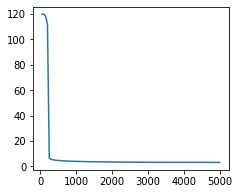

In [187]:
fig, ax = plt.subplots(figsize=(3.5,3))
ax.plot(mc_tsne_60__it_div_arr[:,0], mc_tsne_60__it_div_arr[:,1])
plt.show()

In [188]:
# RECOVERY FROM THE FAILURE
# multicore_tsne_learning_data_60_rfecv_columns_divergences = multicore_tsne_on_learning_data_60_rfecv_columns.kl_divergence_

# if dump_tsne_model: 
# #         print(multicore_tsne_on_learning_data_60_rfecv_columns_pathname)
# #         joblib.dump(multicore_tsne_on_learning_data_60_rfecv_columns, 
# #                     multicore_tsne_on_learning_data_60_rfecv_columns_pathname, compress=1)
#     print(learning_data__X__multicore_tsne_learning_data_60_rfecv_columns_pathname)
#     np.save(
#         learning_data__X__multicore_tsne_learning_data_60_rfecv_columns_pathname,
#         learning_data__X__multicore_tsne_learning_data_60_rfecv_columns)

#     print(multicore_tsne_learning_data_60_rfecv_columns_divergences_pathname)
#     np.save(
#         multicore_tsne_learning_data_60_rfecv_columns_divergences_pathname,
#         multicore_tsne_learning_data_60_rfecv_columns_divergences)

#     print(multicore_tsne_on_learning_data_60_rfecv_columns_scaler_pathname)
#     joblib.dump(multicore_tsne_on_learning_data_60_rfecv_columns_scaler, 
#                 multicore_tsne_on_learning_data_60_rfecv_columns_scaler_pathname, compress=1)

### All features

In [189]:
standard_scaler_all_rfecv_feat_all_data = sklearn.preprocessing.StandardScaler()
# learning_data__rfecv_var_th_X = \
learning_data__scaled_rfecv_var_th_X = \
    standard_scaler_all_rfecv_feat_all_data.fit_transform(
        rfecv_selector_on_randomforest_cls.transform(
            var_th_selector_on_train.transform(learning_data__X)
        )
    )
# removed:
# .T[rfecv_selector_on_randomforest__column_indices__sorted[0:60]].T 

In [190]:
learning_data__scaled_rfecv_var_th_X.shape

(69042, 83)

In [191]:
multicore_tsne_n_jobs = 10
multicore_tsne_learning_rate = 100
multicore_tsne_n_iter = 10000

multicore_tsne_on_learning_data_all_rfecv_column_names_hexdigest = hashlib.md5((','.join(rfecv_selector_on_randomforest__column_names__sorted[0:60])).encode()).hexdigest()

# multicore_tsne_on_learning_data_all_rfecv_columns_pathname = \
#     os.path.join(data_snippets_dir, 'multicore_tsne_on_learning_data_all_rfecv_columns_{}.pkl'.format(   # should be renamed
#         multicore_tsne_on_learning_data_all_rfecv_column_names_hexdigest))

learning_data__X__multicore_tsne_learning_data_all_rfecv_columns_pathname = \
    os.path.join(data_snippets_dir, 'learning_data__X__multicore_tsne_learning_data_all_rfecv_columns_{}.npy'.format(   # should be renamed
        multicore_tsne_on_learning_data_all_rfecv_column_names_hexdigest))

multicore_tsne_learning_data_all_rfecv_columns_divergences_pathname = \
    os.path.join(data_snippets_dir, 'multicore_tsne_learning_data_all_rfecv_columns_{}_divergences.npy'.format(   # should be renamed
        multicore_tsne_on_learning_data_all_rfecv_column_names_hexdigest))

multicore_tsne_on_learning_data_all_rfecv_columns_scaler_pathname = \
    os.path.join(data_snippets_dir, 'multicore_tsne_on_learning_data_all_rfecv_columns_{}_scaler.pkl'.format(
        multicore_tsne_on_learning_data_all_rfecv_column_names_hexdigest))

if refit_tsne_model or not os.path.exists(learning_data__X__multicore_tsne_learning_data_all_rfecv_columns_pathname):
    multicore_tsne_on_learning_data_all_rfecv_columns = MulticoreTSNE.MulticoreTSNE(
        n_jobs=multicore_tsne_n_jobs,
        learning_rate=multicore_tsne_learning_rate, verbose=10, n_iter=multicore_tsne_n_iter)
    multicore_tsne_on_learning_data_all_rfecv_columns_scaler = sklearn.preprocessing.StandardScaler()
    
    learning_data__X__multicore_tsne_learning_data_all_rfecv_columns = \
        multicore_tsne_on_learning_data_all_rfecv_columns.fit_transform(
            learning_data__scaled_rfecv_var_th_X
        )
    
    multicore_tsne_learning_data_all_rfecv_columns_divergences = multicore_tsne_on_learning_data_all_rfecv_columns.kl_divergence_
    
    if dump_tsne_model: 
#         print(multicore_tsne_on_learning_data_all_rfecv_columns_pathname)
#         joblib.dump(multicore_tsne_on_learning_data_all_rfecv_columns, 
#                     multicore_tsne_on_learning_data_all_rfecv_columns_pathname, compress=1)
        print(learning_data__X__multicore_tsne_learning_data_all_rfecv_columns_pathname)
        np.save(
            learning_data__X__multicore_tsne_learning_data_all_rfecv_columns_pathname,
            learning_data__X__multicore_tsne_learning_data_all_rfecv_columns)
        
        print(multicore_tsne_learning_data_all_rfecv_columns_divergences_pathname)
        np.save(
            multicore_tsne_learning_data_all_rfecv_columns_divergences_pathname,
            multicore_tsne_learning_data_all_rfecv_columns_divergences)
        
        print(multicore_tsne_on_learning_data_all_rfecv_columns_scaler_pathname)
        joblib.dump(multicore_tsne_on_learning_data_all_rfecv_columns_scaler, 
                    multicore_tsne_on_learning_data_all_rfecv_columns_scaler_pathname, compress=1)

else:    
#     if load_existing_scalers_for_tsne:
#         multicore_tsne_on_learning_data_all_rfecv_columns_scaler = joblib.load(multicore_tsne_on_learning_data_all_rfecv_columns_scaler_pathname)

#     multicore_tsne_on_learning_data_all_rfecv_columns = joblib.load(multicore_tsne_on_learning_data_all_rfecv_columns_pathname)
#     learning_data__X__multicore_tsne_learning_data_all_rfecv_columns = \
#         multicore_tsne_on_learning_data_all_rfecv_columns.embedding_
    
    learning_data__X__multicore_tsne_learning_data_all_rfecv_columns = \
        np.load(learning_data__X__multicore_tsne_learning_data_all_rfecv_columns_pathname)

Performing t-SNE using 10 cores.
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 10000 of 69042
 - point 20000 of 69042
 - point 30000 of 69042
 - point 40000 of 69042
 - point 50000 of 69042
 - point 60000 of 69042
Done in 4.00 seconds (sparsity = 0.001946)!
Learning embedding...
Iteration 51: error is 119.588530 (50 iterations in 6.00 seconds)
Iteration 101: error is 119.346921 (50 iterations in 6.00 seconds)
Iteration 151: error is 116.243880 (50 iterations in 6.00 seconds)
Iteration 201: error is 110.822622 (50 iterations in 6.00 seconds)
Iteration 251: error is 6.505198 (50 iterations in 6.00 seconds)
Iteration 301: error is 5.535066 (50 iterations in 5.00 seconds)
Iteration 351: error is 5.167685 (50 iterations in 5.00 seconds)
Iteration 401: error is 4.942134 (50 iterations in 5.00 seconds)
Iteration 451: error is 4.776052 (50 iterations in 5.00 seconds)
Iteration 501: error is 4.642188 (50 iterations in 5

Iteration 6001: error is 3.149921 (50 iterations in 6.00 seconds)
Iteration 6051: error is 3.149066 (50 iterations in 6.00 seconds)
Iteration 6101: error is 3.148227 (50 iterations in 6.00 seconds)
Iteration 6151: error is 3.147631 (50 iterations in 7.00 seconds)
Iteration 6201: error is 3.147021 (50 iterations in 6.00 seconds)
Iteration 6251: error is 3.146434 (50 iterations in 6.00 seconds)
Iteration 6301: error is 3.145924 (50 iterations in 6.00 seconds)
Iteration 6351: error is 3.145535 (50 iterations in 6.00 seconds)
Iteration 6401: error is 3.144940 (50 iterations in 6.00 seconds)
Iteration 6451: error is 3.144308 (50 iterations in 6.00 seconds)
Iteration 6501: error is 3.143823 (50 iterations in 6.00 seconds)
Iteration 6551: error is 3.143327 (50 iterations in 6.00 seconds)
Iteration 6601: error is 3.142686 (50 iterations in 7.00 seconds)
Iteration 6651: error is 3.142117 (50 iterations in 6.00 seconds)
Iteration 6701: error is 3.141731 (50 iterations in 7.00 seconds)
Iteration 

ver4_machine_learning_w_labeled_flight_20200415_2_randomforest_dimensionality_reduction/learning_data__X__multicore_tsne_learning_data_all_rfecv_columns_177d56bb570fc55b8bb3b008948946b0.npy
ver4_machine_learning_w_labeled_flight_20200415_2_randomforest_dimensionality_reduction/multicore_tsne_learning_data_all_rfecv_columns_177d56bb570fc55b8bb3b008948946b0_divergences.npy
ver4_machine_learning_w_labeled_flight_20200415_2_randomforest_dimensionality_reduction/multicore_tsne_on_learning_data_all_rfecv_columns_177d56bb570fc55b8bb3b008948946b0_scaler.pkl


Fitting performed in 1193.00 seconds.


##### Fit output

```
Performing t-SNE using 10 cores.
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 10000 of 69042
 - point 20000 of 69042
 - point 30000 of 69042
 - point 40000 of 69042
 - point 50000 of 69042
 - point 60000 of 69042
Done in 9.00 seconds (sparsity = 0.001967)!
Learning embedding...
Iteration 51: error is 119.181201 (50 iterations in 6.00 seconds)
Iteration 101: error is 119.013574 (50 iterations in 6.00 seconds)
Iteration 151: error is 115.921607 (50 iterations in 7.00 seconds)
Iteration 201: error is 110.738711 (50 iterations in 6.00 seconds)
Iteration 251: error is 6.461378 (50 iterations in 6.00 seconds)
Iteration 301: error is 5.501053 (50 iterations in 6.00 seconds)
Iteration 351: error is 5.106522 (50 iterations in 6.00 seconds)
Iteration 401: error is 4.863593 (50 iterations in 7.00 seconds)
Iteration 451: error is 4.685830 (50 iterations in 6.00 seconds)
Iteration 501: error is 4.544255 (50 iterations in 6.00 seconds)
Iteration 551: error is 4.425673 (50 iterations in 6.00 seconds)
Iteration 601: error is 4.323786 (50 iterations in 7.00 seconds)
Iteration 651: error is 4.234571 (50 iterations in 7.00 seconds)
Iteration 701: error is 4.155692 (50 iterations in 7.00 seconds)
Iteration 751: error is 4.084733 (50 iterations in 8.00 seconds)
Iteration 801: error is 4.020404 (50 iterations in 7.00 seconds)
Iteration 851: error is 3.961932 (50 iterations in 7.00 seconds)
Iteration 901: error is 3.908255 (50 iterations in 7.00 seconds)
Iteration 951: error is 3.858908 (50 iterations in 7.00 seconds)
Iteration 1001: error is 3.813187 (50 iterations in 8.00 seconds)
Iteration 1051: error is 3.770956 (50 iterations in 8.00 seconds)
Iteration 1101: error is 3.731881 (50 iterations in 8.00 seconds)
Iteration 1151: error is 3.695516 (50 iterations in 8.00 seconds)
Iteration 1201: error is 3.661447 (50 iterations in 7.00 seconds)
Iteration 1251: error is 3.629453 (50 iterations in 7.00 seconds)
Iteration 1301: error is 3.599251 (50 iterations in 7.00 seconds)
Iteration 1351: error is 3.570588 (50 iterations in 8.00 seconds)
Iteration 1401: error is 3.543409 (50 iterations in 8.00 seconds)
Iteration 1451: error is 3.517552 (50 iterations in 8.00 seconds)
Iteration 1501: error is 3.492968 (50 iterations in 8.00 seconds)
Iteration 1551: error is 3.469580 (50 iterations in 8.00 seconds)
Iteration 1601: error is 3.447327 (50 iterations in 8.00 seconds)
Iteration 1651: error is 3.426074 (50 iterations in 7.00 seconds)
Iteration 1701: error is 3.405631 (50 iterations in 8.00 seconds)
Iteration 1751: error is 3.385984 (50 iterations in 8.00 seconds)
Iteration 1801: error is 3.367236 (50 iterations in 8.00 seconds)
Iteration 1851: error is 3.349260 (50 iterations in 8.00 seconds)
Iteration 1901: error is 3.332115 (50 iterations in 9.00 seconds)
Iteration 1951: error is 3.315757 (50 iterations in 8.00 seconds)
Iteration 2001: error is 3.299956 (50 iterations in 8.00 seconds)
Iteration 2051: error is 3.284764 (50 iterations in 8.00 seconds)
Iteration 2101: error is 3.270049 (50 iterations in 8.00 seconds)
Iteration 2151: error is 3.255823 (50 iterations in 8.00 seconds)
Iteration 2201: error is 3.242061 (50 iterations in 8.00 seconds)
Iteration 2251: error is 3.228844 (50 iterations in 9.00 seconds)
Iteration 2301: error is 3.216221 (50 iterations in 8.00 seconds)
Iteration 2351: error is 3.204149 (50 iterations in 8.00 seconds)
Iteration 2401: error is 3.192482 (50 iterations in 9.00 seconds)
Iteration 2451: error is 3.181380 (50 iterations in 8.00 seconds)
Iteration 2501: error is 3.170747 (50 iterations in 8.00 seconds)
Iteration 2551: error is 3.160504 (50 iterations in 9.00 seconds)
Iteration 2601: error is 3.150484 (50 iterations in 8.00 seconds)
Iteration 2651: error is 3.140834 (50 iterations in 8.00 seconds)
Iteration 2701: error is 3.131376 (50 iterations in 8.00 seconds)
Iteration 2751: error is 3.122217 (50 iterations in 9.00 seconds)
Iteration 2801: error is 3.113328 (50 iterations in 8.00 seconds)
Iteration 2851: error is 3.104766 (50 iterations in 8.00 seconds)
Iteration 2901: error is 3.096426 (50 iterations in 9.00 seconds)
Iteration 2951: error is 3.088329 (50 iterations in 9.00 seconds)
Iteration 3001: error is 3.080548 (50 iterations in 9.00 seconds)
Iteration 3051: error is 3.073208 (50 iterations in 9.00 seconds)
Iteration 3101: error is 3.066168 (50 iterations in 8.00 seconds)
Iteration 3151: error is 3.059425 (50 iterations in 8.00 seconds)
Iteration 3201: error is 3.052910 (50 iterations in 8.00 seconds)
Iteration 3251: error is 3.046708 (50 iterations in 9.00 seconds)
Iteration 3301: error is 3.040755 (50 iterations in 9.00 seconds)
Iteration 3351: error is 3.035048 (50 iterations in 9.00 seconds)
Iteration 3401: error is 3.029479 (50 iterations in 9.00 seconds)
Iteration 3451: error is 3.024076 (50 iterations in 9.00 seconds)
Iteration 3501: error is 3.018824 (50 iterations in 9.00 seconds)
Iteration 3551: error is 3.013843 (50 iterations in 9.00 seconds)
Iteration 3601: error is 3.009244 (50 iterations in 9.00 seconds)
Iteration 3651: error is 3.005112 (50 iterations in 9.00 seconds)
Iteration 3701: error is 3.001378 (50 iterations in 8.00 seconds)
Iteration 3751: error is 2.998099 (50 iterations in 8.00 seconds)
Iteration 3801: error is 2.995157 (50 iterations in 8.00 seconds)
Iteration 3851: error is 2.992599 (50 iterations in 8.00 seconds)
Iteration 3901: error is 2.990254 (50 iterations in 9.00 seconds)
Iteration 3951: error is 2.988210 (50 iterations in 9.00 seconds)
Iteration 4001: error is 2.986358 (50 iterations in 9.00 seconds)
Iteration 4051: error is 2.984810 (50 iterations in 9.00 seconds)
Iteration 4101: error is 2.983370 (50 iterations in 9.00 seconds)
Iteration 4151: error is 2.982000 (50 iterations in 9.00 seconds)
Iteration 4201: error is 2.980831 (50 iterations in 9.00 seconds)
Iteration 4251: error is 2.979730 (50 iterations in 9.00 seconds)
Iteration 4301: error is 2.978679 (50 iterations in 9.00 seconds)
Iteration 4351: error is 2.977659 (50 iterations in 9.00 seconds)
Iteration 4401: error is 2.976643 (50 iterations in 9.00 seconds)
Iteration 4451: error is 2.975680 (50 iterations in 9.00 seconds)
Iteration 4501: error is 2.974753 (50 iterations in 10.00 seconds)
Iteration 4551: error is 2.973523 (50 iterations in 9.00 seconds)
Iteration 4601: error is 2.972695 (50 iterations in 9.00 seconds)
Iteration 4651: error is 2.971870 (50 iterations in 9.00 seconds)
Iteration 4701: error is 2.971086 (50 iterations in 10.00 seconds)
Iteration 4751: error is 2.970403 (50 iterations in 10.00 seconds)
Iteration 4801: error is 2.969615 (50 iterations in 10.00 seconds)
Iteration 4851: error is 2.968965 (50 iterations in 10.00 seconds)
Iteration 4901: error is 2.968312 (50 iterations in 10.00 seconds)
Iteration 4951: error is 2.967611 (50 iterations in 9.00 seconds)
Iteration 5001: error is 2.966827 (50 iterations in 9.00 seconds)
Iteration 5051: error is 2.965952 (50 iterations in 9.00 seconds)
Iteration 5101: error is 2.965178 (50 iterations in 10.00 seconds)
Iteration 5151: error is 2.964384 (50 iterations in 10.00 seconds)
Iteration 5201: error is 2.963628 (50 iterations in 10.00 seconds)
Iteration 5251: error is 2.962829 (50 iterations in 10.00 seconds)
Iteration 5301: error is 2.962008 (50 iterations in 10.00 seconds)
Iteration 5351: error is 2.961211 (50 iterations in 9.00 seconds)
Iteration 5401: error is 2.960348 (50 iterations in 9.00 seconds)
Iteration 5451: error is 2.959446 (50 iterations in 10.00 seconds)
Iteration 5501: error is 2.958556 (50 iterations in 10.00 seconds)
Iteration 5551: error is 2.957646 (50 iterations in 10.00 seconds)
Iteration 5601: error is 2.956759 (50 iterations in 10.00 seconds)
Iteration 5651: error is 2.955860 (50 iterations in 10.00 seconds)
Iteration 5701: error is 2.954918 (50 iterations in 9.00 seconds)
Iteration 5751: error is 2.953926 (50 iterations in 9.00 seconds)
Iteration 5801: error is 2.952918 (50 iterations in 10.00 seconds)
Iteration 5851: error is 2.951915 (50 iterations in 10.00 seconds)
Iteration 5901: error is 2.950880 (50 iterations in 10.00 seconds)
Iteration 5951: error is 2.949873 (50 iterations in 9.00 seconds)
Iteration 6001: error is 2.948845 (50 iterations in 10.00 seconds)
Iteration 6051: error is 2.947826 (50 iterations in 10.00 seconds)
Iteration 6101: error is 2.946806 (50 iterations in 10.00 seconds)
Iteration 6151: error is 2.945810 (50 iterations in 9.00 seconds)
Iteration 6201: error is 2.944786 (50 iterations in 9.00 seconds)
Iteration 6251: error is 2.943733 (50 iterations in 10.00 seconds)
Iteration 6301: error is 2.942668 (50 iterations in 10.00 seconds)
Iteration 6351: error is 2.941615 (50 iterations in 10.00 seconds)
Iteration 6401: error is 2.940551 (50 iterations in 10.00 seconds)
Iteration 6451: error is 2.939491 (50 iterations in 10.00 seconds)
Iteration 6501: error is 2.938354 (50 iterations in 9.00 seconds)
Iteration 6551: error is 2.937227 (50 iterations in 10.00 seconds)
Iteration 6601: error is 2.936112 (50 iterations in 10.00 seconds)
Iteration 6651: error is 2.934965 (50 iterations in 10.00 seconds)
Iteration 6701: error is 2.933818 (50 iterations in 10.00 seconds)
Iteration 6751: error is 2.932635 (50 iterations in 10.00 seconds)
Iteration 6801: error is 2.931493 (50 iterations in 10.00 seconds)
Iteration 6851: error is 2.930262 (50 iterations in 9.00 seconds)
Iteration 6901: error is 2.929013 (50 iterations in 9.00 seconds)
Iteration 6951: error is 2.927795 (50 iterations in 9.00 seconds)
Iteration 7001: error is 2.926564 (50 iterations in 9.00 seconds)
Iteration 7051: error is 2.925355 (50 iterations in 9.00 seconds)
Iteration 7101: error is 2.924124 (50 iterations in 10.00 seconds)
Iteration 7151: error is 2.922874 (50 iterations in 10.00 seconds)
Iteration 7201: error is 2.921696 (50 iterations in 10.00 seconds)
Iteration 7251: error is 2.920538 (50 iterations in 10.00 seconds)
Iteration 7301: error is 2.919387 (50 iterations in 10.00 seconds)
Iteration 7351: error is 2.918251 (50 iterations in 10.00 seconds)
Iteration 7401: error is 2.917108 (50 iterations in 10.00 seconds)
Iteration 7451: error is 2.915955 (50 iterations in 10.00 seconds)
Iteration 7501: error is 2.914808 (50 iterations in 10.00 seconds)
Iteration 7551: error is 2.913714 (50 iterations in 10.00 seconds)
Iteration 7601: error is 2.912588 (50 iterations in 10.00 seconds)
Iteration 7651: error is 2.911511 (50 iterations in 10.00 seconds)
Iteration 7701: error is 2.910499 (50 iterations in 10.00 seconds)
Iteration 7751: error is 2.909541 (50 iterations in 10.00 seconds)
Iteration 7801: error is 2.908628 (50 iterations in 10.00 seconds)
Iteration 7851: error is 2.907686 (50 iterations in 10.00 seconds)
Iteration 7901: error is 2.906723 (50 iterations in 10.00 seconds)
Iteration 7951: error is 2.905722 (50 iterations in 10.00 seconds)
Iteration 8001: error is 2.904754 (50 iterations in 10.00 seconds)
Iteration 8051: error is 2.903765 (50 iterations in 10.00 seconds)
Iteration 8101: error is 2.902835 (50 iterations in 10.00 seconds)
Iteration 8151: error is 2.901873 (50 iterations in 10.00 seconds)
Iteration 8201: error is 2.900916 (50 iterations in 10.00 seconds)
Iteration 8251: error is 2.899960 (50 iterations in 10.00 seconds)
Iteration 8301: error is 2.898974 (50 iterations in 9.00 seconds)
Iteration 8351: error is 2.898010 (50 iterations in 9.00 seconds)
Iteration 8401: error is 2.896989 (50 iterations in 9.00 seconds)
Iteration 8451: error is 2.895927 (50 iterations in 9.00 seconds)
Iteration 8501: error is 2.894930 (50 iterations in 9.00 seconds)
Iteration 8551: error is 2.893843 (50 iterations in 9.00 seconds)
Iteration 8601: error is 2.892750 (50 iterations in 10.00 seconds)
Iteration 8651: error is 2.891658 (50 iterations in 10.00 seconds)
Iteration 8701: error is 2.890567 (50 iterations in 9.00 seconds)
Iteration 8751: error is 2.889468 (50 iterations in 9.00 seconds)
Iteration 8801: error is 2.888372 (50 iterations in 9.00 seconds)
Iteration 8851: error is 2.887277 (50 iterations in 10.00 seconds)
Iteration 8901: error is 2.886294 (50 iterations in 10.00 seconds)
Iteration 8951: error is 2.885294 (50 iterations in 9.00 seconds)
Iteration 9001: error is 2.884325 (50 iterations in 9.00 seconds)
Iteration 9051: error is 2.883424 (50 iterations in 10.00 seconds)
Iteration 9101: error is 2.882610 (50 iterations in 10.00 seconds)
Iteration 9151: error is 2.881854 (50 iterations in 10.00 seconds)
Iteration 9201: error is 2.881180 (50 iterations in 9.00 seconds)
Iteration 9251: error is 2.880499 (50 iterations in 9.00 seconds)
Iteration 9301: error is 2.879849 (50 iterations in 10.00 seconds)
Iteration 9351: error is 2.879180 (50 iterations in 9.00 seconds)
Iteration 9401: error is 2.878545 (50 iterations in 9.00 seconds)
Iteration 9451: error is 2.877938 (50 iterations in 9.00 seconds)
Iteration 9501: error is 2.877257 (50 iterations in 9.00 seconds)
Iteration 9551: error is 2.876622 (50 iterations in 9.00 seconds)
Iteration 9601: error is 2.876049 (50 iterations in 9.00 seconds)
Iteration 9651: error is 2.875513 (50 iterations in 9.00 seconds)
Iteration 9701: error is 2.874959 (50 iterations in 9.00 seconds)
Iteration 9751: error is 2.874462 (50 iterations in 9.00 seconds)
Iteration 9801: error is 2.873959 (50 iterations in 9.00 seconds)
Iteration 9851: error is 2.873487 (50 iterations in 9.00 seconds)
Iteration 9901: error is 2.872999 (50 iterations in 9.00 seconds)
Iteration 9951: error is 2.872499 (50 iterations in 9.00 seconds)
Iteration 10001: error is 2.872034 (50 iterations in 8.00 seconds)
Iteration 10051: error is 2.871533 (50 iterations in 9.00 seconds)
Iteration 10101: error is 2.871066 (50 iterations in 9.00 seconds)
Iteration 10151: error is 2.870580 (50 iterations in 9.00 seconds)
Iteration 10201: error is 2.870085 (50 iterations in 9.00 seconds)
Iteration 10251: error is 2.869629 (50 iterations in 9.00 seconds)
Iteration 10301: error is 2.869140 (50 iterations in 8.00 seconds)
Iteration 10351: error is 2.868612 (50 iterations in 9.00 seconds)
Iteration 10401: error is 2.868096 (50 iterations in 9.00 seconds)
Iteration 10451: error is 2.867636 (50 iterations in 9.00 seconds)
Iteration 10501: error is 2.867155 (50 iterations in 9.00 seconds)
Iteration 10551: error is 2.866662 (50 iterations in 9.00 seconds)
Iteration 10601: error is 2.866148 (50 iterations in 9.00 seconds)
Iteration 10651: error is 2.865682 (50 iterations in 9.00 seconds)
Iteration 10701: error is 2.865156 (50 iterations in 9.00 seconds)
Iteration 10751: error is 2.864688 (50 iterations in 9.00 seconds)
Iteration 10801: error is 2.864183 (50 iterations in 8.00 seconds)
Iteration 10851: error is 2.863648 (50 iterations in 8.00 seconds)
Iteration 10901: error is 2.863172 (50 iterations in 8.00 seconds)
Iteration 10951: error is 2.862653 (50 iterations in 8.00 seconds)
Iteration 11001: error is 2.862125 (50 iterations in 9.00 seconds)
Iteration 11051: error is 2.861523 (50 iterations in 9.00 seconds)
Iteration 11101: error is 2.860975 (50 iterations in 9.00 seconds)
Iteration 11151: error is 2.860475 (50 iterations in 8.00 seconds)
Iteration 11201: error is 2.859944 (50 iterations in 8.00 seconds)
Iteration 11251: error is 2.859433 (50 iterations in 8.00 seconds)
Iteration 11301: error is 2.858958 (50 iterations in 9.00 seconds)
Iteration 11351: error is 2.858475 (50 iterations in 9.00 seconds)
Iteration 11401: error is 2.857970 (50 iterations in 8.00 seconds)
Iteration 11451: error is 2.857473 (50 iterations in 8.00 seconds)
Iteration 11501: error is 2.856926 (50 iterations in 8.00 seconds)
Iteration 11551: error is 2.856386 (50 iterations in 9.00 seconds)
Iteration 11601: error is 2.855814 (50 iterations in 8.00 seconds)
Iteration 11651: error is 2.855271 (50 iterations in 8.00 seconds)
Iteration 11701: error is 2.854653 (50 iterations in 8.00 seconds)
Iteration 11751: error is 2.854036 (50 iterations in 9.00 seconds)
Iteration 11801: error is 2.853489 (50 iterations in 9.00 seconds)
Iteration 11851: error is 2.852859 (50 iterations in 8.00 seconds)
Iteration 11901: error is 2.852288 (50 iterations in 8.00 seconds)
Iteration 11951: error is 2.851669 (50 iterations in 9.00 seconds)
Iteration 12001: error is 2.851066 (50 iterations in 8.00 seconds)
Iteration 12051: error is 2.850523 (50 iterations in 8.00 seconds)
Iteration 12101: error is 2.849914 (50 iterations in 8.00 seconds)
Iteration 12151: error is 2.849345 (50 iterations in 9.00 seconds)
Iteration 12201: error is 2.848794 (50 iterations in 8.00 seconds)
Iteration 12251: error is 2.848282 (50 iterations in 8.00 seconds)
Iteration 12301: error is 2.847704 (50 iterations in 8.00 seconds)
Iteration 12351: error is 2.847130 (50 iterations in 9.00 seconds)
Iteration 12401: error is 2.846551 (50 iterations in 8.00 seconds)
Iteration 12451: error is 2.846017 (50 iterations in 8.00 seconds)
Iteration 12501: error is 2.845454 (50 iterations in 9.00 seconds)
Iteration 12551: error is 2.844864 (50 iterations in 8.00 seconds)
Iteration 12601: error is 2.844289 (50 iterations in 8.00 seconds)
Iteration 12651: error is 2.843747 (50 iterations in 8.00 seconds)
Iteration 12701: error is 2.843191 (50 iterations in 9.00 seconds)
Iteration 12751: error is 2.842591 (50 iterations in 8.00 seconds)
Iteration 12801: error is 2.841986 (50 iterations in 8.00 seconds)
Iteration 12851: error is 2.841488 (50 iterations in 9.00 seconds)
Iteration 12901: error is 2.840907 (50 iterations in 8.00 seconds)
Iteration 12951: error is 2.840362 (50 iterations in 8.00 seconds)
Iteration 13001: error is 2.839814 (50 iterations in 9.00 seconds)
Iteration 13051: error is 2.839297 (50 iterations in 8.00 seconds)
Iteration 13101: error is 2.838768 (50 iterations in 8.00 seconds)
Iteration 13151: error is 2.838215 (50 iterations in 8.00 seconds)
Iteration 13201: error is 2.837639 (50 iterations in 8.00 seconds)
Iteration 13251: error is 2.837140 (50 iterations in 8.00 seconds)
Iteration 13301: error is 2.836618 (50 iterations in 9.00 seconds)
Iteration 13351: error is 2.836073 (50 iterations in 8.00 seconds)
Iteration 13401: error is 2.835559 (50 iterations in 8.00 seconds)
Iteration 13451: error is 2.835010 (50 iterations in 8.00 seconds)
Iteration 13501: error is 2.834531 (50 iterations in 8.00 seconds)
Iteration 13551: error is 2.833990 (50 iterations in 9.00 seconds)
Iteration 13601: error is 2.833442 (50 iterations in 8.00 seconds)
Iteration 13651: error is 2.832924 (50 iterations in 8.00 seconds)
Iteration 13701: error is 2.832422 (50 iterations in 8.00 seconds)
Iteration 13751: error is 2.831901 (50 iterations in 8.00 seconds)
Iteration 13801: error is 2.831348 (50 iterations in 8.00 seconds)
Iteration 13851: error is 2.830829 (50 iterations in 8.00 seconds)
Iteration 13901: error is 2.830304 (50 iterations in 8.00 seconds)
Iteration 13951: error is 2.829826 (50 iterations in 8.00 seconds)
Iteration 14001: error is 2.829256 (50 iterations in 8.00 seconds)
Iteration 14051: error is 2.828733 (50 iterations in 8.00 seconds)
Iteration 14101: error is 2.828241 (50 iterations in 8.00 seconds)
Iteration 14151: error is 2.827686 (50 iterations in 8.00 seconds)
Iteration 14201: error is 2.827169 (50 iterations in 8.00 seconds)
Iteration 14251: error is 2.826675 (50 iterations in 8.00 seconds)
Iteration 14301: error is 2.826108 (50 iterations in 8.00 seconds)
Iteration 14351: error is 2.825625 (50 iterations in 8.00 seconds)
Iteration 14401: error is 2.825119 (50 iterations in 8.00 seconds)
Iteration 14451: error is 2.824583 (50 iterations in 9.00 seconds)
Iteration 14501: error is 2.824097 (50 iterations in 8.00 seconds)
Iteration 14551: error is 2.823563 (50 iterations in 8.00 seconds)
Iteration 14601: error is 2.823072 (50 iterations in 8.00 seconds)
Iteration 14651: error is 2.822579 (50 iterations in 8.00 seconds)
Iteration 14701: error is 2.822078 (50 iterations in 8.00 seconds)
Iteration 14751: error is 2.821554 (50 iterations in 8.00 seconds)
Iteration 14801: error is 2.821068 (50 iterations in 8.00 seconds)
Iteration 14851: error is 2.820489 (50 iterations in 9.00 seconds)
Iteration 14901: error is 2.819996 (50 iterations in 8.00 seconds)
Iteration 14951: error is 2.819433 (50 iterations in 8.00 seconds)
Iteration 15001: error is 2.818905 (50 iterations in 8.00 seconds)
Iteration 15051: error is 2.818368 (50 iterations in 8.00 seconds)
Iteration 15101: error is 2.817809 (50 iterations in 8.00 seconds)
Iteration 15151: error is 2.817244 (50 iterations in 8.00 seconds)
Iteration 15201: error is 2.816730 (50 iterations in 8.00 seconds)
Iteration 15251: error is 2.816195 (50 iterations in 8.00 seconds)
Iteration 15301: error is 2.815701 (50 iterations in 8.00 seconds)
Iteration 15351: error is 2.815159 (50 iterations in 8.00 seconds)
Iteration 15401: error is 2.814620 (50 iterations in 8.00 seconds)
Iteration 15451: error is 2.814070 (50 iterations in 8.00 seconds)
Iteration 15501: error is 2.813611 (50 iterations in 8.00 seconds)
Iteration 15551: error is 2.813104 (50 iterations in 8.00 seconds)
Iteration 15601: error is 2.812609 (50 iterations in 8.00 seconds)
Iteration 15651: error is 2.812100 (50 iterations in 8.00 seconds)
Iteration 15701: error is 2.811594 (50 iterations in 8.00 seconds)
Iteration 15751: error is 2.811121 (50 iterations in 8.00 seconds)
Iteration 15801: error is 2.810673 (50 iterations in 8.00 seconds)
Iteration 15851: error is 2.810216 (50 iterations in 8.00 seconds)
Iteration 15901: error is 2.809695 (50 iterations in 9.00 seconds)
Iteration 15951: error is 2.809234 (50 iterations in 8.00 seconds)
Iteration 16001: error is 2.808716 (50 iterations in 8.00 seconds)
Iteration 16051: error is 2.808236 (50 iterations in 8.00 seconds)
Iteration 16101: error is 2.807734 (50 iterations in 8.00 seconds)
Iteration 16151: error is 2.807226 (50 iterations in 7.00 seconds)
Iteration 16201: error is 2.806697 (50 iterations in 8.00 seconds)
Iteration 16251: error is 2.806160 (50 iterations in 8.00 seconds)
Iteration 16301: error is 2.805657 (50 iterations in 8.00 seconds)
Iteration 16351: error is 2.805168 (50 iterations in 8.00 seconds)
Iteration 16401: error is 2.804652 (50 iterations in 8.00 seconds)
Iteration 16451: error is 2.804125 (50 iterations in 8.00 seconds)
Iteration 16501: error is 2.803631 (50 iterations in 7.00 seconds)
Iteration 16551: error is 2.803156 (50 iterations in 8.00 seconds)
Iteration 16601: error is 2.802657 (50 iterations in 8.00 seconds)
Iteration 16651: error is 2.802162 (50 iterations in 8.00 seconds)
Iteration 16701: error is 2.801695 (50 iterations in 8.00 seconds)
Iteration 16751: error is 2.801216 (50 iterations in 8.00 seconds)
Iteration 16801: error is 2.800742 (50 iterations in 8.00 seconds)
Iteration 16851: error is 2.800236 (50 iterations in 7.00 seconds)
Iteration 16901: error is 2.799761 (50 iterations in 8.00 seconds)
Iteration 16951: error is 2.799288 (50 iterations in 8.00 seconds)
Iteration 17001: error is 2.798862 (50 iterations in 8.00 seconds)
Iteration 17051: error is 2.798426 (50 iterations in 8.00 seconds)
Iteration 17101: error is 2.798012 (50 iterations in 8.00 seconds)
Iteration 17151: error is 2.797572 (50 iterations in 8.00 seconds)
Iteration 17201: error is 2.797143 (50 iterations in 8.00 seconds)
Iteration 17251: error is 2.796763 (50 iterations in 8.00 seconds)
Iteration 17301: error is 2.796334 (50 iterations in 8.00 seconds)
Iteration 17351: error is 2.795937 (50 iterations in 8.00 seconds)
Iteration 17401: error is 2.795550 (50 iterations in 8.00 seconds)
Iteration 17451: error is 2.795164 (50 iterations in 8.00 seconds)
Iteration 17501: error is 2.794789 (50 iterations in 7.00 seconds)
Iteration 17551: error is 2.794370 (50 iterations in 8.00 seconds)
Iteration 17601: error is 2.794004 (50 iterations in 8.00 seconds)
Iteration 17651: error is 2.793634 (50 iterations in 8.00 seconds)
Iteration 17701: error is 2.793232 (50 iterations in 8.00 seconds)
Iteration 17751: error is 2.792854 (50 iterations in 8.00 seconds)
Iteration 17801: error is 2.792476 (50 iterations in 8.00 seconds)
Iteration 17851: error is 2.792119 (50 iterations in 7.00 seconds)
Iteration 17901: error is 2.791751 (50 iterations in 8.00 seconds)
Iteration 17951: error is 2.791414 (50 iterations in 8.00 seconds)
Iteration 18001: error is 2.791060 (50 iterations in 8.00 seconds)
Iteration 18051: error is 2.790718 (50 iterations in 7.00 seconds)
Iteration 18101: error is 2.790372 (50 iterations in 8.00 seconds)
Iteration 18151: error is 2.790001 (50 iterations in 8.00 seconds)
Iteration 18201: error is 2.789619 (50 iterations in 8.00 seconds)
Iteration 18251: error is 2.789224 (50 iterations in 8.00 seconds)
Iteration 18301: error is 2.788849 (50 iterations in 7.00 seconds)
Iteration 18351: error is 2.788493 (50 iterations in 8.00 seconds)
Iteration 18401: error is 2.788121 (50 iterations in 8.00 seconds)
Iteration 18451: error is 2.787761 (50 iterations in 8.00 seconds)
Iteration 18501: error is 2.787402 (50 iterations in 7.00 seconds)
Iteration 18551: error is 2.786979 (50 iterations in 8.00 seconds)
Iteration 18601: error is 2.786593 (50 iterations in 8.00 seconds)
Iteration 18651: error is 2.786231 (50 iterations in 8.00 seconds)
Iteration 18701: error is 2.785846 (50 iterations in 8.00 seconds)
Iteration 18751: error is 2.785485 (50 iterations in 8.00 seconds)
Iteration 18801: error is 2.785114 (50 iterations in 8.00 seconds)
Iteration 18851: error is 2.784767 (50 iterations in 7.00 seconds)
Iteration 18901: error is 2.784401 (50 iterations in 8.00 seconds)
Iteration 18951: error is 2.784075 (50 iterations in 8.00 seconds)
Iteration 19001: error is 2.783700 (50 iterations in 8.00 seconds)
Iteration 19051: error is 2.783342 (50 iterations in 8.00 seconds)
Iteration 19101: error is 2.782930 (50 iterations in 7.00 seconds)
Iteration 19151: error is 2.782563 (50 iterations in 7.00 seconds)
Iteration 19201: error is 2.782231 (50 iterations in 8.00 seconds)
Iteration 19251: error is 2.781856 (50 iterations in 8.00 seconds)
Iteration 19301: error is 2.781510 (50 iterations in 8.00 seconds)
Iteration 19351: error is 2.781124 (50 iterations in 8.00 seconds)
Iteration 19401: error is 2.780763 (50 iterations in 7.00 seconds)
Iteration 19451: error is 2.780413 (50 iterations in 7.00 seconds)
Iteration 19501: error is 2.780046 (50 iterations in 8.00 seconds)
Iteration 19551: error is 2.779701 (50 iterations in 8.00 seconds)
Iteration 19601: error is 2.779325 (50 iterations in 8.00 seconds)
Iteration 19651: error is 2.779007 (50 iterations in 8.00 seconds)
Iteration 19701: error is 2.778712 (50 iterations in 7.00 seconds)
Iteration 19751: error is 2.778388 (50 iterations in 8.00 seconds)
Iteration 19801: error is 2.778071 (50 iterations in 8.00 seconds)
Iteration 19851: error is 2.777720 (50 iterations in 8.00 seconds)
Iteration 19901: error is 2.777405 (50 iterations in 8.00 seconds)
Iteration 19951: error is 2.777071 (50 iterations in 7.00 seconds)
Iteration 20000: error is 2.776811 (50 iterations in 7.00 seconds)
ver4_machine_learning_w_labeled_flight_20200415_2_randomforest_dimensionality_reduction/learning_data__X__multicore_tsne_learning_data_all_rfecv_columns_d40f7b36036c6dc8bc84a51f98340726.npy
ver4_machine_learning_w_labeled_flight_20200415_2_randomforest_dimensionality_reduction/multicore_tsne_learning_data_all_rfecv_columns_d40f7b36036c6dc8bc84a51f98340726_divergences.npy
ver4_machine_learning_w_labeled_flight_20200415_2_randomforest_dimensionality_reduction/multicore_tsne_on_learning_data_all_rfecv_columns_d40f7b36036c6dc8bc84a51f98340726_scaler.pkl
Fitting performed in 3392.00 seconds.
```

In [ ]:
multicore_tsne_learning_data_all_rfecv_out = '''
Iteration 51: error is 119.181201 (50 iterations in 6.00 seconds)
Iteration 101: error is 119.013574 (50 iterations in 6.00 seconds)
Iteration 151: error is 115.921607 (50 iterations in 7.00 seconds)
Iteration 201: error is 110.738711 (50 iterations in 6.00 seconds)
Iteration 251: error is 6.461378 (50 iterations in 6.00 seconds)
Iteration 301: error is 5.501053 (50 iterations in 6.00 seconds)
Iteration 351: error is 5.106522 (50 iterations in 6.00 seconds)
Iteration 401: error is 4.863593 (50 iterations in 7.00 seconds)
Iteration 451: error is 4.685830 (50 iterations in 6.00 seconds)
Iteration 501: error is 4.544255 (50 iterations in 6.00 seconds)
Iteration 551: error is 4.425673 (50 iterations in 6.00 seconds)
Iteration 601: error is 4.323786 (50 iterations in 7.00 seconds)
Iteration 651: error is 4.234571 (50 iterations in 7.00 seconds)
Iteration 701: error is 4.155692 (50 iterations in 7.00 seconds)
Iteration 751: error is 4.084733 (50 iterations in 8.00 seconds)
Iteration 801: error is 4.020404 (50 iterations in 7.00 seconds)
Iteration 851: error is 3.961932 (50 iterations in 7.00 seconds)
Iteration 901: error is 3.908255 (50 iterations in 7.00 seconds)
Iteration 951: error is 3.858908 (50 iterations in 7.00 seconds)
Iteration 1001: error is 3.813187 (50 iterations in 8.00 seconds)
Iteration 1051: error is 3.770956 (50 iterations in 8.00 seconds)
Iteration 1101: error is 3.731881 (50 iterations in 8.00 seconds)
Iteration 1151: error is 3.695516 (50 iterations in 8.00 seconds)
Iteration 1201: error is 3.661447 (50 iterations in 7.00 seconds)
Iteration 1251: error is 3.629453 (50 iterations in 7.00 seconds)
Iteration 1301: error is 3.599251 (50 iterations in 7.00 seconds)
Iteration 1351: error is 3.570588 (50 iterations in 8.00 seconds)
Iteration 1401: error is 3.543409 (50 iterations in 8.00 seconds)
Iteration 1451: error is 3.517552 (50 iterations in 8.00 seconds)
Iteration 1501: error is 3.492968 (50 iterations in 8.00 seconds)
Iteration 1551: error is 3.469580 (50 iterations in 8.00 seconds)
Iteration 1601: error is 3.447327 (50 iterations in 8.00 seconds)
Iteration 1651: error is 3.426074 (50 iterations in 7.00 seconds)
Iteration 1701: error is 3.405631 (50 iterations in 8.00 seconds)
Iteration 1751: error is 3.385984 (50 iterations in 8.00 seconds)
Iteration 1801: error is 3.367236 (50 iterations in 8.00 seconds)
Iteration 1851: error is 3.349260 (50 iterations in 8.00 seconds)
Iteration 1901: error is 3.332115 (50 iterations in 9.00 seconds)
Iteration 1951: error is 3.315757 (50 iterations in 8.00 seconds)
Iteration 2001: error is 3.299956 (50 iterations in 8.00 seconds)
Iteration 2051: error is 3.284764 (50 iterations in 8.00 seconds)
Iteration 2101: error is 3.270049 (50 iterations in 8.00 seconds)
Iteration 2151: error is 3.255823 (50 iterations in 8.00 seconds)
Iteration 2201: error is 3.242061 (50 iterations in 8.00 seconds)
Iteration 2251: error is 3.228844 (50 iterations in 9.00 seconds)
Iteration 2301: error is 3.216221 (50 iterations in 8.00 seconds)
Iteration 2351: error is 3.204149 (50 iterations in 8.00 seconds)
Iteration 2401: error is 3.192482 (50 iterations in 9.00 seconds)
Iteration 2451: error is 3.181380 (50 iterations in 8.00 seconds)
Iteration 2501: error is 3.170747 (50 iterations in 8.00 seconds)
Iteration 2551: error is 3.160504 (50 iterations in 9.00 seconds)
Iteration 2601: error is 3.150484 (50 iterations in 8.00 seconds)
Iteration 2651: error is 3.140834 (50 iterations in 8.00 seconds)
Iteration 2701: error is 3.131376 (50 iterations in 8.00 seconds)
Iteration 2751: error is 3.122217 (50 iterations in 9.00 seconds)
Iteration 2801: error is 3.113328 (50 iterations in 8.00 seconds)
Iteration 2851: error is 3.104766 (50 iterations in 8.00 seconds)
Iteration 2901: error is 3.096426 (50 iterations in 9.00 seconds)
Iteration 2951: error is 3.088329 (50 iterations in 9.00 seconds)
Iteration 3001: error is 3.080548 (50 iterations in 9.00 seconds)
Iteration 3051: error is 3.073208 (50 iterations in 9.00 seconds)
Iteration 3101: error is 3.066168 (50 iterations in 8.00 seconds)
Iteration 3151: error is 3.059425 (50 iterations in 8.00 seconds)
Iteration 3201: error is 3.052910 (50 iterations in 8.00 seconds)
Iteration 3251: error is 3.046708 (50 iterations in 9.00 seconds)
Iteration 3301: error is 3.040755 (50 iterations in 9.00 seconds)
Iteration 3351: error is 3.035048 (50 iterations in 9.00 seconds)
Iteration 3401: error is 3.029479 (50 iterations in 9.00 seconds)
Iteration 3451: error is 3.024076 (50 iterations in 9.00 seconds)
Iteration 3501: error is 3.018824 (50 iterations in 9.00 seconds)
Iteration 3551: error is 3.013843 (50 iterations in 9.00 seconds)
Iteration 3601: error is 3.009244 (50 iterations in 9.00 seconds)
Iteration 3651: error is 3.005112 (50 iterations in 9.00 seconds)
Iteration 3701: error is 3.001378 (50 iterations in 8.00 seconds)
Iteration 3751: error is 2.998099 (50 iterations in 8.00 seconds)
Iteration 3801: error is 2.995157 (50 iterations in 8.00 seconds)
Iteration 3851: error is 2.992599 (50 iterations in 8.00 seconds)
Iteration 3901: error is 2.990254 (50 iterations in 9.00 seconds)
Iteration 3951: error is 2.988210 (50 iterations in 9.00 seconds)
Iteration 4001: error is 2.986358 (50 iterations in 9.00 seconds)
Iteration 4051: error is 2.984810 (50 iterations in 9.00 seconds)
Iteration 4101: error is 2.983370 (50 iterations in 9.00 seconds)
Iteration 4151: error is 2.982000 (50 iterations in 9.00 seconds)
Iteration 4201: error is 2.980831 (50 iterations in 9.00 seconds)
Iteration 4251: error is 2.979730 (50 iterations in 9.00 seconds)
Iteration 4301: error is 2.978679 (50 iterations in 9.00 seconds)
Iteration 4351: error is 2.977659 (50 iterations in 9.00 seconds)
Iteration 4401: error is 2.976643 (50 iterations in 9.00 seconds)
Iteration 4451: error is 2.975680 (50 iterations in 9.00 seconds)
Iteration 4501: error is 2.974753 (50 iterations in 10.00 seconds)
Iteration 4551: error is 2.973523 (50 iterations in 9.00 seconds)
Iteration 4601: error is 2.972695 (50 iterations in 9.00 seconds)
Iteration 4651: error is 2.971870 (50 iterations in 9.00 seconds)
Iteration 4701: error is 2.971086 (50 iterations in 10.00 seconds)
Iteration 4751: error is 2.970403 (50 iterations in 10.00 seconds)
Iteration 4801: error is 2.969615 (50 iterations in 10.00 seconds)
Iteration 4851: error is 2.968965 (50 iterations in 10.00 seconds)
Iteration 4901: error is 2.968312 (50 iterations in 10.00 seconds)
Iteration 4951: error is 2.967611 (50 iterations in 9.00 seconds)
Iteration 5001: error is 2.966827 (50 iterations in 9.00 seconds)
Iteration 5051: error is 2.965952 (50 iterations in 9.00 seconds)
Iteration 5101: error is 2.965178 (50 iterations in 10.00 seconds)
Iteration 5151: error is 2.964384 (50 iterations in 10.00 seconds)
Iteration 5201: error is 2.963628 (50 iterations in 10.00 seconds)
Iteration 5251: error is 2.962829 (50 iterations in 10.00 seconds)
Iteration 5301: error is 2.962008 (50 iterations in 10.00 seconds)
Iteration 5351: error is 2.961211 (50 iterations in 9.00 seconds)
Iteration 5401: error is 2.960348 (50 iterations in 9.00 seconds)
Iteration 5451: error is 2.959446 (50 iterations in 10.00 seconds)
Iteration 5501: error is 2.958556 (50 iterations in 10.00 seconds)
Iteration 5551: error is 2.957646 (50 iterations in 10.00 seconds)
Iteration 5601: error is 2.956759 (50 iterations in 10.00 seconds)
Iteration 5651: error is 2.955860 (50 iterations in 10.00 seconds)
Iteration 5701: error is 2.954918 (50 iterations in 9.00 seconds)
Iteration 5751: error is 2.953926 (50 iterations in 9.00 seconds)
Iteration 5801: error is 2.952918 (50 iterations in 10.00 seconds)
Iteration 5851: error is 2.951915 (50 iterations in 10.00 seconds)
Iteration 5901: error is 2.950880 (50 iterations in 10.00 seconds)
Iteration 5951: error is 2.949873 (50 iterations in 9.00 seconds)
Iteration 6001: error is 2.948845 (50 iterations in 10.00 seconds)
Iteration 6051: error is 2.947826 (50 iterations in 10.00 seconds)
Iteration 6101: error is 2.946806 (50 iterations in 10.00 seconds)
Iteration 6151: error is 2.945810 (50 iterations in 9.00 seconds)
Iteration 6201: error is 2.944786 (50 iterations in 9.00 seconds)
Iteration 6251: error is 2.943733 (50 iterations in 10.00 seconds)
Iteration 6301: error is 2.942668 (50 iterations in 10.00 seconds)
Iteration 6351: error is 2.941615 (50 iterations in 10.00 seconds)
Iteration 6401: error is 2.940551 (50 iterations in 10.00 seconds)
Iteration 6451: error is 2.939491 (50 iterations in 10.00 seconds)
Iteration 6501: error is 2.938354 (50 iterations in 9.00 seconds)
Iteration 6551: error is 2.937227 (50 iterations in 10.00 seconds)
Iteration 6601: error is 2.936112 (50 iterations in 10.00 seconds)
Iteration 6651: error is 2.934965 (50 iterations in 10.00 seconds)
Iteration 6701: error is 2.933818 (50 iterations in 10.00 seconds)
Iteration 6751: error is 2.932635 (50 iterations in 10.00 seconds)
Iteration 6801: error is 2.931493 (50 iterations in 10.00 seconds)
Iteration 6851: error is 2.930262 (50 iterations in 9.00 seconds)
Iteration 6901: error is 2.929013 (50 iterations in 9.00 seconds)
Iteration 6951: error is 2.927795 (50 iterations in 9.00 seconds)
Iteration 7001: error is 2.926564 (50 iterations in 9.00 seconds)
Iteration 7051: error is 2.925355 (50 iterations in 9.00 seconds)
Iteration 7101: error is 2.924124 (50 iterations in 10.00 seconds)
Iteration 7151: error is 2.922874 (50 iterations in 10.00 seconds)
Iteration 7201: error is 2.921696 (50 iterations in 10.00 seconds)
Iteration 7251: error is 2.920538 (50 iterations in 10.00 seconds)
Iteration 7301: error is 2.919387 (50 iterations in 10.00 seconds)
Iteration 7351: error is 2.918251 (50 iterations in 10.00 seconds)
Iteration 7401: error is 2.917108 (50 iterations in 10.00 seconds)
Iteration 7451: error is 2.915955 (50 iterations in 10.00 seconds)
Iteration 7501: error is 2.914808 (50 iterations in 10.00 seconds)
Iteration 7551: error is 2.913714 (50 iterations in 10.00 seconds)
Iteration 7601: error is 2.912588 (50 iterations in 10.00 seconds)
Iteration 7651: error is 2.911511 (50 iterations in 10.00 seconds)
Iteration 7701: error is 2.910499 (50 iterations in 10.00 seconds)
Iteration 7751: error is 2.909541 (50 iterations in 10.00 seconds)
Iteration 7801: error is 2.908628 (50 iterations in 10.00 seconds)
Iteration 7851: error is 2.907686 (50 iterations in 10.00 seconds)
Iteration 7901: error is 2.906723 (50 iterations in 10.00 seconds)
Iteration 7951: error is 2.905722 (50 iterations in 10.00 seconds)
Iteration 8001: error is 2.904754 (50 iterations in 10.00 seconds)
Iteration 8051: error is 2.903765 (50 iterations in 10.00 seconds)
Iteration 8101: error is 2.902835 (50 iterations in 10.00 seconds)
Iteration 8151: error is 2.901873 (50 iterations in 10.00 seconds)
Iteration 8201: error is 2.900916 (50 iterations in 10.00 seconds)
Iteration 8251: error is 2.899960 (50 iterations in 10.00 seconds)
Iteration 8301: error is 2.898974 (50 iterations in 9.00 seconds)
Iteration 8351: error is 2.898010 (50 iterations in 9.00 seconds)
Iteration 8401: error is 2.896989 (50 iterations in 9.00 seconds)
Iteration 8451: error is 2.895927 (50 iterations in 9.00 seconds)
Iteration 8501: error is 2.894930 (50 iterations in 9.00 seconds)
Iteration 8551: error is 2.893843 (50 iterations in 9.00 seconds)
Iteration 8601: error is 2.892750 (50 iterations in 10.00 seconds)
Iteration 8651: error is 2.891658 (50 iterations in 10.00 seconds)
Iteration 8701: error is 2.890567 (50 iterations in 9.00 seconds)
Iteration 8751: error is 2.889468 (50 iterations in 9.00 seconds)
Iteration 8801: error is 2.888372 (50 iterations in 9.00 seconds)
Iteration 8851: error is 2.887277 (50 iterations in 10.00 seconds)
Iteration 8901: error is 2.886294 (50 iterations in 10.00 seconds)
Iteration 8951: error is 2.885294 (50 iterations in 9.00 seconds)
Iteration 9001: error is 2.884325 (50 iterations in 9.00 seconds)
Iteration 9051: error is 2.883424 (50 iterations in 10.00 seconds)
Iteration 9101: error is 2.882610 (50 iterations in 10.00 seconds)
Iteration 9151: error is 2.881854 (50 iterations in 10.00 seconds)
Iteration 9201: error is 2.881180 (50 iterations in 9.00 seconds)
Iteration 9251: error is 2.880499 (50 iterations in 9.00 seconds)
Iteration 9301: error is 2.879849 (50 iterations in 10.00 seconds)
Iteration 9351: error is 2.879180 (50 iterations in 9.00 seconds)
Iteration 9401: error is 2.878545 (50 iterations in 9.00 seconds)
Iteration 9451: error is 2.877938 (50 iterations in 9.00 seconds)
Iteration 9501: error is 2.877257 (50 iterations in 9.00 seconds)
Iteration 9551: error is 2.876622 (50 iterations in 9.00 seconds)
Iteration 9601: error is 2.876049 (50 iterations in 9.00 seconds)
Iteration 9651: error is 2.875513 (50 iterations in 9.00 seconds)
Iteration 9701: error is 2.874959 (50 iterations in 9.00 seconds)
Iteration 9751: error is 2.874462 (50 iterations in 9.00 seconds)
Iteration 9801: error is 2.873959 (50 iterations in 9.00 seconds)
Iteration 9851: error is 2.873487 (50 iterations in 9.00 seconds)
Iteration 9901: error is 2.872999 (50 iterations in 9.00 seconds)
Iteration 9951: error is 2.872499 (50 iterations in 9.00 seconds)
Iteration 10001: error is 2.872034 (50 iterations in 8.00 seconds)
Iteration 10051: error is 2.871533 (50 iterations in 9.00 seconds)
Iteration 10101: error is 2.871066 (50 iterations in 9.00 seconds)
Iteration 10151: error is 2.870580 (50 iterations in 9.00 seconds)
Iteration 10201: error is 2.870085 (50 iterations in 9.00 seconds)
Iteration 10251: error is 2.869629 (50 iterations in 9.00 seconds)
Iteration 10301: error is 2.869140 (50 iterations in 8.00 seconds)
Iteration 10351: error is 2.868612 (50 iterations in 9.00 seconds)
Iteration 10401: error is 2.868096 (50 iterations in 9.00 seconds)
Iteration 10451: error is 2.867636 (50 iterations in 9.00 seconds)
Iteration 10501: error is 2.867155 (50 iterations in 9.00 seconds)
Iteration 10551: error is 2.866662 (50 iterations in 9.00 seconds)
Iteration 10601: error is 2.866148 (50 iterations in 9.00 seconds)
Iteration 10651: error is 2.865682 (50 iterations in 9.00 seconds)
Iteration 10701: error is 2.865156 (50 iterations in 9.00 seconds)
Iteration 10751: error is 2.864688 (50 iterations in 9.00 seconds)
Iteration 10801: error is 2.864183 (50 iterations in 8.00 seconds)
Iteration 10851: error is 2.863648 (50 iterations in 8.00 seconds)
Iteration 10901: error is 2.863172 (50 iterations in 8.00 seconds)
Iteration 10951: error is 2.862653 (50 iterations in 8.00 seconds)
Iteration 11001: error is 2.862125 (50 iterations in 9.00 seconds)
Iteration 11051: error is 2.861523 (50 iterations in 9.00 seconds)
Iteration 11101: error is 2.860975 (50 iterations in 9.00 seconds)
Iteration 11151: error is 2.860475 (50 iterations in 8.00 seconds)
Iteration 11201: error is 2.859944 (50 iterations in 8.00 seconds)
Iteration 11251: error is 2.859433 (50 iterations in 8.00 seconds)
Iteration 11301: error is 2.858958 (50 iterations in 9.00 seconds)
Iteration 11351: error is 2.858475 (50 iterations in 9.00 seconds)
Iteration 11401: error is 2.857970 (50 iterations in 8.00 seconds)
Iteration 11451: error is 2.857473 (50 iterations in 8.00 seconds)
Iteration 11501: error is 2.856926 (50 iterations in 8.00 seconds)
Iteration 11551: error is 2.856386 (50 iterations in 9.00 seconds)
Iteration 11601: error is 2.855814 (50 iterations in 8.00 seconds)
Iteration 11651: error is 2.855271 (50 iterations in 8.00 seconds)
Iteration 11701: error is 2.854653 (50 iterations in 8.00 seconds)
Iteration 11751: error is 2.854036 (50 iterations in 9.00 seconds)
Iteration 11801: error is 2.853489 (50 iterations in 9.00 seconds)
Iteration 11851: error is 2.852859 (50 iterations in 8.00 seconds)
Iteration 11901: error is 2.852288 (50 iterations in 8.00 seconds)
Iteration 11951: error is 2.851669 (50 iterations in 9.00 seconds)
Iteration 12001: error is 2.851066 (50 iterations in 8.00 seconds)
Iteration 12051: error is 2.850523 (50 iterations in 8.00 seconds)
Iteration 12101: error is 2.849914 (50 iterations in 8.00 seconds)
Iteration 12151: error is 2.849345 (50 iterations in 9.00 seconds)
Iteration 12201: error is 2.848794 (50 iterations in 8.00 seconds)
Iteration 12251: error is 2.848282 (50 iterations in 8.00 seconds)
Iteration 12301: error is 2.847704 (50 iterations in 8.00 seconds)
Iteration 12351: error is 2.847130 (50 iterations in 9.00 seconds)
Iteration 12401: error is 2.846551 (50 iterations in 8.00 seconds)
Iteration 12451: error is 2.846017 (50 iterations in 8.00 seconds)
Iteration 12501: error is 2.845454 (50 iterations in 9.00 seconds)
Iteration 12551: error is 2.844864 (50 iterations in 8.00 seconds)
Iteration 12601: error is 2.844289 (50 iterations in 8.00 seconds)
Iteration 12651: error is 2.843747 (50 iterations in 8.00 seconds)
Iteration 12701: error is 2.843191 (50 iterations in 9.00 seconds)
Iteration 12751: error is 2.842591 (50 iterations in 8.00 seconds)
Iteration 12801: error is 2.841986 (50 iterations in 8.00 seconds)
Iteration 12851: error is 2.841488 (50 iterations in 9.00 seconds)
Iteration 12901: error is 2.840907 (50 iterations in 8.00 seconds)
Iteration 12951: error is 2.840362 (50 iterations in 8.00 seconds)
Iteration 13001: error is 2.839814 (50 iterations in 9.00 seconds)
Iteration 13051: error is 2.839297 (50 iterations in 8.00 seconds)
Iteration 13101: error is 2.838768 (50 iterations in 8.00 seconds)
Iteration 13151: error is 2.838215 (50 iterations in 8.00 seconds)
Iteration 13201: error is 2.837639 (50 iterations in 8.00 seconds)
Iteration 13251: error is 2.837140 (50 iterations in 8.00 seconds)
Iteration 13301: error is 2.836618 (50 iterations in 9.00 seconds)
Iteration 13351: error is 2.836073 (50 iterations in 8.00 seconds)
Iteration 13401: error is 2.835559 (50 iterations in 8.00 seconds)
Iteration 13451: error is 2.835010 (50 iterations in 8.00 seconds)
Iteration 13501: error is 2.834531 (50 iterations in 8.00 seconds)
Iteration 13551: error is 2.833990 (50 iterations in 9.00 seconds)
Iteration 13601: error is 2.833442 (50 iterations in 8.00 seconds)
Iteration 13651: error is 2.832924 (50 iterations in 8.00 seconds)
Iteration 13701: error is 2.832422 (50 iterations in 8.00 seconds)
Iteration 13751: error is 2.831901 (50 iterations in 8.00 seconds)
Iteration 13801: error is 2.831348 (50 iterations in 8.00 seconds)
Iteration 13851: error is 2.830829 (50 iterations in 8.00 seconds)
Iteration 13901: error is 2.830304 (50 iterations in 8.00 seconds)
Iteration 13951: error is 2.829826 (50 iterations in 8.00 seconds)
Iteration 14001: error is 2.829256 (50 iterations in 8.00 seconds)
Iteration 14051: error is 2.828733 (50 iterations in 8.00 seconds)
Iteration 14101: error is 2.828241 (50 iterations in 8.00 seconds)
Iteration 14151: error is 2.827686 (50 iterations in 8.00 seconds)
Iteration 14201: error is 2.827169 (50 iterations in 8.00 seconds)
Iteration 14251: error is 2.826675 (50 iterations in 8.00 seconds)
Iteration 14301: error is 2.826108 (50 iterations in 8.00 seconds)
Iteration 14351: error is 2.825625 (50 iterations in 8.00 seconds)
Iteration 14401: error is 2.825119 (50 iterations in 8.00 seconds)
Iteration 14451: error is 2.824583 (50 iterations in 9.00 seconds)
Iteration 14501: error is 2.824097 (50 iterations in 8.00 seconds)
Iteration 14551: error is 2.823563 (50 iterations in 8.00 seconds)
Iteration 14601: error is 2.823072 (50 iterations in 8.00 seconds)
Iteration 14651: error is 2.822579 (50 iterations in 8.00 seconds)
Iteration 14701: error is 2.822078 (50 iterations in 8.00 seconds)
Iteration 14751: error is 2.821554 (50 iterations in 8.00 seconds)
Iteration 14801: error is 2.821068 (50 iterations in 8.00 seconds)
Iteration 14851: error is 2.820489 (50 iterations in 9.00 seconds)
Iteration 14901: error is 2.819996 (50 iterations in 8.00 seconds)
Iteration 14951: error is 2.819433 (50 iterations in 8.00 seconds)
Iteration 15001: error is 2.818905 (50 iterations in 8.00 seconds)
Iteration 15051: error is 2.818368 (50 iterations in 8.00 seconds)
Iteration 15101: error is 2.817809 (50 iterations in 8.00 seconds)
Iteration 15151: error is 2.817244 (50 iterations in 8.00 seconds)
Iteration 15201: error is 2.816730 (50 iterations in 8.00 seconds)
Iteration 15251: error is 2.816195 (50 iterations in 8.00 seconds)
Iteration 15301: error is 2.815701 (50 iterations in 8.00 seconds)
Iteration 15351: error is 2.815159 (50 iterations in 8.00 seconds)
Iteration 15401: error is 2.814620 (50 iterations in 8.00 seconds)
Iteration 15451: error is 2.814070 (50 iterations in 8.00 seconds)
Iteration 15501: error is 2.813611 (50 iterations in 8.00 seconds)
Iteration 15551: error is 2.813104 (50 iterations in 8.00 seconds)
Iteration 15601: error is 2.812609 (50 iterations in 8.00 seconds)
Iteration 15651: error is 2.812100 (50 iterations in 8.00 seconds)
Iteration 15701: error is 2.811594 (50 iterations in 8.00 seconds)
Iteration 15751: error is 2.811121 (50 iterations in 8.00 seconds)
Iteration 15801: error is 2.810673 (50 iterations in 8.00 seconds)
Iteration 15851: error is 2.810216 (50 iterations in 8.00 seconds)
Iteration 15901: error is 2.809695 (50 iterations in 9.00 seconds)
Iteration 15951: error is 2.809234 (50 iterations in 8.00 seconds)
Iteration 16001: error is 2.808716 (50 iterations in 8.00 seconds)
Iteration 16051: error is 2.808236 (50 iterations in 8.00 seconds)
Iteration 16101: error is 2.807734 (50 iterations in 8.00 seconds)
Iteration 16151: error is 2.807226 (50 iterations in 7.00 seconds)
Iteration 16201: error is 2.806697 (50 iterations in 8.00 seconds)
Iteration 16251: error is 2.806160 (50 iterations in 8.00 seconds)
Iteration 16301: error is 2.805657 (50 iterations in 8.00 seconds)
Iteration 16351: error is 2.805168 (50 iterations in 8.00 seconds)
Iteration 16401: error is 2.804652 (50 iterations in 8.00 seconds)
Iteration 16451: error is 2.804125 (50 iterations in 8.00 seconds)
Iteration 16501: error is 2.803631 (50 iterations in 7.00 seconds)
Iteration 16551: error is 2.803156 (50 iterations in 8.00 seconds)
Iteration 16601: error is 2.802657 (50 iterations in 8.00 seconds)
Iteration 16651: error is 2.802162 (50 iterations in 8.00 seconds)
Iteration 16701: error is 2.801695 (50 iterations in 8.00 seconds)
Iteration 16751: error is 2.801216 (50 iterations in 8.00 seconds)
Iteration 16801: error is 2.800742 (50 iterations in 8.00 seconds)
Iteration 16851: error is 2.800236 (50 iterations in 7.00 seconds)
Iteration 16901: error is 2.799761 (50 iterations in 8.00 seconds)
Iteration 16951: error is 2.799288 (50 iterations in 8.00 seconds)
Iteration 17001: error is 2.798862 (50 iterations in 8.00 seconds)
Iteration 17051: error is 2.798426 (50 iterations in 8.00 seconds)
Iteration 17101: error is 2.798012 (50 iterations in 8.00 seconds)
Iteration 17151: error is 2.797572 (50 iterations in 8.00 seconds)
Iteration 17201: error is 2.797143 (50 iterations in 8.00 seconds)
Iteration 17251: error is 2.796763 (50 iterations in 8.00 seconds)
Iteration 17301: error is 2.796334 (50 iterations in 8.00 seconds)
Iteration 17351: error is 2.795937 (50 iterations in 8.00 seconds)
Iteration 17401: error is 2.795550 (50 iterations in 8.00 seconds)
Iteration 17451: error is 2.795164 (50 iterations in 8.00 seconds)
Iteration 17501: error is 2.794789 (50 iterations in 7.00 seconds)
Iteration 17551: error is 2.794370 (50 iterations in 8.00 seconds)
Iteration 17601: error is 2.794004 (50 iterations in 8.00 seconds)
Iteration 17651: error is 2.793634 (50 iterations in 8.00 seconds)
Iteration 17701: error is 2.793232 (50 iterations in 8.00 seconds)
Iteration 17751: error is 2.792854 (50 iterations in 8.00 seconds)
Iteration 17801: error is 2.792476 (50 iterations in 8.00 seconds)
Iteration 17851: error is 2.792119 (50 iterations in 7.00 seconds)
Iteration 17901: error is 2.791751 (50 iterations in 8.00 seconds)
Iteration 17951: error is 2.791414 (50 iterations in 8.00 seconds)
Iteration 18001: error is 2.791060 (50 iterations in 8.00 seconds)
Iteration 18051: error is 2.790718 (50 iterations in 7.00 seconds)
Iteration 18101: error is 2.790372 (50 iterations in 8.00 seconds)
Iteration 18151: error is 2.790001 (50 iterations in 8.00 seconds)
Iteration 18201: error is 2.789619 (50 iterations in 8.00 seconds)
Iteration 18251: error is 2.789224 (50 iterations in 8.00 seconds)
Iteration 18301: error is 2.788849 (50 iterations in 7.00 seconds)
Iteration 18351: error is 2.788493 (50 iterations in 8.00 seconds)
Iteration 18401: error is 2.788121 (50 iterations in 8.00 seconds)
Iteration 18451: error is 2.787761 (50 iterations in 8.00 seconds)
Iteration 18501: error is 2.787402 (50 iterations in 7.00 seconds)
Iteration 18551: error is 2.786979 (50 iterations in 8.00 seconds)
Iteration 18601: error is 2.786593 (50 iterations in 8.00 seconds)
Iteration 18651: error is 2.786231 (50 iterations in 8.00 seconds)
Iteration 18701: error is 2.785846 (50 iterations in 8.00 seconds)
Iteration 18751: error is 2.785485 (50 iterations in 8.00 seconds)
Iteration 18801: error is 2.785114 (50 iterations in 8.00 seconds)
Iteration 18851: error is 2.784767 (50 iterations in 7.00 seconds)
Iteration 18901: error is 2.784401 (50 iterations in 8.00 seconds)
Iteration 18951: error is 2.784075 (50 iterations in 8.00 seconds)
Iteration 19001: error is 2.783700 (50 iterations in 8.00 seconds)
Iteration 19051: error is 2.783342 (50 iterations in 8.00 seconds)
Iteration 19101: error is 2.782930 (50 iterations in 7.00 seconds)
Iteration 19151: error is 2.782563 (50 iterations in 7.00 seconds)
Iteration 19201: error is 2.782231 (50 iterations in 8.00 seconds)
Iteration 19251: error is 2.781856 (50 iterations in 8.00 seconds)
Iteration 19301: error is 2.781510 (50 iterations in 8.00 seconds)
Iteration 19351: error is 2.781124 (50 iterations in 8.00 seconds)
Iteration 19401: error is 2.780763 (50 iterations in 7.00 seconds)
Iteration 19451: error is 2.780413 (50 iterations in 7.00 seconds)
Iteration 19501: error is 2.780046 (50 iterations in 8.00 seconds)
Iteration 19551: error is 2.779701 (50 iterations in 8.00 seconds)
Iteration 19601: error is 2.779325 (50 iterations in 8.00 seconds)
Iteration 19651: error is 2.779007 (50 iterations in 8.00 seconds)
Iteration 19701: error is 2.778712 (50 iterations in 7.00 seconds)
Iteration 19751: error is 2.778388 (50 iterations in 8.00 seconds)
Iteration 19801: error is 2.778071 (50 iterations in 8.00 seconds)
Iteration 19851: error is 2.777720 (50 iterations in 8.00 seconds)
Iteration 19901: error is 2.777405 (50 iterations in 8.00 seconds)
Iteration 19951: error is 2.777071 (50 iterations in 7.00 seconds)
Iteration 20000: error is 2.776811 (50 iterations in 7.00 seconds)
'''

##### KL-divergence plot

In [ ]:
mc_tsne_all__it_div_arr = np.array(
    [(int(i), float(e)) for i,e in re.findall(
        r'Iteration (\d+): error is (\d+\.?\d*) \(\d+ iterations in \d*\.\d* seconds\)', 
        multicore_tsne_learning_data_all_rfecv_out
    )]
)

In [ ]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(mc_tsne_all__it_div_arr[:,0], mc_tsne_all__it_div_arr[:,1], color='C0', label='{:d} feat.'.format(learning_data__scaled_rfecv_var_th_X.shape[1]))
ax.plot(mc_tsne_60__it_div_arr[:,0], mc_tsne_60__it_div_arr[:,1], color='C1', label='60 feat.')
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel('Err')
ax.set_xlim(-50, 5000)
ax.grid(linestyle=':', which='both')
ax.legend()
fig.savefig(os.path.join(data_snippets_dir_figures, 'mc_tsne_it_div__comparison_all_60_x_linear.svg'))
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(mc_tsne_all__it_div_arr[:,0], mc_tsne_all__it_div_arr[:,1], color='C0', label='{:d} feat.'.format(learning_data__scaled_rfecv_var_th_X.shape[1]))
ax.plot(mc_tsne_60__it_div_arr[:,0], mc_tsne_60__it_div_arr[:,1], color='C1', label='60 feat.')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel('Err')
ax.grid(linestyle=':', which='both')
ax.legend()
fig.savefig(os.path.join(data_snippets_dir_figures, 'mc_tsne_it_div__comparison_all_60.svg'))
plt.show()

In [ ]:
merged_mc_tsne_it_div = pd.merge(
    pd.DataFrame(mc_tsne_60__it_div_arr),
    pd.DataFrame(mc_tsne_all__it_div_arr),
    on=0, 
    suffixes=('_60', '_all'),
).set_index(0)
merged_mc_tsne_it_div['60_all_diff'] = merged_mc_tsne_it_div['1_60'] - merged_mc_tsne_it_div['1_all']

In [ ]:
fig, ax = plt.subplots(figsize=(4,3))
diff_label = r'$\mathrm{Err}_{60} - \mathrm{Err}_\mathrm{'+str(learning_data__scaled_rfecv_var_th_X.shape[1])+'}$'
ax.plot(merged_mc_tsne_it_div.index, merged_mc_tsne_it_div['60_all_diff'], color='C3', label=diff_label)
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel(diff_label, color='C3')
ax.tick_params(axis='y', labelcolor='C3')
ax.grid(which='both', linestyle=':', color='C3', alpha=0.5)

ax2 = ax.twinx()

ax2.plot(mc_tsne_all__it_div_arr[:,0], mc_tsne_all__it_div_arr[:,1], 
         color='C0', alpha=.5, linestyle='--',
         label='{:d} feat.'.format(learning_data__scaled_rfecv_var_th_X.shape[1]))
# ax2.plot(mc_tsne_60__it_div_arr[:,0], mc_tsne_60__it_div_arr[:,1], color='C1', alpha=.3,
#          label='60 feat.')
ax2.set_ylabel('$\mathrm{Err}_\mathrm{'+str(learning_data__scaled_rfecv_var_th_X.shape[1])+'}$', color='C0')
ax2.tick_params(axis='y', labelcolor='C0')
ax2.set_yscale('log')


fig.savefig(os.path.join(data_snippets_dir_figures, 'mc_tsne_it_div__difference_all_60.svg'))

plt.show()

### Visualization of T-SNE embedding

Different colors denote an original source class of the data. Every point is a single event of the dataset.

(Updated version of the results will include a little bit better visualization - colors, labels)

In [ ]:
pca_on_multicore_tsne_learning_data_all_rfecv = \
    sklearn.decomposition.PCA(n_components=2)

learning_data_X__pca_on_multicore_tsne_learning_data_all_rfecv = \
    pca_on_multicore_tsne_learning_data_all_rfecv.fit_transform(
        learning_data__X__multicore_tsne_learning_data_all_rfecv_columns
    )

In [ ]:
pca_on_multicore_tsne_learning_data_60_rfecv = \
    sklearn.decomposition.PCA(n_components=2)

learning_data_X__pca_on_multicore_tsne_learning_data_60_rfecv = \
    pca_on_multicore_tsne_learning_data_60_rfecv.fit_transform(
        learning_data__X__multicore_tsne_learning_data_60_rfecv_columns
    )

##### Visualization functions

In [ ]:
def add_tsne_shower_xy_axes(fig, scatter_plot_ax, df_nonan, X, 
                            annotation_side_frac, annotation_limit=None,
                            highlight_check_func=None, highlight_color='red', 
                            text_fontsize=8.5, text_color='red', show_text=False,
                            inverse_means_map=None, shown_images=None, message_rate=10000,
                            text_func=lambda r: r['event_id'],
                            highlight_check_context=None
                           ):
    
    ax_lim_width = (scatter_plot_ax.get_xlim()[1]-scatter_plot_ax.get_xlim()[0])
    annotation_side = annotation_side_frac*ax_lim_width

    shown_images = np.array([[1., 1.]]) if shown_images is None else shown_images  # just something big

    _c = 0
    
    for _i, (i, r) in enumerate(df_nonan.iterrows()):

        if _i % message_rate == 0:
            print('{}/{}'.format(_i, len(df_nonan)))

        dist = np.sqrt(np.sum(((X[_i,0], X[_i,1]) - shown_images) ** 2, 1))

        if np.min(dist) < annotation_side:
            continue
        
        _c += 1
            
        shown_images = np.r_[shown_images, [ [X[_i,0], X[_i,1]] ]]

        axes_coords = [ 
            scatter_plot_ax.get_position().x0 + (- scatter_plot_ax.get_xlim()[0] + X[_i,0] - (annotation_side/2) ) * (scatter_plot_ax.get_position().x1 - scatter_plot_ax.get_position().x0)/(scatter_plot_ax.get_xlim()[1]-scatter_plot_ax.get_xlim()[0]) ,
            scatter_plot_ax.get_position().y0 + (- scatter_plot_ax.get_ylim()[0] + X[_i,1] - (annotation_side/2) ) * (scatter_plot_ax.get_position().y1 - scatter_plot_ax.get_position().y0)/(scatter_plot_ax.get_ylim()[1]-scatter_plot_ax.get_ylim()[0]) ,

            annotation_side * (scatter_plot_ax.get_position().x1 - scatter_plot_ax.get_position().x0)/(scatter_plot_ax.get_xlim()[1]-scatter_plot_ax.get_xlim()[0]), 
            annotation_side * (scatter_plot_ax.get_position().y1 - scatter_plot_ax.get_position().y0)/(scatter_plot_ax.get_ylim()[1]-scatter_plot_ax.get_ylim()[0])
        ]

        pax = fig.add_axes(axes_coords)
        if callable(highlight_check_func) and highlight_check_func(r, context=highlight_check_context):
            highlight_color_val = highlight_color(r) if callable(highlight_color) else highlight_color
            pax.spines['bottom'].set_color(highlight_color)
            pax.spines['top'].set_color(highlight_color) 
            pax.spines['right'].set_color(highlight_color)
            pax.spines['left'].set_color(highlight_color)
            
#             if _c < 10:
#                 print('>> highlighting', highlight_color, '\n>>>> event_id', r['event_id'])
        else:
            pax.set_axis_off()

        pax.set_xticks([])
        pax.set_yticks([])

        visualize_single_event(
            r['source_file_acquisition_full'], 
            r['packet_id'], r['gtu_in_packet'], r['num_gtu'],
            ax_xy=pax, vis_gtux=False, vis_gtuy=False, draw_colorbar=False, 
            xlabel_xy=None, ylabel_xy=None, zlabel_xy=None,
            inverse_means_arr=inverse_means_map
        )

        if show_text:
            text_fontsize_val = text_fontsize(r) if callable(text_fontsize) else text_fontsize
            text_color_val = text_color(r) if callable(text_color) else text_color
            
            fig.text(
                scatter_plot_ax.get_position().x0 + (- scatter_plot_ax.get_xlim()[0] + X[_i,0] + (annotation_side/2) ) * (scatter_plot_ax.get_position().x1 - scatter_plot_ax.get_position().x0)/(scatter_plot_ax.get_xlim()[1]-scatter_plot_ax.get_xlim()[0]) ,
                scatter_plot_ax.get_position().y0 + (- scatter_plot_ax.get_ylim()[0] + X[_i,1] + (annotation_side/2) ) * (scatter_plot_ax.get_position().y1 - scatter_plot_ax.get_position().y0)/(scatter_plot_ax.get_ylim()[1]-scatter_plot_ax.get_ylim()[0]) ,
                str(text_func(r)),
                fontsize=text_fontsize_val, color=text_color_val, ha='right', va='top', alpha=1
            )

#             print(r['source_file_acquisition_full'], r['packet_id'], r['gtu_in_packet'], r['num_gtu'], X[_i,0], X[_i,1], axes_coords)
#             print('-'*50)

        if annotation_limit is not None and _c > annotation_limit:
            break
        
    # end for
    
    return shown_images

In [ ]:
event_source_class_number_to_name_mapping = \
    {v: k for k, v in {**noise_subset_class_numbers_dict, **shower_subset_class_numbers_dict}.items()}
event_source_class_number_to_label_mapping = {
    EVENT_CLASS_LABLELED_NOISE_FLIGHT: 'Labeled flight noise',
    EVENT_CLASS_NUMBER_UNLABELED_NOISE: 'Unlabeled flight noise',
    EVENT_CLASS_NUMBER_SIMU_OVERFLOW: 'Simu noise overflow',
    EVENT_CLASS_NUMBER_SIMU_UNDERFLOW: 'Simu noise underflow',
    EVENT_CLASS_NUMBER_SIMU_NOISE_NOISE: 'Simu noise-noise',
    EVENT_CLASS_LABELED_SHOWER_FLIGHT: 'Labeled flight shower track',
    EVENT_CLASS_SIMU_TRACK: 'Simu track'
}

In [ ]:
def visualize_reduced_dimensions(
    vis_data_X_2dim, vis_data_y_pred, event_source_class_number_to_label_mapping,
    source_class_arr,
    event_class_alpha=0.1,
    scatter_s=10, color_cycler=True,
    size_inches=(8,8), show_in_notebook=True, 
    show_annotations=False, annotation_data_df=None, 
    annotation_side_frac=0.02, annotation_limit=None, annotation_highlight_check_func=None,
    annotation_highlight_color='{this_class_color}', annotation_text_fontsize=8.5, annotation_text_color='{this_class_color}', annotation_show_text=False,
    savefig_pathname=None, 
    vis_by_class=False,
    event_source_class_number_to_name_mapping = None,
    scatter_limits=None, subset_marker_format='o', separate_legend=False,
    constant_lims=True, constant_lims_padding_frac=0.2,
    draw_other=False, other_event_class_alpha=0.01, other_event_class_color='black', other_event_class_label='Other',
    other_style_source_classes=None, sort_class_number_to_label_mapping=True,
    source_class_special_format={},
    show_dimension_hists=False, 
    left=0.1, width=0.7, bottom=0.1, height=0.70, hspacing=0.005, 
    top_spacing=0, right_spacing=0, 
    x0_hist_bins=50, x0_hist_alpha=0.4, x0_hist_yscale='linear', x0_hist_density=False,
    x1_hist_bins=50, x1_hist_alpha=0.4, x1_hist_xscale='linear', x1_hist_density=False,
    savefig_dpi=150,
    x0_hist_ylabel='# entries', x1_hist_xlabel='# entries', 
    scatter_xlabel='Dimension 1', scatter_ylabel='Dimension 2', 
    do_legend=True,
    separate_legend_size_inches=(14,8), separate_legend_ncol=3,
    legend_marker_size=10
):
    if not color_cycler:
        cm = plt.cm.gist_rainbow
        # event_classes_for_cm = [v for k, v in EVENT_CLASSES.items() if k != 'unclassified']
        event_classes_for_cm = np.unique(source_class_arr)
        cm_norm = mpl.colors.Normalize(min(event_classes_for_cm),max(event_classes_for_cm))
    elif not callable(color_cycler):
        color_cycler_iter = iter(plt.rcParams['axes.prop_cycle'])
#     vis_data_X_tsne = learning_data__X__tsne_learning_data_60_rfecv_columns
#     vis_data_y_pred = learning_data__var_th_y_rfecv_pred_train

    plt.close('all')

    xlims = None
    ylims = None
    if constant_lims or not vis_by_class:
        xlims = np.min(vis_data_X_2dim[:,0]), np.max(vis_data_X_2dim[:,0])
        ylims = np.min(vis_data_X_2dim[:,1]), np.max(vis_data_X_2dim[:,1])
        
        if constant_lims_padding_frac != 0:
            xlims_diff = xlims[1] - xlims[0]
            ylims_diff = ylims[1] - ylims[0]
            xlims_diff_ext = (constant_lims_padding_frac / 2) * xlims_diff
            ylims_diff_ext = (constant_lims_padding_frac / 2) * ylims_diff
            xlims = xlims[0] - xlims_diff_ext, xlims[1] + xlims_diff_ext
            ylims = ylims[0] - ylims_diff_ext, ylims[1] + ylims_diff_ext
        
    def _setup_figures(xlims=xlims, ylims=ylims, show_dimension_hists=show_dimension_hists, size_inches=size_inches, hspacing=hspacing, 
                             left=left, bottom=bottom, width=width, height=height):
        ax_x0 = None
        ax_x1 = None
        if not show_dimension_hists:
            f, ax = plt.subplots(figsize=size_inches)
        else:
            f = plt.figure(1, figsize=size_inches)
            
            fig_size_inches = f.get_size_inches()
            vspacing = hspacing * fig_size_inches[0] / fig_size_inches[1]

            rect_scatter = [left, bottom, width, height]
            rect_histx = [left, bottom + height + vspacing, width, 1 - top_spacing - (bottom + height + vspacing)]
            rect_histy = [left + width + hspacing, bottom, 1 - right_spacing - (left + width + hspacing), height]

            ax = plt.axes(rect_scatter)
            ax_x0 = plt.axes(rect_histx, sharex=ax)
            ax_x1 = plt.axes(rect_histy, sharey=ax)
        
        if xlims is not None:
            ax.set_xlim(*xlims)
        if ylims is not None:
            ax.set_ylim(*ylims)
        
        return f, ax, ax_x0, ax_x1
    
            
    sorted_mapping_items = sorted(event_source_class_number_to_label_mapping.items(),key=lambda x: x[1]) \
        if sort_class_number_to_label_mapping else event_source_class_number_to_label_mapping.items()
    
    annot_shown_images = None

    r2dim_scatter_labels = []
    r2dim_scatter_pathcolls = []
    
    if not vis_by_class:
        f, ax, ax_x0, ax_x1 = _setup_figures()
    
    for i, (class_number, class_label) in enumerate(sorted_mapping_items):
            
        print(class_label)
        
        base_class_number_mask = (source_class_arr == class_number)
        
        print('  MASK:', np.count_nonzero(base_class_number_mask), ' OTHER:', np.count_nonzero(~base_class_number_mask))
                
        if np.count_nonzero(base_class_number_mask) <= 0:
            continue
                
#         print('  MASK:', np.count_nonzero(base_class_number_mask), ' OTHER:', np.count_nonzero(~base_class_number_mask))
#         print('  len(X):', len(vis_data_X_2dim), ' len(source_class_arr):', len(source_class_arr))
    
        if not color_cycler:
            class_color = cm(cm_norm(class_number))
        else:
            class_color = next(color_cycler_iter)['color'] if not callable(color_cycler) else color_cycler(class_number)
            #print(class_color)
        
        if vis_by_class:
            r2dim_scatter_labels = []
            r2dim_scatter_pathcolls = []
            f, ax, ax_x0, ax_x1 = _setup_figures()
        
        overwrite_event_class_alpha = None
        overwrite_class_color = None
        this_subset_marker_format = subset_marker_format
        if class_number in source_class_special_format:
            if isinstance(source_class_special_format[class_number], (tuple, list)):
                overwrite_class_color = source_class_special_format[class_number][0]
                overwrite_event_class_alpha = source_class_special_format[class_number][1] \
                    if len(source_class_special_format[class_number]) > 1 else None
                if len(source_class_special_format[class_number]) > 2 and \
                        source_class_special_format[class_number][2] is not None:
                    this_subset_marker_format = source_class_special_format[class_number][2]
            else:
                overwrite_class_color = source_class_special_format[class_number]
        
        for j in range(2):
            
            if j == 0:
                if not draw_other or not vis_by_class: 
                    continue
                class_number_mask = ~base_class_number_mask
                this_class_label = other_event_class_label
                this_class_number = None
            
                this_event_class_alpha = other_event_class_alpha  \
                    if overwrite_event_class_alpha is None else overwrite_event_class_alpha
                this_class_color = other_event_class_color \
                    if overwrite_class_color is None else overwrite_class_color
            else:
                class_number_mask = base_class_number_mask
                this_class_label = class_label
                this_class_number = class_number
                
                if other_style_source_classes is not None and class_number in other_style_source_classes:
                    this_event_class_alpha = other_event_class_alpha \
                        if overwrite_event_class_alpha is None else overwrite_event_class_alpha
                    this_class_color = other_event_class_color \
                        if overwrite_class_color is None else overwrite_class_color
                else:
                    this_event_class_alpha = event_class_alpha \
                        if overwrite_event_class_alpha is None else overwrite_event_class_alpha
                    this_class_color = class_color \
                        if overwrite_class_color is None else overwrite_class_color
                
            # print('  this_class_color:', this_class_color)
           
            subset_2dim_X = vis_data_X_2dim[class_number_mask] 
            subset_annot_data = annotation_data_df[class_number_mask] if annotation_data_df is not None else None
            
            if show_dimension_hists:
            
                x0_hist_range = np.min(subset_2dim_X[:,0]), np.max(subset_2dim_X[:,0])
                x1_hist_range = np.min(subset_2dim_X[:,1]), np.max(subset_2dim_X[:,1])
                                
                ax_x0.hist(
                    subset_2dim_X[:,0], 
                    bins=x0_hist_bins, alpha=x0_hist_alpha, density=x0_hist_density, 
                    label=this_class_label, color=this_class_color,
                    range=x0_hist_range
                )
                
                ax_x1.hist(
                    subset_2dim_X[:,1], 
                    bins=x1_hist_bins, alpha=x1_hist_alpha, density=x1_hist_density, 
                    label=this_class_label, color=this_class_color,
                    orientation='horizontal',
                    range=x1_hist_range
                )
                
                ax.tick_params(which='both', axis='both', direction='in', top=True, right=True)

                ax_x0.tick_params(which='both', axis='both', direction='in', labelbottom=False)
                ax_x0.set_xlabel(None)
                ax_x0.set_ylabel(x0_hist_ylabel)
                ax_x0.set_yscale(x0_hist_yscale)
                ax_x1.tick_params(which='both', axis='both', direction='in', labelleft=False)
                ax_x1.set_ylabel(None)
                ax_x1.set_xlabel(x1_hist_xlabel)
                ax_x1.set_xscale(x1_hist_xscale)
            
            if vis_data_y_pred is not None:

                subset_y_pred = vis_data_y_pred[class_number_mask]
                
                if draw_other:
                    sublabel_format = '{} ({{}})'.format(this_class_label)
                else:
                    sublabel_format = '{}'
                
                for classification_class_num, classification_class_label, subset_marker in (
                    (1, sublabel_format.format('shower est.'), this_subset_marker_format.format(i=i)), 
                    (0, sublabel_format.format('noise est.'), 'x')
                ):
                    subsubset_2dim_X = vis_data_X_2dim[(vis_data_y_pred == classification_class_num) & (class_number_mask)]

                    pathcoll = ax.scatter(
                        subsubset_2dim_X[:,0], 
                        subsubset_2dim_X[:,1], 
                        c=[this_class_color], 
                        s=scatter_s, linewidths=0,
                        alpha=this_event_class_alpha,
                        marker=subset_marker
                    )

                    pathcoll_for_legend = mpl.lines.Line2D(range(1),range(1), 
                                                           color=this_class_color, markersize=legend_marker_size, marker=subset_marker,
                                                           linewidth=0, linestyle='none')

                    r2dim_scatter_labels.append('{} ({})'.format(class_label, classification_class_label))
                    r2dim_scatter_pathcolls.append(pathcoll_for_legend)

            else:

                print('    len(subset_2dim_X):', len(subset_2dim_X))
                
                subset_marker = this_subset_marker_format.format(i=i)

                pathcoll = ax.scatter(
                    subset_2dim_X[:,0], 
                    subset_2dim_X[:,1], 
                    c=[this_class_color], 
                    s=scatter_s, linewidths=0,
                    alpha=this_event_class_alpha,
                    marker=subset_marker
                )
                pathcoll_for_legend = mpl.lines.Line2D(range(1),range(1), 
                                                       color=this_class_color, markersize=legend_marker_size, marker=subset_marker,
                                                       linewidth=0, linestyle='none')

                r2dim_scatter_labels.append(this_class_label)
                r2dim_scatter_pathcolls.append(pathcoll_for_legend)

            ax.set_xlabel(scatter_xlabel)
            ax.set_ylabel(scatter_ylabel)
            
            if show_annotations:
                this_annotation_highlight_color = annotation_highlight_color
                this_annotation_text_color = annotation_text_color

                for patt, val in (
                        ('this_class_color', this_class_color),
                ):
                    patt='{'+patt+'}'
                    if not callable(this_annotation_highlight_color):
                        this_annotation_highlight_color = this_annotation_highlight_color.replace(patt, val)
                    if not callable(this_annotation_text_color):
                        this_annotation_text_color = this_annotation_text_color.replace(patt, val)

                annot_shown_images = \
                    add_tsne_shower_xy_axes(
                        f, ax, subset_annot_data,
                        subset_2dim_X, 
                        annotation_side_frac=annotation_side_frac, annotation_limit=annotation_limit,
                        highlight_check_func=annotation_highlight_check_func,
                        highlight_color=this_annotation_highlight_color, text_fontsize=annotation_text_fontsize, 
                        text_color=this_annotation_text_color, show_text=annotation_show_text,
                        shown_images=annot_shown_images,
                        highlight_check_context=(class_number, class_label, this_class_number, this_class_label)
                    )
                
        if vis_by_class:
            
            if do_legend:
                ax.legend(r2dim_scatter_pathcolls, r2dim_scatter_labels)
            
            if savefig_pathname is not None:
                actual_savefig_pathname = savefig_pathname.format(
                    class_number=class_number, class_label=class_label, i=i,
                    class_name=event_source_class_number_to_name_mapping[class_number] \
                        if event_source_class_number_to_name_mapping is not None else str(i),
                    w_other='_w_other' if draw_other and vis_by_class else ''
                )
                print('Saving figure: {}'.format(actual_savefig_pathname))
                f.savefig(actual_savefig_pathname, dpi=savefig_dpi)

            if show_in_notebook:    
                plt.show()

        print('-'*50)
    
    if not vis_by_class:
        
        if do_legend and not separate_legend:
            ax.legend(r2dim_scatter_pathcolls, r2dim_scatter_labels)

        if savefig_pathname is not None:
            print('Saving figure: {}'.format(savefig_pathname))
            f.savefig(savefig_pathname, dpi=savefig_dpi)

        if do_legend and separate_legend:
            f, ax = plt.subplots()
            f.set_size_inches(separate_legend_size_inches)

            ax.legend(r2dim_scatter_pathcolls, r2dim_scatter_labels, 
                      loc='center', fontsize='large', mode='expand', ncol=separate_legend_ncol)
            ax.set_axis_off()
            
            if savefig_pathname is not None:
                legend_savefig_pathname = savefig_pathname.rsplit('.', 1)[0] + '_legend.svg'
                f.savefig(legend_savefig_pathname)
            
        if show_in_notebook:    
            plt.show()

In [ ]:
def vis_reduced_dimensions_1d(vis_data_X, source_class_arr, 
                              xlabel='Reduced space feature value', show=True, 
                              class_alpha=0.4, yscale='linear', bins=30, figsize=(4,3), 
                              xlim=None, ylim=None, data_snippets_dir=data_snippets_dir, 
                              savefig_name=None, hist_range=None,
                              cm = plt.cm.Set1, #plt.cm.gist_rainbow
                              event_source_class_number_to_label_mapping=event_source_class_number_to_label_mapping,
                              sort_class_number_to_label_mapping=True,
                              expand_ylim=1
                             ):

    # event_classes_for_cm = [v for k, v in EVENT_CLASSES.items() if k != 'unclassified']
    event_classes_for_cm = np.unique(source_class_arr)
    cm_norm = mpl.colors.Normalize(min(event_classes_for_cm),max(event_classes_for_cm))
    
#     vis_data_X_tsne = learning_data__X__tsne_learning_data_60_rfecv_columns
#     vis_data_y_pred = learning_data__var_th_y_rfecv_pred_train

    plt.close('all')
    
#     hist_labels = []
#     hist_pathcolls = []

    sorted_mapping_items = sorted(event_source_class_number_to_label_mapping.items(),key=lambda x: x[1]) \
        if sort_class_number_to_label_mapping else event_source_class_number_to_label_mapping.items()

    for class_number, class_name in sorted_mapping_items:
    #         if class_name == 'unclassified' and not do_unclassified:
    #             continue

        class_number_mask = (source_class_arr == class_number)

    #         flight_df_nonan_subset = flight_df_nonan[flight_df_nonan['manual_classification_class_number']==class_number]

        if np.count_nonzero(class_number_mask) <= 0:
            continue

        subset_X = vis_data_X[class_number_mask]
    #             subset_y_pred = vis_data_y_pred[class_number_mask]

        class_color = cm(cm_norm(class_number))

    #         if class_name == 'unclassified':
    #             class_color = unclassified_class_color
    #             event_class_alpha = unclassified_class_alpha
    #         else:
    #             class_color = cm(cm_norm(class_number))
    #             event_class_alpha = 0.7

        _t_hist_range = (np.min(vis_data_X), np.max(vis_data_X))
        if hist_range is None:
            _t_hist_range = hist_range
    
        plt.hist(subset_X, bins=bins, color=class_color, range=hist_range, 
                 label=class_name, alpha=class_alpha)
        plt.xlabel(xlabel)
        plt.gca().set_yscale(yscale)
        
        if figsize is not None:
            plt.gcf().set_size_inches(*figsize)
        if xlim is not None:
            plt.gca().set_xlim(*xlim)
        if ylim is not None:
            plt.gca().set_ylim(*ylim)
            
        plt.grid(linestyle=':')

#         hist_labels.append(class_name)
#         hist_pathcolls.append(pathcoll)

    #     if show_annotations:
    #         add_tsne_shower_xy_axes(f, ax, flight_df_nonan, annotation_side_frac, annotation_limit=annotation_limit)

#         ax.legend(r2dim_scatter_pathcolls, r2dim_scatter_labels)

    if expand_ylim != 1:
        ylim = plt.gca().set_ylim()
        if yscale == 'log':
            ylim_max = 10**(np.log10(ylim[1]) * expand_ylim)
        else:
            ylim_max = ylim[1] * expand_ylim
        plt.ylim(ylim[0], ylim_max)
        
    plt.legend()

    if savefig_name is not None:
        if not savefig_name.endswith('.png') and not savefig_name.endswith('.svg'):
            savefig_name += '.svg'
        savefig_pathname = os.path.join(data_snippets_dir, savefig_name)
        print('Saving figure: {}'.format(savefig_pathname))
        plt.savefig(savefig_pathname, dpi=150)
    
    if show:    
        plt.show()

In [ ]:
def annotation_highlight_shower_or_labeled_noise(
    r, context=None, 
    learning_data__source_class=learning_data__source_class, learning_data__event_id=learning_data__event_id
):
    if isinstance(context, tuple) and len(context) > 2:
        if context[2] in (EVENT_CLASS_LABELED_SHOWER_FLIGHT, EVENT_CLASS_SIMU_TRACK):
            return r['event_id'] in learning_data__event_id[
                np.isin(learning_data__source_class, (EVENT_CLASS_LABELED_SHOWER_FLIGHT, EVENT_CLASS_SIMU_TRACK))
            ]
        elif context[2] == EVENT_CLASS_LABLELED_NOISE_FLIGHT:
            return r['event_id'] in learning_data__event_id[
                learning_data__source_class == EVENT_CLASS_LABLELED_NOISE_FLIGHT
            ]
    return False


##### DataFrame for annotations

In [ ]:
shower_subsets_list_for_annot = get_shower_subsets_list(['event_id', 'source_file_acquisition_full', 'packet_id', 'gtu_in_packet', 'num_gtu'])
showers_nonan_for_annot_df = pd.concat(shower_subsets_list_for_annot)

np.random.seed(123)
non_shower_subsets_list_for_annot = get_non_shower_subsets_list(['event_id', 'source_file_acquisition_full', 'packet_id', 'gtu_in_packet', 'num_gtu'])
non_showers_nonan_for_annot_df = pd.concat(non_shower_subsets_list_for_annot)

annot_df = pd.concat([showers_nonan_for_annot_df, non_showers_nonan_for_annot_df])

In [ ]:
print(len(learning_data__event_id))
print(len(showers_nonan_for_annot_df))
print(len(non_showers_nonan_for_annot_df))
print(len(annot_df))

assert np.array_equal(annot_df['event_id'], learning_data__event_id)

In [ ]:
overwrite_dump_files = False

data_dump_dir = os.path.join(data_snippets_dir, 'events')
os.makedirs(data_dump_dir, exist_ok=True)

annot_dump_tsv_pathname = os.path.join(data_dump_dir, 'annot_df.tsv.gz')

if overwrite_dump_files or not os.path.exists(annot_dump_tsv_pathname):
    print('Saving:', annot_dump_tsv_pathname)
    annot_df.to_csv(annot_dump_tsv_pathname, sep='\t', compression='gzip')
else:
    print('Already exists:', annot_dump_tsv_pathname)

In [ ]:
non_shower_subsets_list_for_annot[0].head()

In [ ]:
non_shower_subsets_list[0][['event_id', 'num_gtu']].head()

In [ ]:
non_shower_subsets_list_for_annot[1].head()

In [ ]:
non_shower_subsets_list[1][['event_id', 'num_gtu']].head()

##### Visualization for all features

###### PCA on T-SNE embedding

In [ ]:
vis_data_X_tsne = learning_data_X__pca_on_multicore_tsne_learning_data_all_rfecv
vis_data_y_pred = None

visualize_reduced_dimensions(
    vis_data_X_tsne, None, 
    event_source_class_number_to_label_mapping,
    learning_data__source_class,
    event_class_alpha = 0.1,
    scatter_s=10,
    savefig_pathname=os.path.join(
        data_snippets_dir, 
        'learning_data_X__pca_on_multicore_tsne_learning_data_all_rfecv.png')
)


In [ ]:
visualize_reduced_dimensions(
    learning_data_X__pca_on_multicore_tsne_learning_data_all_rfecv, None, 
    event_source_class_number_to_label_mapping,
    learning_data__source_class,
    event_class_alpha = 0.1,
    scatter_s=10,
    savefig_pathname=os.path.join(
        data_snippets_dir, 
        'learning_data_X__pca_on_multicore_tsne_learning_data_all_rfecv_w_dim_hists.png'),
    show_dimension_hists=True,
    x0_hist_density=False, x1_hist_density=False, 
)

In [ ]:
visualize_reduced_dimensions(
    learning_data_X__pca_on_multicore_tsne_learning_data_all_rfecv, None, 
    event_source_class_number_to_label_mapping,
    learning_data__source_class,
    event_class_alpha = 0.1,
    scatter_s=5,
    size_inches=(6,6),
    savefig_pathname=os.path.join(
        data_snippets_dir, 
        'learning_data_X__pca_on_multicore_tsne_learning_data_all_rfecv_w_dim_hists_6x6.png'),
    show_dimension_hists=True,
    x0_hist_yscale='log', x1_hist_xscale='log',
)

###### With classification results

In [ ]:
learning_data__source_class

In [ ]:
learning_data__y_pred

In [ ]:
learning_data__y

In [ ]:
learning_data__bin_cls = np.zeros_like(learning_data__source_class)
learning_data__bin_cls[(learning_data__y == 0) & (learning_data__y_pred == 0)] = 0
learning_data__bin_cls[(learning_data__y == 0) & (learning_data__y_pred == 1)] = -1
learning_data__bin_cls[(learning_data__y == 1) & (learning_data__y_pred == 1)] = 1
learning_data__bin_cls[(learning_data__y == 1) & (learning_data__y_pred == 0)] = -2

bin_cls_to_name_mapping = {
    0: 'true_negative',
    1: 'true_positive',
    -1: 'false_positive',
    -2: 'false_negative',
}
bin_cls_to_label_mapping = {
    0: 'True negative',
    1: 'True positive',
    -1: 'False positive',
    -2: 'False negative',
}

In [ ]:
for _mask in (
        np.ones_like(learning_data__bin_cls, dtype=np.bool),
        learning_data__bin_cls != -1,
        learning_data__bin_cls != -2,
):
    false_cls_str = "_".join(
        bin_cls_to_name_mapping[c] for c in np.unique(learning_data__bin_cls[_mask]) \
        if c < 0
    )
    
    visualize_reduced_dimensions(
        learning_data_X__pca_on_multicore_tsne_learning_data_all_rfecv[_mask], None, 
        bin_cls_to_label_mapping,
        learning_data__bin_cls[_mask],
        event_class_alpha = 0.5,
        scatter_s=5,
        source_class_special_format={
            1: ('C1', 0.005, 'o'), 
            0: ('C8', 0.005, 'o'),  
            -1: ('C2', 0.7, 'o'), 
            -2: ('C3', 0.7, 'o'), 
        },
        size_inches=(6,6),
        savefig_pathname=os.path.join(
            data_snippets_dir, 
            'learning_data_X__pca_on_multicore_tsne_learning_data_all_rfecv_{}_w_dim_hists.png'.format(false_cls_str)
        ),
        show_dimension_hists=True,
        x0_hist_density=False, x1_hist_density=False, 
        x0_hist_yscale='log', x1_hist_xscale='log',
        sort_class_number_to_label_mapping=False
    )

###### Small image for comparison

In [ ]:
size_inches = (4.5, 4.5)

visualize_reduced_dimensions(
    learning_data_X__pca_on_multicore_tsne_learning_data_all_rfecv, None, 
    event_source_class_number_to_label_mapping,
    learning_data__source_class,
    event_class_alpha = 0.1,
    scatter_s=3,
    source_class_special_format={
        EVENT_CLASS_SIMU_TRACK: ('C1', 0.15), 
        EVENT_CLASS_NUMBER_UNLABELED_NOISE: ('gray', 0.005,), 
        EVENT_CLASS_LABLELED_NOISE_FLIGHT: ('C0', 0.2,)
    },
    size_inches=size_inches,
    savefig_pathname=os.path.join(
        data_snippets_dir, 
        'learning_data_X__pca_on_multicore_tsne_learning_data_all_rfecv_w_dim_hists_{}x{}.png'.format(*size_inches)),
    show_dimension_hists=True,
    x0_hist_density=False, x1_hist_density=False, 
    sort_class_number_to_label_mapping=False,
    do_legend=True
)

###### By training data source class - large plots

In [ ]:
vis_data_X_tsne = learning_data_X__pca_on_multicore_tsne_learning_data_all_rfecv
vis_data_y_pred = None
# vis_data_y_pred = rfecv_selector_on_extra_trees_cls.predict(var_th_selector_on_scaled_train.transform(learning_data__X))
#vis_data_y_pred = learning_data__var_th_y_rfecv_pred_train

visualize_reduced_dimensions(
    vis_data_X_tsne, vis_data_y_pred, event_source_class_number_to_label_mapping,
    learning_data__source_class,
    event_class_alpha = 0.1,
    scatter_s=10, vis_by_class=False,
    savefig_pathname=os.path.join(
        data_snippets_dir, 
        'learning_data_X__pca_on_multicore_tsne_learning_data_all_rfecv__all_classes.png')
)

print('='*100)

visualize_reduced_dimensions(
    vis_data_X_tsne, vis_data_y_pred, event_source_class_number_to_label_mapping,
    learning_data__source_class,
    event_class_alpha = .2,
    scatter_s=10, vis_by_class=True,
    savefig_pathname=os.path.join(
        data_snippets_dir, 
        'learning_data_X__pca_on_multicore_tsne_learning_data_all_rfecv_{class_number}_{class_label}_{i}_{class_name}.png')
)

print('='*100)

visualize_reduced_dimensions(
    vis_data_X_tsne, vis_data_y_pred, event_source_class_number_to_label_mapping,
    learning_data__source_class,
    event_class_alpha = .2,
    scatter_s=10, vis_by_class=True, draw_other=True,
    savefig_pathname=os.path.join(
        data_snippets_dir, 
        'learning_data_X__pca_on_multicore_tsne_learning_data_all_rfecv_{class_number}_{class_label}_{i}_{class_name}_w_other.png')
)

###### By training data source class - small plots

In [ ]:
vis_data_X_tsne = learning_data_X__pca_on_multicore_tsne_learning_data_all_rfecv
vis_data_y_pred = None
# vis_data_y_pred = rfecv_selector_on_extra_trees_cls.predict(var_th_selector_on_scaled_train.transform(learning_data__X))
#vis_data_y_pred = learning_data__var_th_y_rfecv_pred_train

size_inches = (4, 4)

size_inches_str = '{}x{}'.format(*size_inches)

visualize_reduced_dimensions(
    vis_data_X_tsne, vis_data_y_pred, event_source_class_number_to_label_mapping,
    learning_data__source_class,
    event_class_alpha = .07,
    other_event_class_alpha=0.001965,
    scatter_s=5, vis_by_class=False,
    size_inches=size_inches,
    savefig_pathname=os.path.join(
        data_snippets_dir, 
        'learning_data_X__pca_on_multicore_tsne_learning_data_all_rfecv_{}.png'.format(size_inches_str))
)

print('='*100)

visualize_reduced_dimensions(
    vis_data_X_tsne, vis_data_y_pred, event_source_class_number_to_label_mapping,
    learning_data__source_class,
    event_class_alpha = .07,
    other_event_class_alpha=0.001965,
    scatter_s=5, vis_by_class=True, draw_other=True,
    size_inches=size_inches,
    savefig_pathname=os.path.join(
        data_snippets_dir, 
        'learning_data_X__pca_on_multicore_tsne_learning_data_all_rfecv_{class_number}_{class_label}_{i}_{class_name}_w_other_'+size_inches_str+'.png')
)

###### X-Y projection overlay

In [ ]:
visualize_reduced_dimensions(
    learning_data_X__pca_on_multicore_tsne_learning_data_all_rfecv, 
    None, event_source_class_number_to_label_mapping,
    learning_data__source_class,
    event_class_alpha = 0.1,
    scatter_s=10, vis_by_class=False,
    size_inches=(10,10),
    show_annotations=True,
    constant_lims_padding_frac=0.1,
    annotation_data_df=annot_df,
    annotation_highlight_check_func=annotation_highlight_shower_or_labeled_noise,
    savefig_pathname=os.path.join(
        data_snippets_dir, 
        'learning_data_X__pca_on_multicore_tsne_learning_data_all_rfecv_source_classes_w_overlay_10x10.png'
    ),
    savefig_dpi=1200
)

###### By labaled noise classes - one figure

In [ ]:
from collections import OrderedDict
vis_data_X_tsne = learning_data_X__pca_on_multicore_tsne_learning_data_all_rfecv
vis_data_y_pred = None #rfecv_selector_on_extra_trees_cls.predict(var_th_selector_on_scaled_train.transform(learning_data__X))
other_style_source_classes=[EVENT_CLASSES['shower'], EVENT_CLASSES['noise_unspecified']]

invecl = OrderedDict(INVERSE_EVENT_CLASSES_LABELS)
for k in  other_style_source_classes:
    invecl.move_to_end(k, last=False)
    
visualize_reduced_dimensions(
    vis_data_X_tsne, 
    vis_data_y_pred, 
    invecl,
    learning_data__manual_classification_class, 
    event_class_alpha = 1,
    scatter_s=30, color_cycler=False,
    vis_by_class=False, draw_other=False,
    size_inches=(8,8), separate_legend=True,
    savefig_pathname=os.path.join(
        data_snippets_dir, 
        'learning_data_X__pca_on_multicore_tsne_learning_data_all_rfecv__labeled_noise.png'),
    other_style_source_classes=other_style_source_classes,
    sort_class_number_to_label_mapping=False,
    source_class_special_format={
        EVENT_CLASSES['shower']: ('navy', 0.008, 'o')
    },
    subset_marker_format='${i}$',
    separate_legend_size_inches=(10,2.5)
)

print('='*50)

###### By labaled noise classes - figure per class

In [ ]:
vis_data_X_tsne = learning_data_X__pca_on_multicore_tsne_learning_data_all_rfecv
vis_data_y_pred = None #rfecv_selector_on_extra_trees_cls.predict(var_th_selector_on_scaled_train.transform(learning_data__X))

visualize_reduced_dimensions(
    vis_data_X_tsne,#[learning_data__source_class == EVENT_CLASS_LABLELED_NOISE_FLIGHT], 
    vis_data_y_pred, 
    {v:k for k,v in EVENT_CLASSES.items()},
    learning_data__manual_classification_class,#[learning_data__source_class == EVENT_CLASS_LABLELED_NOISE_FLIGHT],
    event_class_alpha = 0.9, other_event_class_alpha=0.002,
    scatter_s=20, color_cycler=False,
    vis_by_class=True, draw_other=True,
    size_inches=(4,4),
    savefig_pathname=os.path.join(
        data_snippets_dir, 
        'learning_data_X__pca_on_multicore_tsne_learning_data_all_rfecv__labeled_noise_{class_number}_{class_label}_{i}_{class_name}_w_other.png')
)


##### Visualization for 60 features

##### Small image for comparison

In [ ]:
size_inches = (4.5, 4.5)

visualize_reduced_dimensions(
    learning_data_X__pca_on_multicore_tsne_learning_data_60_rfecv, None, 
    event_source_class_number_to_label_mapping,
    learning_data__source_class,
    event_class_alpha = 0.1,
    scatter_s=3,
    source_class_special_format={
        EVENT_CLASS_SIMU_TRACK: ('C1', 0.15), 
        EVENT_CLASS_NUMBER_UNLABELED_NOISE: ('gray', 0.005,), 
        EVENT_CLASS_LABLELED_NOISE_FLIGHT: ('C0', 0.2,)
    },
    size_inches=size_inches,
    savefig_pathname=os.path.join(
        data_snippets_dir, 
        'learning_data_X__pca_on_multicore_tsne_learning_data_60_rfecv_hists_{}x{}.png'.format(*size_inches)),
    show_dimension_hists=True,
    x0_hist_density=False, x1_hist_density=False, 
    sort_class_number_to_label_mapping=False,
    do_legend=False
)

###### By training data source class - large plots

In [ ]:
vis_data_X_tsne = learning_data_X__pca_on_multicore_tsne_learning_data_60_rfecv
vis_data_y_pred = None
# vis_data_y_pred = rfecv_selector_on_extra_trees_cls.predict(var_th_selector_on_scaled_train.transform(learning_data__X))
#vis_data_y_pred = learning_data__var_th_y_rfecv_pred_train

visualize_reduced_dimensions(
    vis_data_X_tsne, vis_data_y_pred, event_source_class_number_to_label_mapping,
    learning_data__source_class,
    event_class_alpha = 0.1,
    scatter_s=10, vis_by_class=False,
    savefig_pathname=os.path.join(
        data_snippets_dir, 
        'learning_data_X__pca_on_multicore_tsne_learning_data_60_rfecv__60_classes.png')
)

print('='*100)

visualize_reduced_dimensions(
    vis_data_X_tsne, vis_data_y_pred, event_source_class_number_to_label_mapping,
    learning_data__source_class,
    event_class_alpha = .2,
    scatter_s=10, vis_by_class=True,
    savefig_pathname=os.path.join(
        data_snippets_dir, 
        'learning_data_X__pca_on_multicore_tsne_learning_data_60_rfecv_{class_number}_{class_label}_{i}_{class_name}.png')
)

print('='*100)

visualize_reduced_dimensions(
    vis_data_X_tsne, vis_data_y_pred, event_source_class_number_to_label_mapping,
    learning_data__source_class,
    event_class_alpha = .2,
    scatter_s=10, vis_by_class=True, draw_other=True,
    savefig_pathname=os.path.join(
        data_snippets_dir, 
        'learning_data_X__pca_on_multicore_tsne_learning_data_60_rfecv_{class_number}_{class_label}_{i}_{class_name}_w_other.png')
)

###### By training data source class - small plots

In [ ]:
vis_data_X_tsne = learning_data_X__pca_on_multicore_tsne_learning_data_60_rfecv
vis_data_y_pred = None

size_inches = (4, 4)

size_inches_str = '{}x{}'.format(*size_inches)

visualize_reduced_dimensions(
    vis_data_X_tsne, vis_data_y_pred, event_source_class_number_to_label_mapping,
    learning_data__source_class,
    event_class_alpha = .07,
    other_event_class_alpha=0.001965,
    scatter_s=5, vis_by_class=False,
    size_inches=size_inches,
    savefig_pathname=os.path.join(
        data_snippets_dir, 
        'learning_data_X__pca_on_multicore_tsne_learning_data_60_rfecv_{}.png'.format(size_inches_str))
)

print('='*100)

visualize_reduced_dimensions(
    vis_data_X_tsne, vis_data_y_pred, event_source_class_number_to_label_mapping,
    learning_data__source_class,
    event_class_alpha = .07,
    other_event_class_alpha=0.001965,
    scatter_s=5, vis_by_class=True, draw_other=True,
    size_inches=size_inches,
    savefig_pathname=os.path.join(
        data_snippets_dir, 
        'learning_data_X__pca_on_multicore_tsne_learning_data_60_rfecv_{class_number}_{class_label}_{i}_{class_name}_w_other_'+size_inches_str+'.png')
)

###### By labaled noise classes - one figure

In [ ]:
from collections import OrderedDict
vis_data_X_tsne = learning_data_X__pca_on_multicore_tsne_learning_data_60_rfecv
vis_data_y_pred = None #rfecv_selector_on_extra_trees_cls.predict(var_th_selector_on_scaled_train.transform(learning_data__X))
other_style_source_classes=[EVENT_CLASSES['shower'], EVENT_CLASSES['noise_unspecified']]

invecl = OrderedDict(INVERSE_EVENT_CLASSES_LABELS)
for k in  other_style_source_classes:
    invecl.move_to_end(k, last=False)
    
visualize_reduced_dimensions(
    vis_data_X_tsne, 
    vis_data_y_pred, 
    invecl,
    learning_data__manual_classification_class, 
    event_class_alpha = 0.8,
    scatter_s=10, color_cycler=False,
    vis_by_class=False, draw_other=False,
    size_inches=(8,8), separate_legend=True,
    savefig_pathname=os.path.join(
        data_snippets_dir, 
        'learning_data_X__pca_on_multicore_tsne_learning_data_60_rfecv__labeled_noise.png'),
    other_style_source_classes=other_style_source_classes,
    sort_class_number_to_label_mapping=False,
    source_class_special_format={
        EVENT_CLASSES['shower']: ('navy', 0.008, 'x')
    },
    subset_marker_format='o'
)

print('='*50)

###### By labaled noise classes - figure per class

In [ ]:
vis_data_X_tsne = learning_data__X__multicore_tsne_learning_data_60_rfecv_columns
vis_data_y_pred = None #rfecv_selector_on_extra_trees_cls.predict(var_th_selector_on_scaled_train.transform(learning_data__X))

visualize_reduced_dimensions(
    vis_data_X_tsne,#[learning_data__source_class == EVENT_CLASS_LABLELED_NOISE_FLIGHT], 
    vis_data_y_pred, 
    {v:k for k,v in EVENT_CLASSES.items()},
    learning_data__manual_classification_class,#[learning_data__source_class == EVENT_CLASS_LABLELED_NOISE_FLIGHT],
    event_class_alpha = 0.8, other_event_class_alpha=0.005,
    scatter_s=10, color_cycler=False,
    vis_by_class=True, draw_other=True,
    size_inches=(8,8),
    savefig_pathname=os.path.join(
        data_snippets_dir, 
        'learning_data__X__multicore_tsne_learning_data_60_rfecv__labeled_noise_{class_number}_{class_label}_{i}_{class_name}_w_other.png')
)


### PCA

In [ ]:
for n_features in list(range(10,len(rfecv_selector_on_randomforest__column_indices__sorted)+20-1,20))+[60]:
    
    n_features = min(n_features, len(rfecv_selector_on_randomforest__column_indices__sorted))
    
    print(n_features, 'features')
    
    pca_on_learning_data_n_rfecv_columns = \
        sklearn.decomposition.PCA(n_components=2)

    learning_data__X__pca_learning_data_n_rfecv_columns = \
        pca_on_learning_data_n_rfecv_columns.fit_transform(
            standard_scaler_all_rfecv_feat_all_data.transform(
                rfecv_selector_on_randomforest_cls.transform(    
                    var_th_selector_on_train.transform(learning_data__X)
                )
            ).T[rfecv_selector_on_randomforest__column_indices__sorted[0:n_features]].T   # 232.T[232[0:N]].T
        )

#     vis_data_y_pred = rfecv_selector_on_randomforest_cls.predict(var_th_selector_on_train.transform(learning_data__X))

    print('Variance ratios:', ', '.join([r'{:.2f}\%'.format(v*100) \
                                         for v in pca_on_learning_data_n_rfecv_columns.explained_variance_ratio_]))

    vis_data_y_pred = None
#     visualize_reduced_dimensions(
#         learning_data__X__pca_learning_data_n_rfecv_columns, vis_data_y_pred, 
#         event_source_class_number_to_label_mapping,
#         learning_data__source_class,
#         event_class_alpha = 0.1,
#         scatter_s=10,
#         savefig_pathname=os.path.join(
#             data_snippets_dir, 
#             'learning_data__X__pca_{}_rfecv__all_classes.png'.format(n_features))
#     )
    
#     print('-'*60)
    
    size_inches = (4.5, 4.5)
    visualize_reduced_dimensions(
        learning_data__X__pca_learning_data_n_rfecv_columns, None, 
        event_source_class_number_to_label_mapping,
        learning_data__source_class,
        event_class_alpha = 0.1,
        scatter_s=3,
        source_class_special_format={
            EVENT_CLASS_SIMU_TRACK: ('C3', 0.15), 
            EVENT_CLASS_NUMBER_UNLABELED_NOISE: ('C8', 0.1,), 
            EVENT_CLASS_LABLELED_NOISE_FLIGHT: ('C0', 0.5,)
        },
        size_inches=size_inches,
        savefig_pathname=os.path.join(
            data_snippets_dir, 
            'learning_data__X__pca_learning_data_{}_rfecv_columns_{}x{}.png'.format(n_features, *size_inches)),
        show_dimension_hists=True,
        x0_hist_density=False, x1_hist_density=False, 
        x0_hist_yscale='log', x1_hist_xscale='log',
        sort_class_number_to_label_mapping=False,
        do_legend=True,
        scatter_xlabel='PC 1', scatter_ylabel='PC 2', 
    )
    
    print('='*60)
    
#     break

In [ ]:
n_features = len(rfecv_selector_on_randomforest__column_names__sorted)
print(n_features, 'features')
    
pca_on_learning_data_n_rfecv_columns = \
    sklearn.decomposition.PCA(n_components=2)

learning_data__X__pca_learning_data_n_rfecv_columns = \
    pca_on_learning_data_n_rfecv_columns.fit_transform(
        standard_scaler_all_rfecv_feat_all_data.transform(
            rfecv_selector_on_randomforest_cls.transform(    
                var_th_selector_on_train.transform(learning_data__X)
            )
        ).T[rfecv_selector_on_randomforest__column_indices__sorted[0:n_features]].T   # 232.T[232[0:N]].T
    )


from collections import OrderedDict
vis_data_X_tsne = learning_data__X__pca_learning_data_n_rfecv_columns
vis_data_y_pred = None

other_style_source_classes=[EVENT_CLASSES['shower'], EVENT_CLASSES['noise_unspecified']]

invecl = OrderedDict(INVERSE_EVENT_CLASSES_LABELS)
for k in  other_style_source_classes:
    invecl.move_to_end(k, last=False)
    
visualize_reduced_dimensions(
    vis_data_X_tsne, 
    vis_data_y_pred, 
    invecl,
    learning_data__manual_classification_class, 
    event_class_alpha = 1,
    scatter_s=30, color_cycler=False,
    vis_by_class=False, draw_other=False,
    size_inches=(8,8), separate_legend=True,
    savefig_pathname=os.path.join(
        data_snippets_dir, 
        'learning_data__X__pca_learning_data_{}_rfecv__labeled_noise.png'.format(
            n_features
        )),
    other_style_source_classes=other_style_source_classes,
    sort_class_number_to_label_mapping=False,
    source_class_special_format={
        EVENT_CLASSES['shower']: ('navy', 0.008, 'o')
    },
    subset_marker_format='${i}$',
    separate_legend_size_inches=(10,2.5),
        scatter_xlabel='PC 1', scatter_ylabel='PC 2', 
)

print('='*50)

In [ ]:
n_features = len(rfecv_selector_on_randomforest__column_names__sorted)
print(n_features, 'features')
    
pca_on_learning_data_n_rfecv_columns = \
    sklearn.decomposition.PCA(n_components=2)

learning_data__X__pca_learning_data_n_rfecv_columns = \
    pca_on_learning_data_n_rfecv_columns.fit_transform(
        standard_scaler_all_rfecv_feat_all_data.transform(
            rfecv_selector_on_randomforest_cls.transform(    
                var_th_selector_on_train.transform(learning_data__X)
            )
        ).T[rfecv_selector_on_randomforest__column_indices__sorted[0:n_features]].T   # 232.T[232[0:N]].T
    )

#     vis_data_y_pred = rfecv_selector_on_randomforest_cls.predict(var_th_selector_on_train.transform(learning_data__X))

print('Variance ratios:', ', '.join([r'{:.2f}\%'.format(v*100) \
                                     for v in pca_on_learning_data_n_rfecv_columns.explained_variance_ratio_]))

vis_data_y_pred = None


visualize_reduced_dimensions(
    learning_data__X__pca_learning_data_n_rfecv_columns, 
    None, event_source_class_number_to_label_mapping,
    learning_data__source_class,
    event_class_alpha = 0.1,
    scatter_s=10,
    source_class_special_format={
        EVENT_CLASS_SIMU_TRACK: ('C3', 0.15), 
        EVENT_CLASS_NUMBER_UNLABELED_NOISE: ('C8', 0.1,), 
        EVENT_CLASS_LABLELED_NOISE_FLIGHT: ('C0', 0.5,)
    },
    sort_class_number_to_label_mapping=False,
    vis_by_class=False,
    size_inches=(10,10),
    show_annotations=True,
    constant_lims_padding_frac=0.1,
    annotation_side_frac=0.015,
    annotation_data_df=annot_df,
    annotation_highlight_check_func=annotation_highlight_shower_or_labeled_noise,
    savefig_pathname=os.path.join(
        data_snippets_dir, 
        'learning_data__X__pca_learning_data_{}_rfecv_source_classes_w_overlay_10x10.png'.format(
            n_features
        )
    ),
    savefig_dpi=1200
)

In [ ]:
for n_features in list(range(10,len(rfecv_selector_on_randomforest__column_indices__sorted)+20-1,20))+[60]:
    
    n_features = min(n_features, len(rfecv_selector_on_randomforest__column_indices__sorted))
    
    print(n_features, 'features')
    
    pca_on_learning_data_n_rfecv_columns = \
        sklearn.decomposition.PCA(n_components=1)
    
    learning_data__X__pca_learning_data_n_rfecv_columns = \
        pca_on_learning_data_n_rfecv_columns.fit_transform(
            standard_scaler_all_rfecv_feat_all_data.transform(
                rfecv_selector_on_randomforest_cls.transform(    
                    var_th_selector_on_train.transform(learning_data__X)
                )
            ).T[rfecv_selector_on_randomforest__column_indices__sorted[0:n_features]].T   # 232.T[232[0:N]].T
        )

    print('Variance ratio:', pca_on_learning_data_n_rfecv_columns.explained_variance_ratio_)
        
    vis_reduced_dimensions_1d(learning_data__X__pca_learning_data_n_rfecv_columns,
                              learning_data__source_class, 
                              savefig_name='learning_data__X__pca1_scaled_{}_rfecv_var_th.svg'.format(n_features))
    
    
    vis_reduced_dimensions_1d(learning_data__X__pca_learning_data_n_rfecv_columns,
                              learning_data__source_class, 
                              yscale='log',
                              savefig_name='learning_data__X__pca1_scaled_{}_rfecv_var_th__logy.svg'.format(n_features),
                              sort_class_number_to_label_mapping=False
                             )
    
    print('-'*60)

Consider:
https://stackoverflow.com/questions/52184242/numpy-calculate-histogram-intersection

### LDA

In [ ]:
lda_accuracies_test_non_weighted = collections.OrderedDict()
lda_accuracies_test_weighted = collections.OrderedDict()
lda_accuracies_train_non_weighted = collections.OrderedDict()
lda_accuracies_train_weighted = collections.OrderedDict()

for n_features in list(range(10,len(rfecv_selector_on_randomforest__column_indices__sorted)+20-1,20))+[60]:
    
    n_features = min(n_features, len(rfecv_selector_on_randomforest__column_indices__sorted))
    
    print(n_features, 'features')
    
    lda_default_on_scaled_n_rfecv_train = \
        sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
    
    standard_scaler_n_rfecv_feat_train_data = sklearn.preprocessing.StandardScaler()
    
    learning_data_X_train__scaled_n_rfecv_var_th = \
        standard_scaler_n_rfecv_feat_train_data.fit_transform(
            rfecv_selector_on_randomforest_cls.transform(
                learning_data__var_th_X_train
            ).T[rfecv_selector_on_randomforest__column_indices__sorted[0:n_features]].T
        )
    
    learning_data_X_test__scaled_n_rfecv_var_th = \
        standard_scaler_n_rfecv_feat_train_data.transform(
            rfecv_selector_on_randomforest_cls.transform(
                learning_data__var_th_X_test
            ).T[rfecv_selector_on_randomforest__column_indices__sorted[0:n_features]].T
        )
    
    learning_data_X_train__lda_default_scaled_n_rfecv_var_th = \
        lda_default_on_scaled_n_rfecv_train.fit_transform(learning_data_X_train__scaled_n_rfecv_var_th, learning_data__y_train)
    
    learning_data_X_test__lda_default_scaled_n_rfecv_var_th = \
        lda_default_on_scaled_n_rfecv_train.transform(learning_data_X_test__scaled_n_rfecv_var_th)
    
    print('  TRAIN')
    vis_reduced_dimensions_1d(learning_data_X_train__lda_default_scaled_n_rfecv_var_th,
                          learning_data__source_class_train, expand_ylim=1.5, figsize=(4, 3),
                          savefig_name='learning_data_X_train__lda_scaled_{}_rfecv_var_th.svg'.format(n_features))
    vis_reduced_dimensions_1d(learning_data_X_train__lda_default_scaled_n_rfecv_var_th,
                          learning_data__source_class_train, 
                          yscale='log', expand_ylim=1.5, figsize=(4, 3),
                          savefig_name='learning_data_X_train__lda_scaled_{}_rfecv_var_th_logy.svg'.format(n_features))
    
    
    print('  TEST')
    vis_reduced_dimensions_1d(learning_data_X_test__lda_default_scaled_n_rfecv_var_th,
                          learning_data__source_class_test, expand_ylim=1.5, figsize=(4, 3),
                          savefig_name='learning_data_X_test__lda_scaled_{}_rfecv_var_th.svg'.format(n_features))
    vis_reduced_dimensions_1d(learning_data_X_test__lda_default_scaled_n_rfecv_var_th,
                          learning_data__source_class_test, 
                          yscale='log', expand_ylim=1.5, figsize=(4, 3),
                          savefig_name='learning_data_X_test__lda_scaled_{}_rfecv_var_th_logy.svg'.format(n_features))
    
    print('-'*60)
    print('Non-weighted (train):')
    print('-'*60)
    print_accuracy_cls_report(
        learning_data__y_train, 
        lda_default_on_scaled_n_rfecv_train.predict(learning_data_X_train__scaled_n_rfecv_var_th))
    
    print('-'*60)
    print('Non-weighted:')
    print('-'*60)
    print_accuracy_cls_report(
        learning_data__y_test, 
        lda_default_on_scaled_n_rfecv_train.predict(learning_data_X_test__scaled_n_rfecv_var_th))
        
    print('-'*60)
    print('Weighted:')
    print('-'*60)
    print_accuracy_cls_report(
        learning_data__y_test, 
        lda_default_on_scaled_n_rfecv_train.predict(learning_data_X_test__scaled_n_rfecv_var_th),
        sample_weight=learning_data__weights_test
    )
    
    lda_accuracies_train_non_weighted[n_features] = \
        sklearn.metrics.accuracy_score(
            learning_data__y_train, 
            lda_default_on_scaled_n_rfecv_train.predict(learning_data_X_train__scaled_n_rfecv_var_th))
    
    lda_accuracies_train_weighted[n_features] = \
        sklearn.metrics.accuracy_score(
            learning_data__y_train, 
            lda_default_on_scaled_n_rfecv_train.predict(learning_data_X_train__scaled_n_rfecv_var_th), 
            sample_weight=learning_data__weights_train)
    
    lda_accuracies_test_non_weighted[n_features] = \
        sklearn.metrics.accuracy_score(
            learning_data__y_test, 
            lda_default_on_scaled_n_rfecv_train.predict(learning_data_X_test__scaled_n_rfecv_var_th))
    
    lda_accuracies_test_weighted[n_features] = \
        sklearn.metrics.accuracy_score(
            learning_data__y_test, 
            lda_default_on_scaled_n_rfecv_train.predict(learning_data_X_test__scaled_n_rfecv_var_th), 
            sample_weight=learning_data__weights_test)
    
    print('='*60)

In [ ]:
lda_accuracies_test_non_weighted = collections.OrderedDict(sorted(lda_accuracies_test_non_weighted.items()))
lda_accuracies_test_weighted = collections.OrderedDict(sorted(lda_accuracies_test_weighted.items()))
lda_accuracies_train_non_weighted = collections.OrderedDict(sorted(lda_accuracies_train_non_weighted.items()))
lda_accuracies_train_weighted = collections.OrderedDict(sorted(lda_accuracies_train_weighted.items()))

In [ ]:
fig, ax = plt.subplots(figsize=(6,3.5))
ax.plot(list(lda_accuracies_train_non_weighted.keys()), list(lda_accuracies_train_non_weighted.values()), label='Non-weighted (train)', marker='o', linestyle='--', alpha=.75)
ax.plot(list(lda_accuracies_train_weighted.keys()), list(lda_accuracies_train_weighted.values()), label='Weighted (train)', marker='s', linestyle='--', alpha=.75)
ax.plot(list(lda_accuracies_test_non_weighted.keys()), list(lda_accuracies_test_non_weighted.values()), label='Non-weighted (test)', marker='o')
ax.plot(list(lda_accuracies_test_weighted.keys()), list(lda_accuracies_test_weighted.values()), label='Weighted (test)', marker='s')
ax.set_xlabel('Number of features')
ax.set_ylabel('Accuracy')
ax.grid(linestyle=':')
ax.legend()
fig.savefig(os.path.join(data_snippets_dir_figures, 'lda_accuracies.svg'))
plt.show()

In [ ]:
n_features=153

n_features = min(n_features, len(rfecv_selector_on_randomforest__column_indices__sorted))

print(n_features, 'features')

lda_default_on_scaled_n_rfecv_train = \
    sklearn.discriminant_analysis.LinearDiscriminantAnalysis()

standard_scaler_n_rfecv_feat_train_data = sklearn.preprocessing.StandardScaler()

learning_data_X_train__scaled_n_rfecv_var_th = \
    standard_scaler_n_rfecv_feat_train_data.fit_transform(
        rfecv_selector_on_randomforest_cls.transform(
            learning_data__var_th_X_train
        ).T[rfecv_selector_on_randomforest__column_indices__sorted[0:n_features]].T
    )

learning_data_X_test__scaled_n_rfecv_var_th = \
    standard_scaler_n_rfecv_feat_train_data.transform(
        rfecv_selector_on_randomforest_cls.transform(
            learning_data__var_th_X_test
        ).T[rfecv_selector_on_randomforest__column_indices__sorted[0:n_features]].T
    )

learning_data_X_train__lda_default_scaled_n_rfecv_var_th = \
    lda_default_on_scaled_n_rfecv_train.fit_transform(learning_data_X_train__scaled_n_rfecv_var_th, learning_data__y_train)

learning_data_X_test__lda_default_scaled_n_rfecv_var_th = \
    lda_default_on_scaled_n_rfecv_train.transform(learning_data_X_test__scaled_n_rfecv_var_th)

print(learning_data_X_train__lda_default_scaled_n_rfecv_var_th)
print(learning_data_X_train__lda_default_scaled_n_rfecv_var_th.shape)

https://stats.stackexchange.com/questions/29385/collinear-variables-in-multiclass-lda-training

Multicollinearity means that your predictors are correlated. Why is this bad?

Because LDA, like regression techniques involves computing a matrix inversion, which is inaccurate if the determinant is close to 0 (i.e. two or more variables are almost a linear combination of each other).

More importantly, it makes the estimated coefficients impossible to interpret. If an increase in 𝑋1, say, is associated with an decrease in 𝑋2 and they both increase variable 𝑌, every change in 𝑋1 will be compensated by a change in 𝑋2 and you will underestimate the effect of 𝑋1 on 𝑌. In LDA, you would underestimate the effect of 𝑋1 on the classification.

If all you care for is the classification per se, and that after training your model on half of the data and testing it on the other half you get 85-95% accuracy I'd say it is fine.

In [ ]:
for n_features in list(range(10,len(rfecv_selector_on_randomforest__column_indices__sorted)+20-1,20))+[60]:
    
    n_features = min(n_features, len(rfecv_selector_on_randomforest__column_indices__sorted))
    
    print(n_features, 'features')
    
    lda_default_on_n_rfecv_train = \
        sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
    
#     standard_scaler_n_rfecv_feat_train_data = sklearn.preprocessing.StandardScaler()
    
    learning_data_X_train__n_rfecv_var_th = \
        (  # standard_scaler_n_rfecv_feat_train_data.fit_transform
            rfecv_selector_on_randomforest_cls.transform(
                learning_data__var_th_X_train
            ).T[rfecv_selector_on_randomforest__column_indices__sorted[0:n_features]].T
        )
    
    learning_data_X_test__n_rfecv_var_th = \
        (  # standard_scaler_n_rfecv_feat_train_data.transform
            rfecv_selector_on_randomforest_cls.transform(
                learning_data__var_th_X_test
            ).T[rfecv_selector_on_randomforest__column_indices__sorted[0:n_features]].T
        )
    
    learning_data_X_train__lda_default_n_rfecv_var_th = \
        lda_default_on_n_rfecv_train.fit_transform(learning_data_X_train__n_rfecv_var_th, learning_data__y_train)
    
    learning_data_X_test__lda_default_n_rfecv_var_th = \
        lda_default_on_n_rfecv_train.transform(learning_data_X_test__n_rfecv_var_th)
    
    print('  TRAIN')
    vis_reduced_dimensions_1d(learning_data_X_train__lda_default_n_rfecv_var_th,
                          learning_data__source_class_train, 
                          savefig_name='learning_data_X_train__lda_n_rfecv_var_th.svg'.format(n_features))
    vis_reduced_dimensions_1d(learning_data_X_train__lda_default_n_rfecv_var_th,
                          learning_data__source_class_train, 
                          yscale='log',
                          savefig_name='learning_data_X_train__lda_n_rfecv_var_th_logy.svg'.format(n_features))
    
    
    print('  TEST')
    vis_reduced_dimensions_1d(learning_data_X_test__lda_default_n_rfecv_var_th,
                          learning_data__source_class_test, 
                          savefig_name='learning_data_X_test__lda_n_rfecv_var_th.svg'.format(n_features))
    vis_reduced_dimensions_1d(learning_data_X_test__lda_default_n_rfecv_var_th,
                          learning_data__source_class_test, 
                          yscale='log',
                          savefig_name='learning_data_X_test__lda_n_rfecv_var_th_logy.svg'.format(n_features))
    
    print('-'*60)

### PCA + TSNE

#### Computation

In [ ]:
dump_tsne_transform = True
load_existing_scalers_for_tsne = False
refit_tsne_model = False

In [ ]:
multicore_tsne_n_jobs = 10
multicore_tsne_learning_rate = 100
multicore_tsne_n_iter = 5000


learning_data_X__multicore_tsne_on_pca_30_on_scaled_n_rfecv__dict = {}
multicore_tsne_on_pca_30_on_scaled_n_rfecv_divergences__dict = {}

for n_features in list(range(60,len(rfecv_selector_on_randomforest__column_indices__sorted)+20-1,30)):
    
    n_features = min(n_features, len(rfecv_selector_on_randomforest__column_indices__sorted))
    
    print(n_features, 'features')
    print('-'*100)
    
    multicore_tsne_on_pca_30_on_scaled_n_rfecv_column_names_hexdigest = \
        hashlib.md5((','.join(rfecv_selector_on_randomforest__column_names__sorted[0:n_features])).encode()).hexdigest()

    learning_data_X__multicore_tsne_on_pca_30_on_scaled_n_rfecv_pathname = \
        os.path.join(data_snippets_dir, 'learning_data_X__multicore_tsne_on_pca_30_on_scaled_{}_rfecv_{}.npy'.format(   # should be renamed
            n_features, multicore_tsne_on_pca_30_on_scaled_n_rfecv_column_names_hexdigest))

    multicore_tsne_on_pca_30_on_scaled_n_rfecv_divergences_pathname = \
        os.path.join(data_snippets_dir, 'multicore_tsne_on_pca_30_on_scaled_{}_rfecv_{}_divergences.npy'.format(   # should be renamed
            n_features, multicore_tsne_on_pca_30_on_scaled_n_rfecv_column_names_hexdigest))
    
    multicore_tsne_on_pca_30_on_scaled_n_rfecv_scaler_pathname = \
        os.path.join(data_snippets_dir, 'multicore_tsne_on_pca_30_on_scaled_{}_rfecv_{}_scaler.pkl'.format(
            n_features, multicore_tsne_on_pca_30_on_scaled_n_rfecv_column_names_hexdigest))


    if refit_tsne_model or not os.path.exists(learning_data_X__multicore_tsne_on_pca_30_on_scaled_n_rfecv_pathname):

        multicore_tsne_on_pca_30_on_scaled_n_rfecv_scaler = sklearn.preprocessing.StandardScaler()


        pca_on_scaled_n_rfecv_columns = \
            sklearn.decomposition.PCA(n_components=30)


        learning_data_X__pca_on_scaled_n_rfecv = \
            pca_on_scaled_n_rfecv_columns.fit_transform(
                multicore_tsne_on_pca_30_on_scaled_n_rfecv_scaler.fit_transform(
                    rfecv_selector_on_randomforest_cls.transform(    
                        var_th_selector_on_train.transform(learning_data__X)
                    )
                ).T[rfecv_selector_on_randomforest__column_indices__sorted[0:n_features]].T  
            )


        multicore_tsne_on_pca_30_on_scaled_n_rfecv = MulticoreTSNE.MulticoreTSNE(
            n_jobs=multicore_tsne_n_jobs,
            learning_rate=multicore_tsne_learning_rate, verbose=10, n_iter=multicore_tsne_n_iter)


        learning_data_X__multicore_tsne_on_pca_30_on_scaled_n_rfecv = \
            multicore_tsne_on_pca_30_on_scaled_n_rfecv.fit_transform(
                learning_data_X__pca_on_scaled_n_rfecv
            )

        multicore_tsne_on_pca_30_on_scaled_n_rfecv_divergences = multicore_tsne_on_pca_30_on_scaled_n_rfecv.kl_divergence_

        if dump_tsne_transform: 

            print(learning_data_X__multicore_tsne_on_pca_30_on_scaled_n_rfecv_pathname)
            np.save(
                learning_data_X__multicore_tsne_on_pca_30_on_scaled_n_rfecv_pathname,
                learning_data_X__multicore_tsne_on_pca_30_on_scaled_n_rfecv)

            print(multicore_tsne_on_pca_30_on_scaled_n_rfecv_divergences_pathname)
            np.save(
                multicore_tsne_on_pca_30_on_scaled_n_rfecv_divergences_pathname,
                multicore_tsne_on_pca_30_on_scaled_n_rfecv_divergences)

            print(multicore_tsne_on_pca_30_on_scaled_n_rfecv_scaler_pathname)
            joblib.dump(multicore_tsne_on_pca_30_on_scaled_n_rfecv_scaler, 
                        multicore_tsne_on_pca_30_on_scaled_n_rfecv_scaler_pathname, compress=1)

    else:
        
        if load_existing_scalers_for_tsne:
            multicore_tsne_on_pca_30_on_scaled_n_rfecv_scaler = \
                joblib.load(multicore_tsne_on_pca_30_on_scaled_n_rfecv_scaler_pathname)

    #     multicore_tsne_on_learning_data_n_rfecv_columns = joblib.load(multicore_tsne_on_learning_data_n_rfecv_columns_pathname)
    #     learning_data__X__multicore_tsne_learning_data_n_rfecv_columns = \
    #         multicore_tsne_on_learning_data_n_rfecv_columns.embedding_

        learning_data_X__multicore_tsne_on_pca_30_on_scaled_n_rfecv = \
            np.load(learning_data_X__multicore_tsne_on_pca_30_on_scaled_n_rfecv_pathname)

        multicore_tsne_on_pca_30_on_scaled_n_rfecv_divergences = \
            np.load(multicore_tsne_on_pca_30_on_scaled_n_rfecv_divergences_pathname)
    
    learning_data_X__multicore_tsne_on_pca_30_on_scaled_n_rfecv__dict[n_features] = learning_data_X__multicore_tsne_on_pca_30_on_scaled_n_rfecv
    multicore_tsne_on_pca_30_on_scaled_n_rfecv_divergences__dict[n_features] = multicore_tsne_on_pca_30_on_scaled_n_rfecv_divergences
    
    print('='*100)
    
    

In [ ]:
learning_data_X__pca_2_mc_tsne_on_pca_30_on_scaled_n_rfecv__dict = {}

for n_features, learning_data_X__multicore_tsne_on_pca_30_on_scaled_n_rfecv in \
        learning_data_X__multicore_tsne_on_pca_30_on_scaled_n_rfecv__dict.items():
    learning_data_X__pca_2_mc_tsne_on_pca_30_on_scaled_n_rfecv__dict[n_features] = \
        sklearn.decomposition.PCA(n_components=2).fit_transform(
            learning_data_X__multicore_tsne_on_pca_30_on_scaled_n_rfecv
        )

In [ ]:
multicore_tsne_on_pca_30_on_scaled_n_rfecv_divergences__dict

##### Small image for comparison

In [ ]:
size_inches = (4.5, 4.5)

for n_features, learning_data_X__pca_2_mc_tsne_on_pca_30_on_scaled_n_rfecv in \
        learning_data_X__pca_2_mc_tsne_on_pca_30_on_scaled_n_rfecv__dict.items():

    visualize_reduced_dimensions(
        learning_data_X__pca_2_mc_tsne_on_pca_30_on_scaled_n_rfecv, None, 
        event_source_class_number_to_label_mapping,
        learning_data__source_class,
        event_class_alpha = 0.1,
        scatter_s=3,
        source_class_special_format={
            EVENT_CLASS_SIMU_TRACK: ('C1', 0.15), 
            EVENT_CLASS_NUMBER_UNLABELED_NOISE: ('gray', 0.005,), 
            EVENT_CLASS_LABLELED_NOISE_FLIGHT: ('C0', 0.2,)
        },
        size_inches=size_inches,
        savefig_pathname=os.path.join(
            data_snippets_dir, 
            'learning_data_X__pca_2_mc_tsne_on_pca_30_on_scaled_'+str(n_features)+'_w_dim_hists_{}x{}.png'.format(*size_inches)),
        show_dimension_hists=True,
        x0_hist_density=False, x1_hist_density=False, 
        sort_class_number_to_label_mapping=False,
        do_legend=False
    )

#### Large figures

In [ ]:
for n_features, learning_data_X__pca_2_mc_tsne_on_pca_30_on_scaled_n_rfecv in \
        learning_data_X__pca_2_mc_tsne_on_pca_30_on_scaled_n_rfecv__dict.items():

    print(n_features, 'features')
    print('-'*100)
    
    visualize_reduced_dimensions(
        learning_data_X__pca_2_mc_tsne_on_pca_30_on_scaled_n_rfecv, 
        None, event_source_class_number_to_label_mapping,
        learning_data__source_class,
        event_class_alpha = 0.1,
        scatter_s=10, vis_by_class=False,
        savefig_pathname=os.path.join(
            data_snippets_dir, 
            'learning_data_X__pca_2_mc_tsne_on_pca_30_on_scaled_'+str(n_features)+'_rfecv_all_source_classes.png'
        )
    )

    print('='*100)

    visualize_reduced_dimensions(
        learning_data_X__pca_2_mc_tsne_on_pca_30_on_scaled_n_rfecv, 
        None, event_source_class_number_to_label_mapping,
        learning_data__source_class,
        event_class_alpha = .2,
        scatter_s=10, vis_by_class=True, draw_other=True,
        savefig_pathname=os.path.join(
            data_snippets_dir, 
            'learning_data_X__pca_2_mc_tsne_on_pca_30_on_scaled_'+str(n_features)+'_rfecv_{class_number}_{class_label}_{i}_{class_name}_w_other.png')
    )

    print('='*100)

In [ ]:
for n_features, learning_data_X__pca_2_mc_tsne_on_pca_30_on_scaled_n_rfecv in \
        learning_data_X__pca_2_mc_tsne_on_pca_30_on_scaled_n_rfecv__dict.items():

    print(n_features, 'features')
    print('-'*100)
    
    visualize_reduced_dimensions(
        learning_data_X__pca_2_mc_tsne_on_pca_30_on_scaled_n_rfecv, 
        None, event_source_class_number_to_label_mapping,
        learning_data__source_class,
        event_class_alpha = 0.1,
        scatter_s=10, vis_by_class=False,
        savefig_pathname=os.path.join(
            data_snippets_dir, 
            'learning_data_X__pca_2_mc_tsne_on_pca_30_on_scaled_'+str(n_features)+'_rfecv_all_source_classes_w_dim_hists.png'
        ),
        show_dimension_hists=True,
        x0_hist_density=False, x1_hist_density=False, 
    )


In [ ]:
learning_data_X__pca_on_multicore_tsne_on_pca_30_on_scaled_n_rfecv__dict = {}

for n_features, learning_data_X__multicore_tsne_on_pca_30_on_scaled_n_rfecv in \
        learning_data_X__multicore_tsne_on_pca_30_on_scaled_n_rfecv__dict.items():

    print(n_features, 'features')
    print('-'*100)
    
    pca_on_tsne = \
    sklearn.decomposition.PCA(n_components=2)

    learning_data_X__pca_on_tsne = \
        pca_on_tsne.fit_transform(
            learning_data_X__multicore_tsne_on_pca_30_on_scaled_n_rfecv
        )

    learning_data_X__pca_on_multicore_tsne_on_pca_30_on_scaled_n_rfecv__dict[n_features] = \
        learning_data_X__pca_on_tsne
    
    visualize_reduced_dimensions(
        learning_data_X__pca_on_tsne, 
        None, event_source_class_number_to_label_mapping,
        learning_data__source_class,
        event_class_alpha = 0.1,
        scatter_s=10, vis_by_class=False,
        savefig_pathname=os.path.join(
            data_snippets_dir, 
            'learning_data__X__pca2_on_multicore_tsne_on_pca_30_on_scaled_'+str(n_features)+'_rfecv_all_source_classes_w_dim_hists.png'
        ),
        show_dimension_hists=True,
        x0_hist_density=False, x1_hist_density=False, 
    )


In [ ]:
learning_data_X__pca_on_multicore_tsne_on_pca_30_on_scaled_n_rfecv__dict.keys()

In [ ]:
#     vis_data_X_2dim, vis_data_y_pred, event_source_class_number_to_label_mapping,
#     source_class_arr,
#     event_class_alpha=0.1,
#     scatter_s=10, color_cycler=True,
#     size_inches=(8,8), show_in_notebook=True, show_annotations=False, 
#     annotation_side_frac=0.02, annotation_limit=10000, savefig_pathname=None,
#     vis_by_class=False,
#     event_source_class_number_to_name_mapping = None,
#     scatter_limits=None, subset_marker_format='o', separate_legend=False,
#     constant_lims=True, constant_lims_padding_frac=0.2,
#     draw_other=False, other_event_class_alpha=0.01, other_event_class_color='black', other_event_class_label='Other',
#     other_style_source_classes=None, sort_class_number_to_label_mapping=True,
#     source_class_special_format={},
#     show_dimension_hists=False, 
#     left=0.1, width=0.7, bottom=0.1, height=0.70, hspacing=0.005, 
#     top_spacing=0, right_spacing=0, 
#     x0_hist_bins=50, x0_hist_alpha=0.4, x0_hist_yscale='linear', x0_hist_density=False,
#     x1_hist_bins=50, x1_hist_alpha=0.4, x1_hist_xscale='linear', x1_hist_density=False,

n_features = list(learning_data_X__pca_on_multicore_tsne_on_pca_30_on_scaled_n_rfecv__dict.keys())[-1]
learning_data_X__pca_on_multicore_tsne_on_pca_30_on_scaled_n_rfecv = \
    learning_data_X__pca_on_multicore_tsne_on_pca_30_on_scaled_n_rfecv__dict[n_features]

# get_shower_subsets_list
# get_non_shower_subsets_list


def annotation_highlight_shower_or_labeled_noise(
    r, context=None, 
    learning_data__source_class=learning_data__source_class, learning_data__event_id=learning_data__event_id
):
    if isinstance(context, tuple) and len(context) > 2:
        if context[2] in (EVENT_CLASS_LABELED_SHOWER_FLIGHT, EVENT_CLASS_SIMU_TRACK):
            return r['event_id'] in learning_data__event_id[
                np.isin(learning_data__source_class, (EVENT_CLASS_LABELED_SHOWER_FLIGHT, EVENT_CLASS_SIMU_TRACK))
            ]
        elif context[2] == EVENT_CLASS_LABLELED_NOISE_FLIGHT:
            return r['event_id'] in learning_data__event_id[
                learning_data__source_class == EVENT_CLASS_LABLELED_NOISE_FLIGHT
            ]
    return False
            
    
visualize_reduced_dimensions(
    learning_data_X__pca_on_multicore_tsne_on_pca_30_on_scaled_n_rfecv, 
    None, event_source_class_number_to_label_mapping,
    learning_data__source_class,
    event_class_alpha = 0.1,
    scatter_s=10, vis_by_class=False,
    size_inches=(10,10),
    show_annotations=True,
    annotation_data_df=annot_df,
    annotation_highlight_check_func=annotation_highlight_shower_or_labeled_noise,
    savefig_pathname=os.path.join(
        data_snippets_dir, 
        'learning_data__X__pca2_on_multicore_tsne_on_pca_30_on_scaled_'+str(n_features)+'_rfecv_all_source_classes_w_overlay_10x10.png'
    ),
    savefig_dpi=1200
)
